# Optimisation du portefeuille de PolyFinances sous contrainte.

## Préparation de l'environnement:
* Ouvrir ce fichier dans Google Colab
* Importer le fichier "portfolio_history_complete.xlsx"

In [ ]:
!pip install quantstats
!pip install PyPortfolioOpt
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 612.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import os
import quantstats as qs
import scipy.optimize as sco
from pypfopt import EfficientFrontier, plotting
import yfinance as yf
from types import SimpleNamespace
from google.colab import files

# 0 - Préparation des données

## Lecture des données

In [ ]:
uploaded = files.upload()

# Créez le répertoire 'figures/' pour enregistrer les graphiques
os.makedirs('figures', exist_ok=True)

Saving portfolio_history_complete.xlsx to portfolio_history_complete.xlsx


In [ ]:
portfolio_df = pd.read_excel('portfolio_history_complete.xlsx', parse_dates=['Date'])
portfolio_df.set_index('Date', inplace=True)

start_date = portfolio_df.index.min()
end_date = portfolio_df.index.max()

portfolio_df = portfolio_df.iloc[:-1]

# Liste des tickers du portefeuille
portfolio_tickers = portfolio_df.columns.tolist()

## Téléchargement des prix ajustés depuis Yahoo Finance

In [ ]:
tickers_data = yf.download(portfolio_tickers, start=start_date, end=end_date, auto_adjust=True) # La colonne Close est déjà AdjustedClose grâce à auto_adjust=True

# Prix ajustés des titres du portefeuille
adj_price_df = tickers_data['Close']

# Calcul des rendements quotidiens
daily_returns_df = adj_price_df.pct_change().drop(index=start_date)

[*********************100%***********************]  29 of 29 completed


## Dataframes à utiliser pour l'analyse de portefeuille

In [ ]:
# Portfolio aligné avec YahooFinance
portfolio_df = portfolio_df.reindex(adj_price_df.index, method='ffill')

# Valeurs des actifs du portefeuille
value_df = (portfolio_df * adj_price_df)

# Valeur du portefeuille
total_value_df = value_df.sum(axis=1)

# Pondération des actifs
weights_df = value_df.div(total_value_df, axis=0)

# Rendements quotidien du portefeuille
portfolio_daily_returns_df = total_value_df.pct_change().drop(index=start_date)

## Création d'un dictionnaire pour séparer les secteurs

In [ ]:
data = {
    "NOM": [
        "ALGONQUIN POWER AND UTILITIES C",
        "ALIMENTATION COUCH-TARD INC",
        "BCE INC.",
        "BMO EQUAL WEIGHT INDUSTRIALS IN",
        "BORALEX INC.",
        "CANADIAN NATIONAL RAILWAY CO.",
        "CANADIAN TIRE CORPORATION, CL.",
        "CASCADES INC",
        "DOLLARAMA INC",
        "HORIZONS SP TSX CAPPED ENERGY I",
        "MAGNA INTERNATIONAL INC",
        "MANULIFE FIN",
        "METRO INC",
        "NORTHLAND POWER INC.",
        "RESTAURANT BRANDS INTERNATIONAL",
        "SMARTCENTRES REIT",
        "TELUS INTERNATIONAL CDA INC",
        "WASTE CONNECTIONS INC",
        "iSHARES SP TSX CAPPED CONS STPL",
        "iSHARES SP TSX CAPPED FINANCIAL",
        "iSHARES SP TSX CAPPED INFO TECH",
        "iSHARES SP TSX CAPPED MATERIALS",
        "iSHARES SP TSX CAPPED REIT INDE",
        "iSHARES SP TSX CAPPED UTILITIES",
        "Brookfield Infrastructure Partners L.P.",
        "Cenovus Energy Inc.",
        "Ivanhoe Mines Ltd.",
        "Newmont Corporation",
        "Toromont Industries Ltd."
    ],
    "SYMBOLE": [
        "AQN.TO",
        "ATD.TO",
        "BCE.TO",
        "ZIN.TO",
        "BLX.TO",
        "CNR.TO",
        "CTC-A.TO",
        "CAS.TO",
        "DOL.TO",
        "HXE.TO",
        "MG.TO",
        "MFC.TO",
        "MRU.TO",
        "NPI.TO",
        "QSR.TO",
        "SRU-UN.TO",
        "TIXT.TO",
        "WCN.TO",
        "XST.TO",
        "XFN.TO",
        "XIT.TO",
        "XMA.TO",
        "XRE.TO",
        "XUT.TO",
        "BIP-UN.TO",
        "CVE.TO",
        "IVN.TO",
        "NGT.TO",
        "TIH.TO"
    ],
    "SECTEUR": [
        "Utilities",
        "Consumer Staples",
        "Telecom",
        "Industrials",
        "Energy",
        "Industrials",
        "Consumer Staples",
        "Materials",
        "Consumer Discretionary",
        "Energy",
        "Consumer Discretionary",
        "Financials",
        "Utilities",
        "Utilities",
        "Consumer Discretionary",
        "REITS",
        "Information Technology",
        "Industrials",
        "Consumer Staples",
        "Financials",
        "Information Technology",
        "Materials",
        "REITS",
        "Utilities",
        "Utilities",
        "Energy",
        "Materials",
        "Materials",
        "Industrials",
    ]
}

df_infos = pd.DataFrame(data)

# Dictionnaire avec l'ensemble des secteurs
secteurs_dict = df_infos.groupby("SECTEUR")["SYMBOLE"].apply(list).to_dict()

## Fonctions pour analyser les secteurs séparément

In [ ]:
def get_enterprise_name(ticker):
  return df_infos.loc[df_infos["SYMBOLE"] == ticker, "NOM"].values[0]

# Exemple pour obtenir le nom d'une entreprise qui correspond au ticker "BLX.TO"
nom_entreprise_blx_to = get_enterprise_name("BLX.TO")
print("Nom de l'entreprise correspondant au ticker BLX.TO :", nom_entreprise_blx_to)

Nom de l'entreprise correspondant au ticker BLX.TO : BORALEX INC.


In [ ]:
def get_sector_adj_price_df(sector_name):
  return adj_price_df[secteurs_dict[sector_name]]

# Exemple pour obtenir un dataframe des prix ajustés contenant uniquement les titres dans le secteur "Utilities"
adj_price_utilities = get_sector_adj_price_df("Utilities")
print("Prix ajustés du secteur Utilities")
print(adj_price_utilities)

Prix ajustés du secteur Utilities
Ticker         AQN.TO      MRU.TO     NPI.TO     XUT.TO  BIP-UN.TO
Date                                                              
2019-11-25  13.503577   52.809231  22.449940  22.046171  34.517612
2019-11-26  13.518379   53.332001  22.087841  22.001398  34.399261
2019-11-27  13.673762   53.680511  22.063696  22.092590  34.888863
2019-11-28  13.769952   53.515427  22.209061  22.167198  34.986469
2019-11-29  13.784750   53.359505  22.225220  22.117464  34.810390
...               ...         ...        ...        ...        ...
2025-04-04   6.890000  100.419998  18.559999  28.059999  39.290001
2025-04-07   6.690000   96.959999  18.290001  27.559999  38.549999
2025-04-08   6.500000   96.940002  17.820000  27.299999  38.700001
2025-04-09   6.950000   96.750000  18.799999  27.809999  41.310001
2025-04-10   6.830000   96.750000  18.280001  27.500000  38.299999

[1350 rows x 5 columns]


In [ ]:
def get_sector_dataframes(sector_name):
  sector_value_df = value_df[secteurs_dict[sector_name]]
  sector_total_value_df = sector_value_df.sum(axis=1)
  sector_weights_df = sector_value_df.div(sector_total_value_df, axis=0)
  sector_daily_returns_df = sector_total_value_df.pct_change().drop(index=start_date)
  return sector_value_df, sector_total_value_df, sector_weights_df, sector_daily_returns_df

# Exemple pour obtenir tous les dataframes pour analyser Utilities dans le portefeuille de PF
utilities_value_df, utilities_total_value_df, utilities_weights_df, utilities_daily_returns_df = get_sector_dataframes("Utilities")

print("Valeurs des actifs du secteur Utilities")
print(utilities_value_df)
print("Valeur totale du secteur Utilities")
print(utilities_total_value_df)
print("Pondération des actifs du secteur Utilities")
print(utilities_weights_df)
print("Rendements du secteur Utilities")
print(utilities_daily_returns_df)

Valeurs des actifs du secteur Utilities
                AQN.TO       MRU.TO      NPI.TO       XUT.TO    BIP-UN.TO
Date                                                                     
2019-11-25    0.000000     0.000000    0.000000  2623.494371     0.000000
2019-11-26    0.000000     0.000000    0.000000  2618.166372     0.000000
2019-11-27    0.000000     0.000000    0.000000  2629.018250     0.000000
2019-11-28    0.000000     0.000000    0.000000  2637.896584     0.000000
2019-11-29    0.000000     0.000000    0.000000  2631.978224     0.000000
...                ...          ...         ...          ...          ...
2025-04-04  461.629991  1506.299973  593.919983  1122.399979  1217.990028
2025-04-07  448.230004  1454.399986  585.280029  1102.399979  1195.049976
2025-04-08  435.500000  1454.100037  570.239990  1091.999969  1199.700024
2025-04-09  465.649987  1451.250000  601.599976  1112.399979  1280.610043
2025-04-10  457.609995  1451.250000  584.960022  1100.000000  1187.29997

In [ ]:
def get_portfolio_by_sector_df():
  sector_values = {}
  for sector, tickers in secteurs_dict.items():
      # On somme les valeurs de la DataFrame value_df sur les colonnes correspondant aux tickers de ce secteur
      sector_values[sector] = value_df[tickers].sum(axis=1)
  aggregated_portfolio_value_df = pd.DataFrame(sector_values)
  total_aggregated_portfolio_value_df = aggregated_portfolio_value_df.sum(axis=1)
  aggregated_portfolio_weights_df = aggregated_portfolio_value_df.div(total_aggregated_portfolio_value_df, axis=0)
  aggregated_portfolio_daily_returns_df = aggregated_portfolio_value_df.pct_change().drop(index=start_date)
  return aggregated_portfolio_value_df, total_aggregated_portfolio_value_df, aggregated_portfolio_weights_df, aggregated_portfolio_daily_returns_df

# Exemple pour obtenir le portefeuille aggrégé par secteur
aggregated_portfolio_value_df, total_aggregated_portfolio_value_df, aggregated_portfolio_weights_df, aggregated_portfolio_daily_returns_df = get_portfolio_by_sector_df()

print("Valeurs agrégées quotidiennes du portefeuille par secteur")
print(aggregated_portfolio_value_df, "\n\n\n")

print("Valeurs totales quotidiennes du portefeuille par secteur")
print(total_aggregated_portfolio_value_df, "\n\n\n")

print("Pondérations quotidiennes du portefeuille par secteur")
print(aggregated_portfolio_weights_df, "\n\n\n")

print("Rendements quotidiens du portefeuille par secteur")
print(aggregated_portfolio_daily_returns_df, "\n\n\n")



Valeurs agrégées quotidiennes du portefeuille par secteur
            Consumer Discretionary  Consumer Staples        Energy  \
Date                                                                 
2019-11-25             2513.646061       1333.452454  10657.819889   
2019-11-26             2515.106709       1340.780182  10657.819889   
2019-11-27             2552.636238       1351.771851  10606.930111   
2019-11-28             2544.728985       1351.364746  10606.930111   
2019-11-29             2530.590664       1347.700806  10606.930111   
...                            ...               ...           ...   
2025-04-04             5048.650009       2419.360046  14692.549805   
2025-04-07             4940.159973       2388.020065  14547.600172   
2025-04-08             4873.470119       2384.400024  13962.390091   
2025-04-09             4984.089893       2405.580002  15115.424919   
2025-04-10             5017.380150       2394.359924  14218.569998   

              Financials   Indu

# 1 - Analyse du portefeuille de PF

<ipython-input-12-939ffaa044c3>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sector_returns = aggregated_portfolio_daily_returns_df.resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


Statistiques par secteur :



<ipython-input-12-939ffaa044c3>:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_returns = total_aggregated_portfolio_value_df.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


Rendement annuel moyen  Volatilité annualisée  \
Consumer Discretionary                0.157599               0.261486   
Consumer Staples                      0.180905               0.432681   
Energy                                0.134572               0.391435   
Financials                            0.106798               0.182797   
Industrials                                inf                    NaN   
Information Technology                0.253470               0.462887   
Materials                             0.108400               0.215238   
REITS                                      inf                    NaN   
Telecom                              -0.060261               0.159457   
Utilities                             0.135925               0.245315   

                        Ratio rendement/risque  
Consumer Discretionary                0.602705  
Consumer Staples                      0.418103  
Energy                                0.343791  
Financials                            0.584243  
Industrials                                NaN  
Information Technology                0.547585  
Materials                             0.503629  
REITS                                      NaN  
Telecom                              -0.377917  
Utilities                             0.554082


 Statistiques du portefeuille global :



Rendement annuel moyen  Volatilité annualisée  \
Portefeuille global                 0.13266               0.165133   

                     Ratio rendement/risque  
Portefeuille global                0.803352

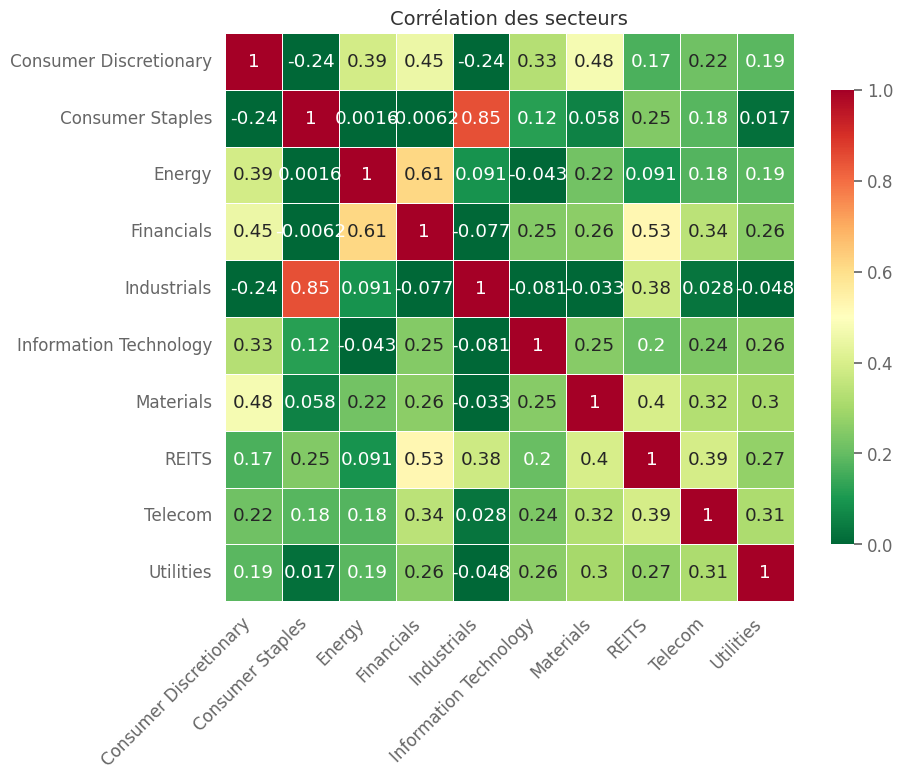

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 1. Calcul des rendements sectoriels et globaux
aggregated_portfolio_value_df, total_aggregated_portfolio_value_df, aggregated_portfolio_weights_df, aggregated_portfolio_daily_returns_df = get_portfolio_by_sector_df()

# 2. Rendements mensuels par secteur
monthly_sector_returns = aggregated_portfolio_daily_returns_df.resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()

# 3. Statistiques par secteur
mean_annual_return = monthly_sector_returns.mean() * 12
annual_volatility = monthly_sector_returns.std() * (12 ** 0.5)
sharpe_ratio = mean_annual_return / annual_volatility

sector_stats_df = pd.DataFrame({
    'Rendement annuel moyen': mean_annual_return,
    'Volatilité annualisée': annual_volatility,
    'Ratio rendement/risque': sharpe_ratio
})

# 4. Corrélation entre les secteurs
correlation_matrix = monthly_sector_returns.corr()

# 5. Statistiques du portefeuille global
monthly_total_returns = total_aggregated_portfolio_value_df.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()
portfolio_mean_annual_return = monthly_total_returns.mean() * 12
portfolio_annual_volatility = monthly_total_returns.std() * (12 ** 0.5)
portfolio_sharpe_ratio = portfolio_mean_annual_return / portfolio_annual_volatility

portfolio_stats_df = pd.DataFrame({
    'Rendement annuel moyen': [portfolio_mean_annual_return],
    'Volatilité annualisée': [portfolio_annual_volatility],
    'Ratio rendement/risque': [portfolio_sharpe_ratio]
}, index=["Portefeuille global"])

# 6. Graphs
print("Statistiques par secteur :\n")
display(sector_stats_df)

print("\n Statistiques du portefeuille global :\n")
display(portfolio_stats_df)

# 6.1. Heatmap de corrélation stylisée
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='RdYlGn_r',
    vmin=0, vmax=1,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Corrélation des secteurs", fontsize=14)
plt.xticks(rotation=45, ha='right')  # ✅ CORRECTION ICI
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300)
plt.show()

files.download("correlation_heatmap.png")


# 2 - Graphique du portefeuille de PF

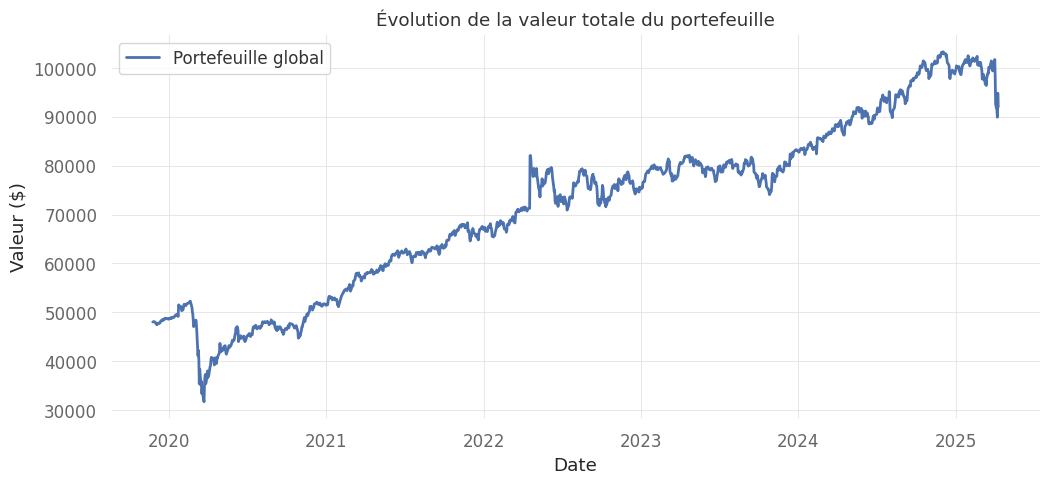

<Figure size 1200x600 with 0 Axes>

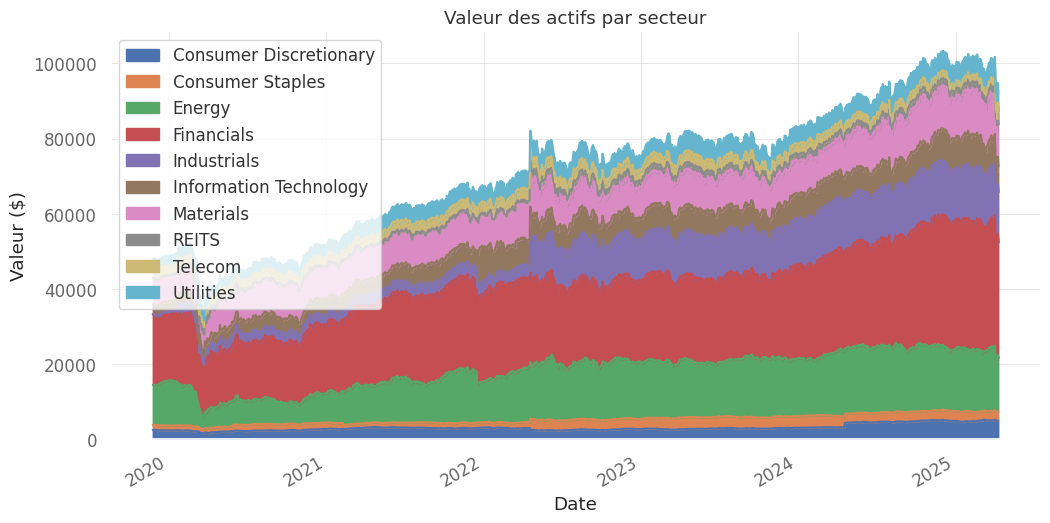

<ipython-input-13-f150827c7b84>:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_returns = total_aggregated_portfolio_value_df.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


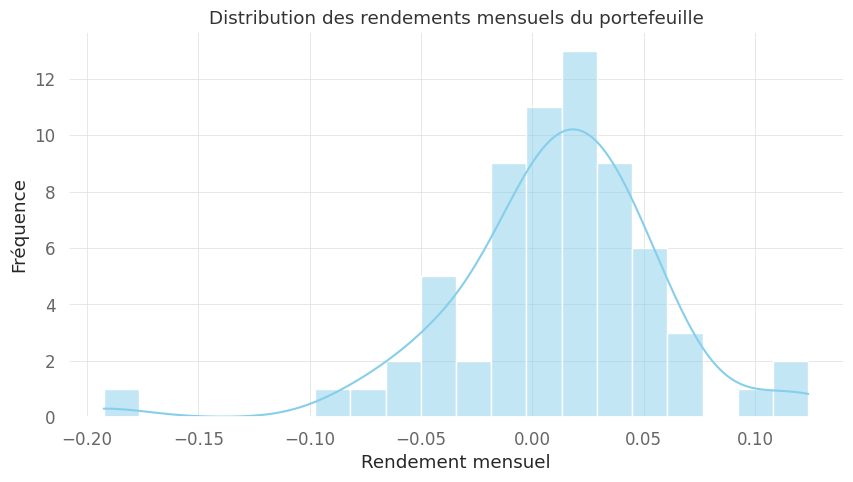

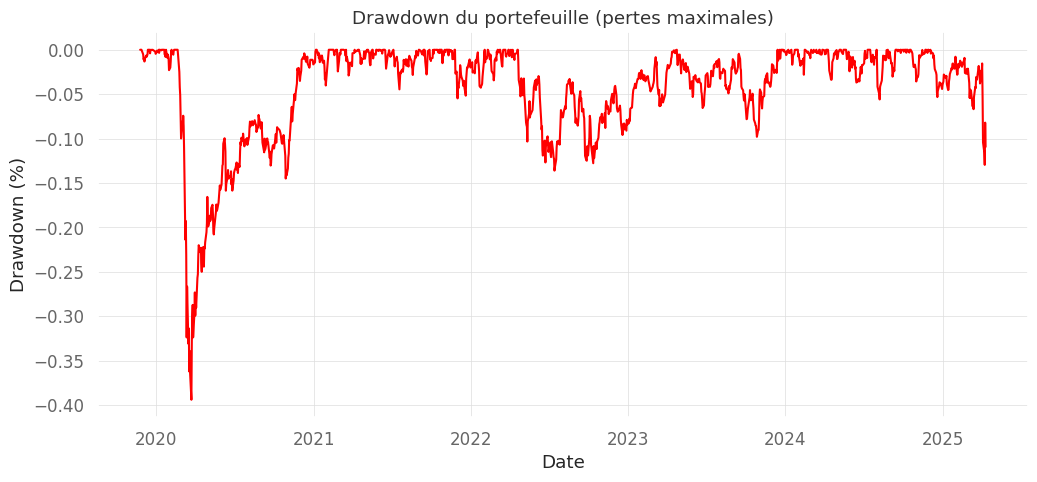

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-13-f150827c7b84>:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_returns = total_aggregated_portfolio_value_df.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

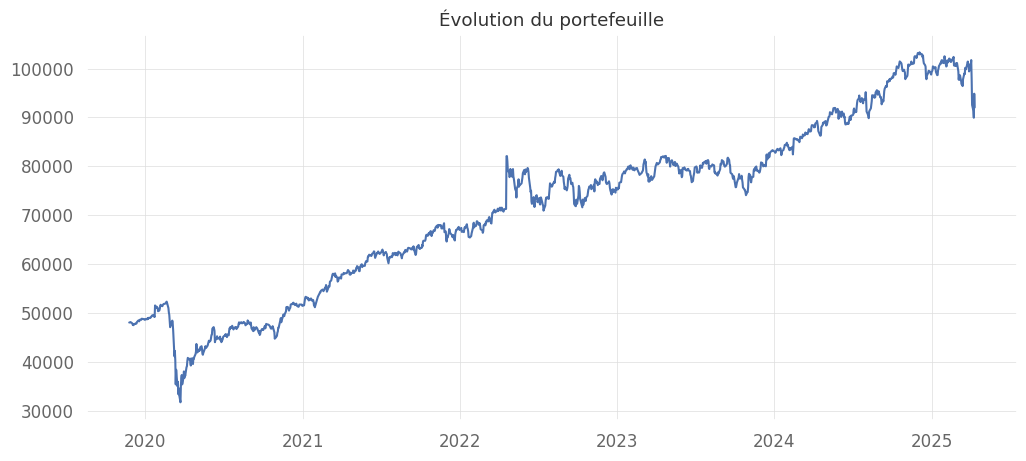

In [ ]:
# data reset (au cas ou)
aggregated_portfolio_value_df, total_aggregated_portfolio_value_df, aggregated_portfolio_weights_df, aggregated_portfolio_daily_returns_df = get_portfolio_by_sector_df()

# 1. Évolution de la valeur totale du portefeuille
plt.figure(figsize=(12, 5))
plt.plot(total_aggregated_portfolio_value_df, label="Portefeuille global", linewidth=2)
plt.title("Évolution de la valeur totale du portefeuille")
plt.xlabel("Date")
plt.ylabel("Valeur ($)")
plt.legend()
plt.grid(True)
plt.show()

# 2. Valeur des actifs par secteur
plt.figure(figsize=(12, 6))
aggregated_portfolio_value_df.plot.area(stacked=True, figsize=(12,6))
plt.title("Valeur des actifs par secteur")
plt.ylabel("Valeur ($)")
plt.xlabel("Date")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# 3. Distribution des rendements mensuels du portefeuille global
monthly_total_returns = total_aggregated_portfolio_value_df.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()

plt.figure(figsize=(10, 5))
sns.histplot(monthly_total_returns, kde=True, bins=20, color="skyblue")
plt.title("Distribution des rendements mensuels du portefeuille")
plt.xlabel("Rendement mensuel")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

# 4. Max drawdown
cumulative = total_aggregated_portfolio_value_df / total_aggregated_portfolio_value_df.iloc[0]
rolling_max = cumulative.cummax()
drawdown = cumulative / rolling_max - 1

plt.figure(figsize=(12, 5))
plt.plot(drawdown, color='red')
plt.title("Drawdown du portefeuille (pertes maximales)")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_aggregated_portfolio_value_df)
plt.title("Évolution du portefeuille")

# 1. Évolution de la valeur totale du portefeuille
plt.figure(figsize=(12, 5))
plt.plot(total_aggregated_portfolio_value_df, label="Portefeuille global", linewidth=2)
plt.title("Évolution de la valeur totale du portefeuille")
plt.xlabel("Date")
plt.ylabel("Valeur ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("valeur_totale_portefeuille.png", dpi=300)
files.download("valeur_totale_portefeuille.png")
plt.close()

# 2. Valeur des actifs par secteur
fig, ax = plt.subplots(figsize=(12, 6))
aggregated_portfolio_value_df.plot.area(stacked=True, ax=ax)
plt.title("Valeur des actifs par secteur")
plt.ylabel("Valeur ($)")
plt.xlabel("Date")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.savefig("valeur_par_secteur.png", dpi=300)
files.download("valeur_par_secteur.png")
plt.close()

# 3. Distribution des rendements mensuels
monthly_total_returns = total_aggregated_portfolio_value_df.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()
plt.figure(figsize=(10, 5))
sns.histplot(monthly_total_returns, kde=True, bins=20, color="skyblue")
plt.title("Distribution des rendements mensuels du portefeuille")
plt.xlabel("Rendement mensuel")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.savefig("rendements_mensuels.png", dpi=300)
files.download("rendements_mensuels.png")
plt.close()

# 4. Max drawdown
cumulative = total_aggregated_portfolio_value_df / total_aggregated_portfolio_value_df.iloc[0]
rolling_max = cumulative.cummax()
drawdown = cumulative / rolling_max - 1
plt.figure(figsize=(12, 5))
plt.plot(drawdown, color='red')
plt.title("Drawdown du portefeuille (pertes maximales)")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig("drawdown_portefeuille.png", dpi=300)
files.download("drawdown_portefeuille.png")
plt.close()

 Analyse du secteur : Consumer Discretionary


<ipython-input-14-6840e9b35c6b>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


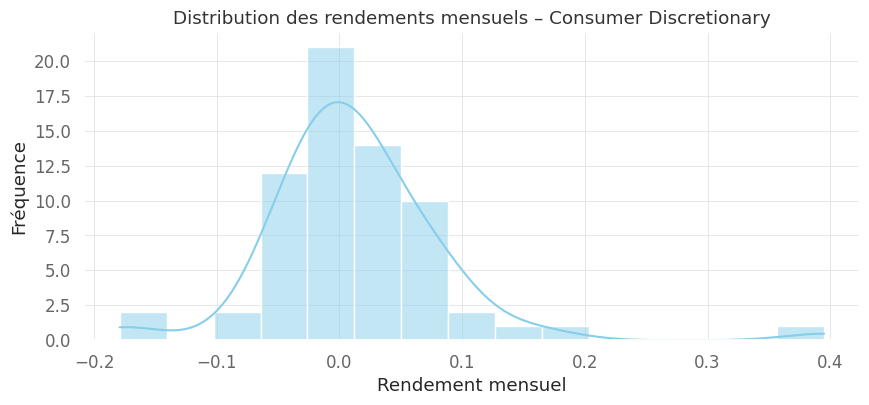

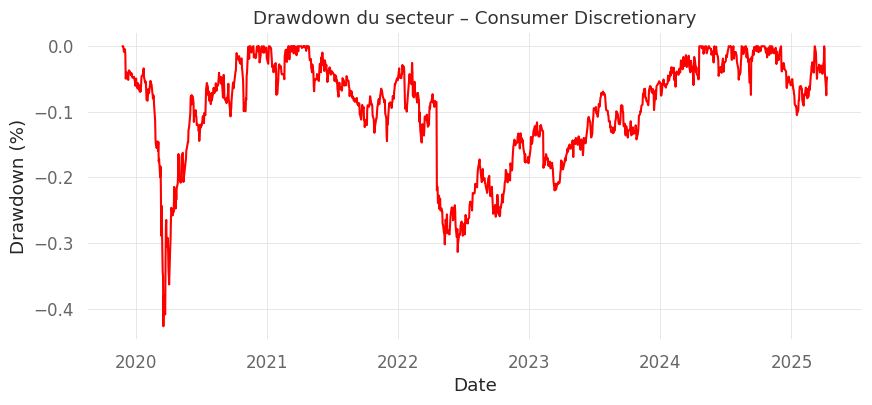

 Analyse du secteur : Consumer Staples


<ipython-input-14-6840e9b35c6b>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


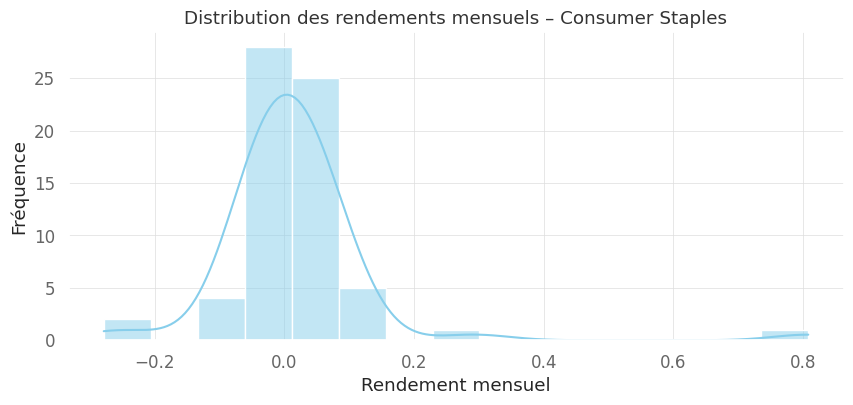

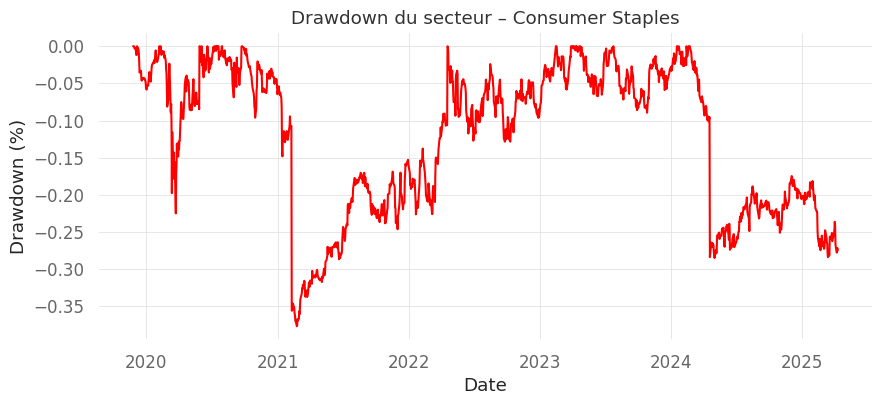

 Analyse du secteur : Energy


<ipython-input-14-6840e9b35c6b>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


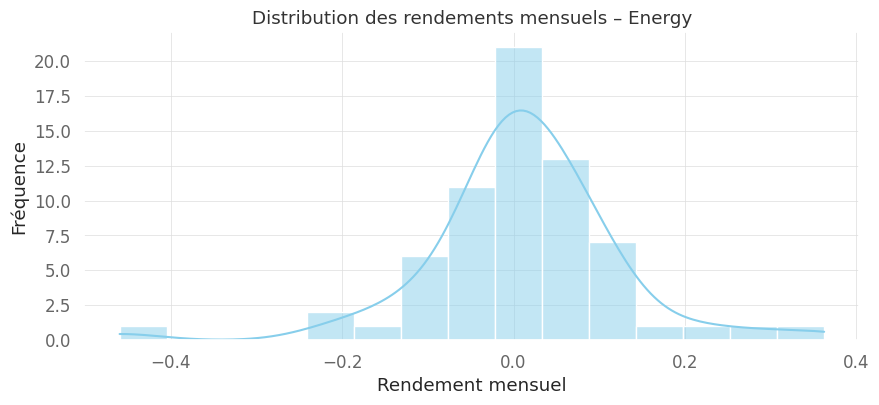

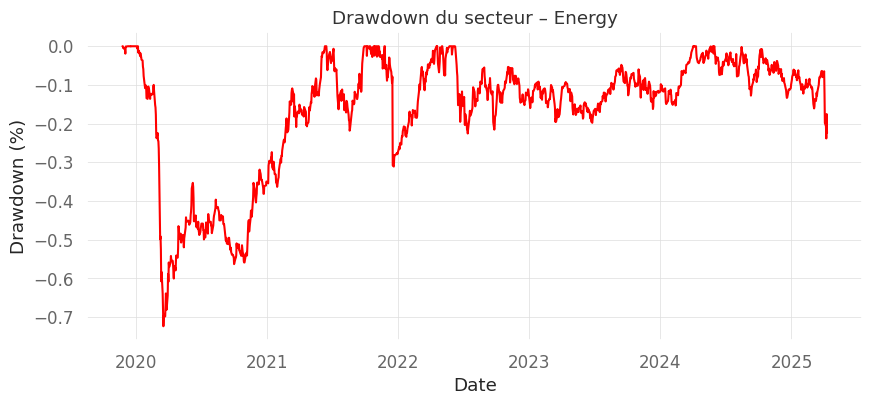

 Analyse du secteur : Financials


<ipython-input-14-6840e9b35c6b>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


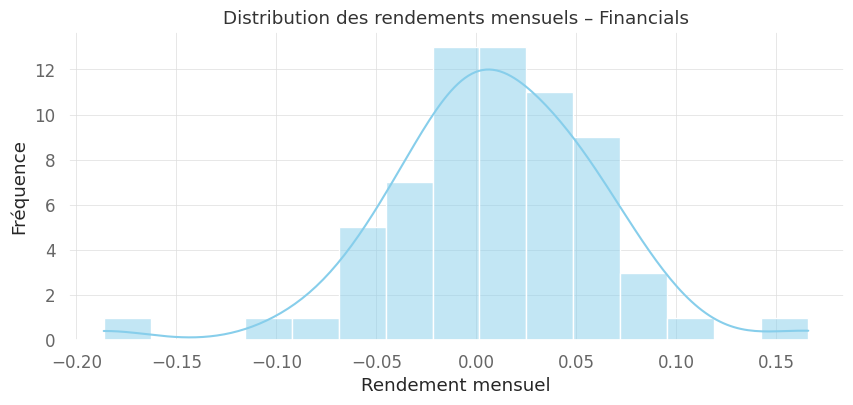

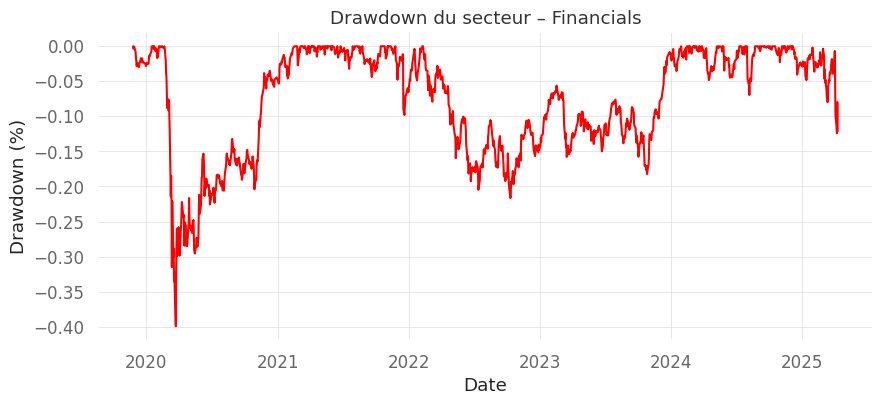

 Analyse du secteur : Industrials


<ipython-input-14-6840e9b35c6b>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


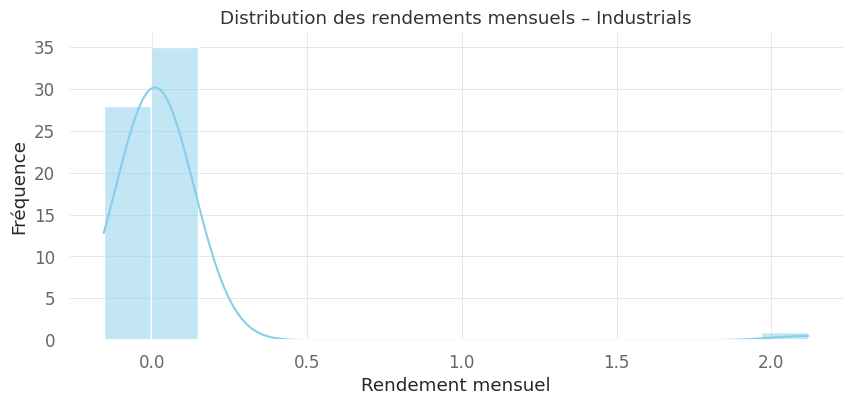

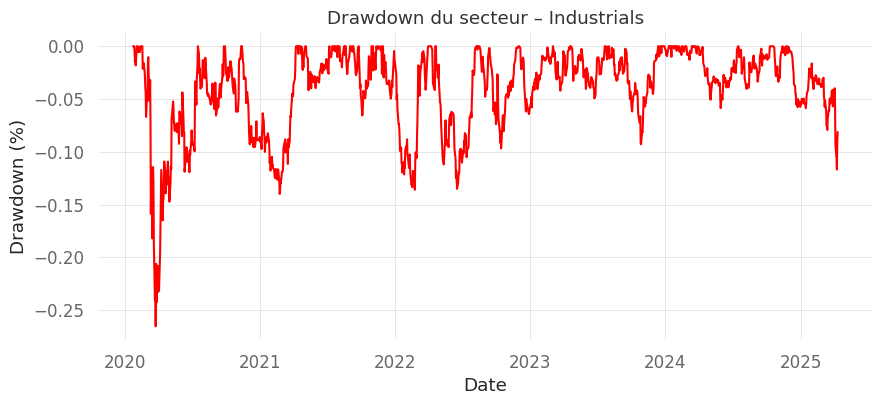

 Analyse du secteur : Information Technology


<ipython-input-14-6840e9b35c6b>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


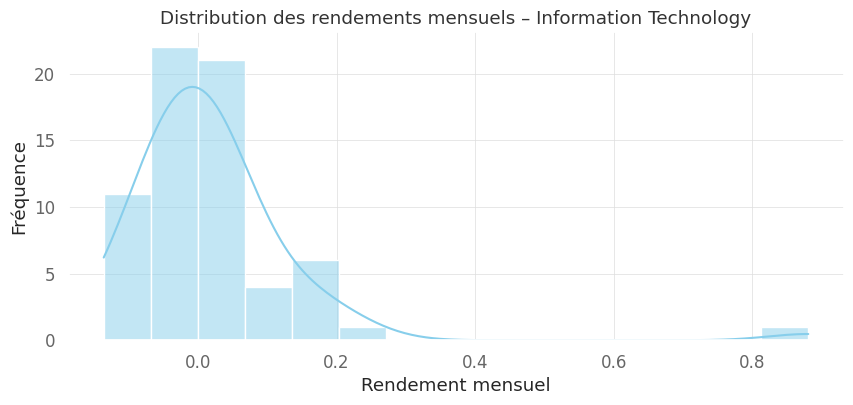

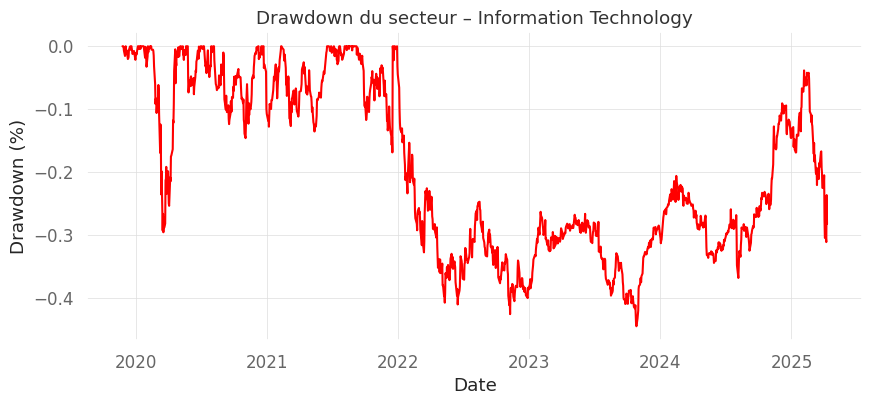

 Analyse du secteur : Materials


<ipython-input-14-6840e9b35c6b>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


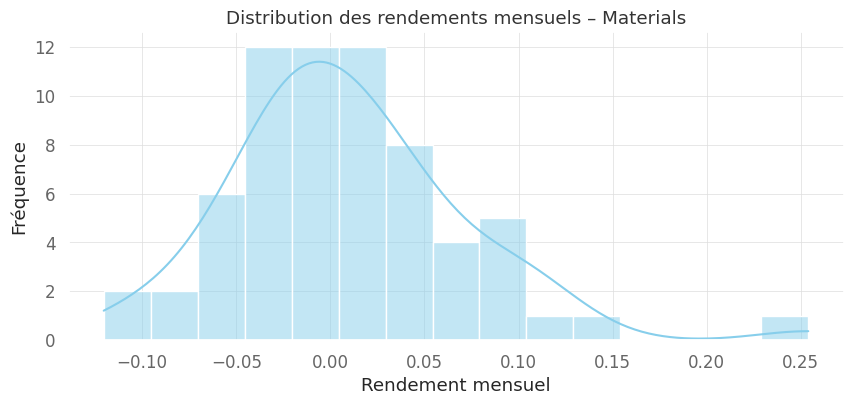

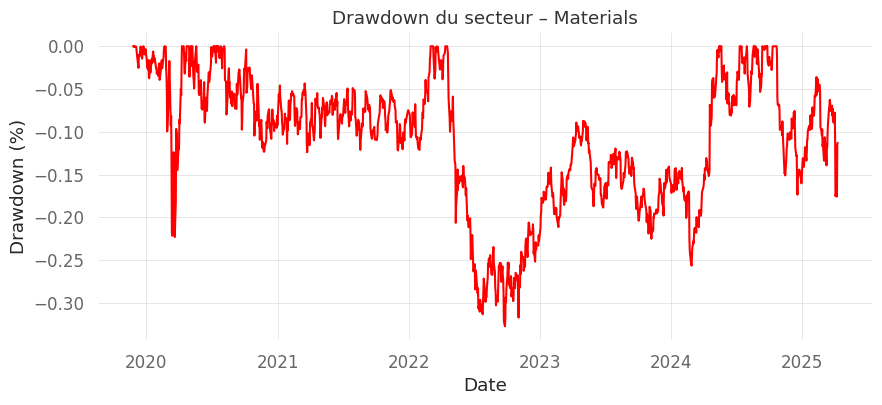

 Analyse du secteur : REITS


<ipython-input-14-6840e9b35c6b>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


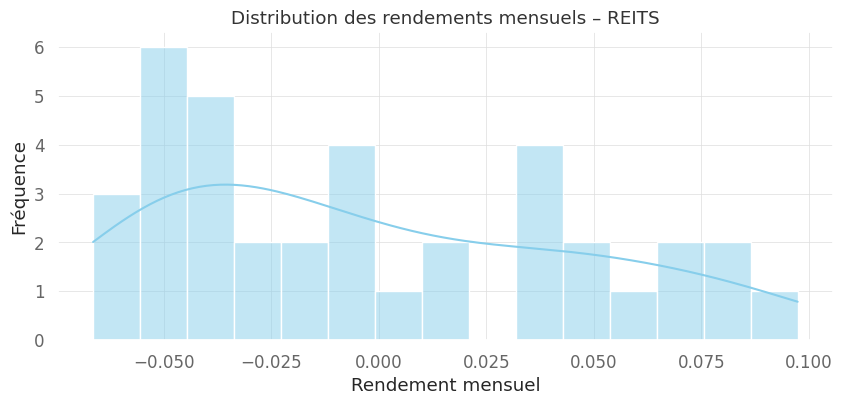

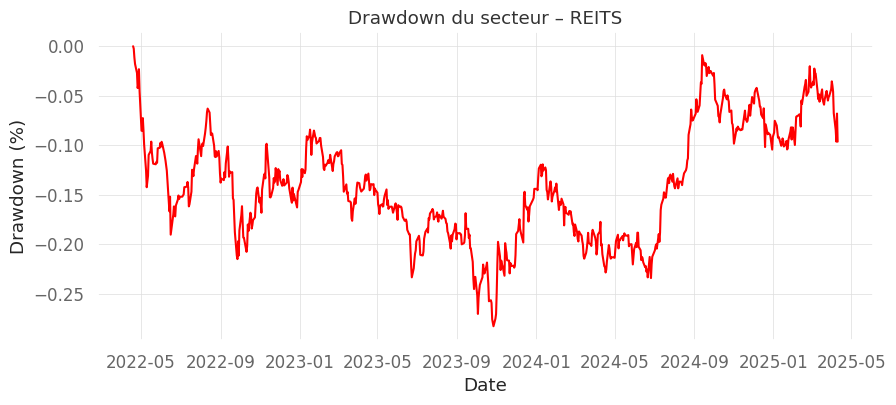

 Analyse du secteur : Telecom


<ipython-input-14-6840e9b35c6b>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


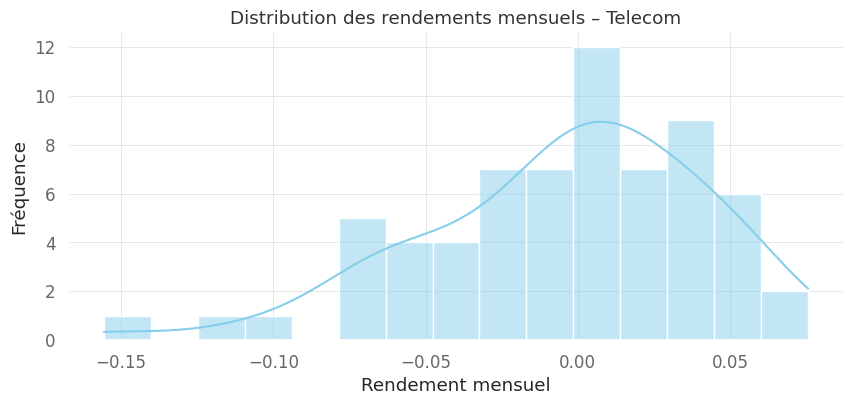

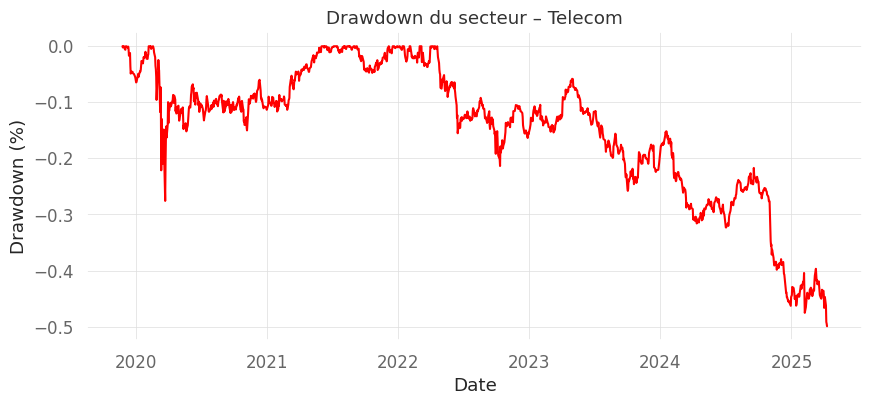

 Analyse du secteur : Utilities


<ipython-input-14-6840e9b35c6b>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


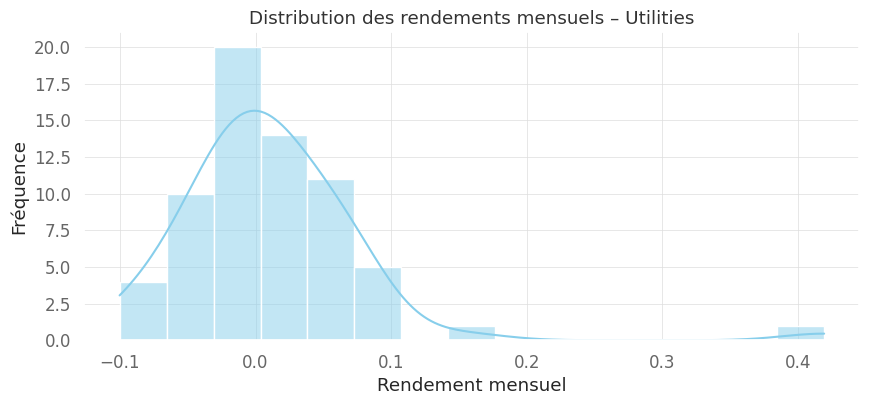

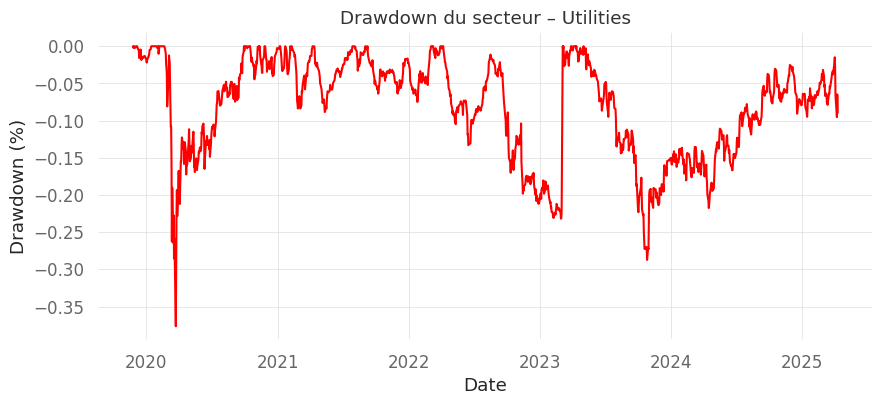

In [ ]:
# Analyse intelligente avec filtrage automatique
for secteur in aggregated_portfolio_value_df.columns:
    serie = aggregated_portfolio_value_df[secteur]

    # Ne garder que les périodes où il y a des valeurs > 0
    serie = serie[serie > 0]

    if len(serie) <= 2:
        print(f" Trop peu de données pour le secteur '{secteur}' → graphique ignoré.")
        continue

    print(f" Analyse du secteur : {secteur}")

    # 1. Distribution des rendements mensuels (sur la série filtrée)
    monthly_returns = serie.pct_change().dropna().resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()

    if monthly_returns.empty:
        print(f" Pas assez de rendements mensuels pour {secteur} → histogramme ignoré.")
    else:
        plt.figure(figsize=(10, 4))
        sns.histplot(monthly_returns, kde=True, bins=15, color='skyblue')
        plt.title(f"Distribution des rendements mensuels – {secteur}")
        plt.xlabel("Rendement mensuel")
        plt.ylabel("Fréquence")
        plt.grid(True)
        plt.show()

    # 2. Maximum drawdown (calcul sur la même série filtrée)
    cumulative = serie / serie.iloc[0]
    rolling_max = cumulative.cummax()
    drawdown = cumulative / rolling_max - 1

    plt.figure(figsize=(10, 4))
    plt.plot(drawdown, color='red')
    plt.title(f"Drawdown du secteur – {secteur}")
    plt.xlabel("Date")
    plt.ylabel("Drawdown (%)")
    plt.grid(True)
    plt.show()


# 3 - Optimisation du portefeuille global sur l'échantillon d'entraînement pour différentes stratégies

## Préparation de l'optimisation

### Mensualisation des rendements et des valeurs

In [ ]:
monthly_return_df = daily_returns_df.resample('ME').apply(lambda x: (1 + x).prod() - 1)
monthly_value_df = value_df.resample('ME').last()

### Séparation des échantillons d'entraînement et de tests pour l'optimisation de portefeuille

In [ ]:
split_date = '2023-04-11'

# Rendements mensuels d'entraînement (2019-11-25 --> 2023-04-10) et de test (2023-04-11 --> 2025-04-10)
monthly_return_train, monthly_return_test = monthly_return_df.loc[:split_date], monthly_return_df.loc[split_date:]

# Valeur mensuelle des actions du portefeuille d'entraînement (2019-11-25 --> 2023-04-10) et de test (2023-04-11 --> 2025-04-10)
monthly_value_train, monthly_value_test = monthly_value_df.loc[:split_date], monthly_value_df.loc[split_date:]

### Rendements moyens et matrice de covariance de l'échantillon d'entraînement

In [ ]:
mean_monthly_return = monthly_return_train.mean()
cov_monthly_return = monthly_return_train.cov()

## Fonctions utilitaires pour l'optimisation de portefeuille et la création de graphique

In [ ]:
# Fonction qui calcule la performance annuelle du portefeuille
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *12
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    return std, returns

# Fonction utilisée dans le calcul du portefeuille à variance minimale
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

# Fonction qui calcule le portefeuille à variance minimale
def min_variance(mean_returns, cov_matrix, lower_bound=0.0, upper_bound=1.0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((lower_bound, upper_bound) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Fonction qui calcule le Sharpe ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.0, lower_bound=0.0, upper_bound=1.0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((lower_bound, upper_bound) for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def equal_weight_portfolio(mean_returns, cov_matrix):

    num_assets = len(mean_returns)
    weights = np.full(num_assets, 1 / num_assets)
    return SimpleNamespace(x=weights)

def plot_portfolio_weights(weights, asset_names, portfolio_name):
    fig, ax = plt.subplots(figsize=(25, 10))

    ax.bar(asset_names, weights, color='skyblue')

    ax.set_ylabel("Weight")
    ax.set_xlabel("Assets")
    ax.set_title(f'Répartition de {portfolio_name} par action')

    plt.xticks(rotation=45, ha='right')

    max_weight = max(weights)
    ax.set_ylim(0, max_weight * 1.1)

    for i, weight in enumerate(weights):
        ax.text(i, weight + max_weight * 0.05, f"{weight:.4f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    fig.savefig(f'figures/3_{portfolio_name}.png', dpi=300)
    files.download(f'figures/3_{portfolio_name}.png')

def display_portfolio_performance(weights, mean_returns, cov_matrix):
    std, ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    performance_df = pd.DataFrame(data=[[ret, std]],
                                   columns=['Rendement moyen', 'Volatilité'],
                                   index=['Portfolio'])
    performance_df = performance_df.style.format("{:.2%}")
    display(performance_df)

def aggregate_weight_by_sector(weights_series):
  # Calcul de la répartition du portefeuille par secteur en utilisant secteurs_dict.
  sector_allocation = {}
  for sector, tickers in secteurs_dict.items():
      # On ne conserve que les tickers du secteur présents dans le portefeuille.
      tickers_in_portfolio = [ticker for ticker in tickers if ticker in weights_series.index]
      # On somme les poids associés à ces tickers.
      sector_allocation[sector] = weights_series[tickers_in_portfolio].sum()
  return sector_allocation

# Pour afficher le résultat, vous pouvez utiliser un graphique en barres :
def plot_sector_allocation(sector_allocation, portfolio_name):
    # Conversion du dictionnaire en série pour faciliter le tracé.
    sector_series = pd.Series(sector_allocation)
    sector_series.sort_values(inplace=True)

    fig = plt.figure(figsize=(10,6))
    bars = plt.bar(sector_series.index, sector_series.values, color='skyblue')
    plt.xlabel('Secteur')
    plt.ylabel('Allocation du portefeuille')
    plt.title(f'Répartition de {portfolio_name} par secteur')
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2%}',  # ".2%" pour afficher le nombre en pourcentage à 2 décimales
            ha='center',
            va='bottom'
        )
    plt.tight_layout()
    plt.show()

    fig.savefig(f'figures/3_{portfolio_name}_by_sector.png', dpi=300)
    files.download(f'figures/3_{portfolio_name}_by_sector.png')

In [ ]:
def show_and_save_optimized_portfolio(portfolio, portfolio_name):
  weights = portfolio.x
  weights_series = pd.Series(weights, index=monthly_return_train.columns)

  # Répartition des poids du portefeuille par action
  plot_portfolio_weights(weights, monthly_return_train.columns, portfolio_name)
  display_portfolio_performance(weights, mean_monthly_return, cov_monthly_return)

  # Répartition des poids du portefeuille
  sector_allocation = aggregate_weight_by_sector(weights_series)
  plot_sector_allocation(sector_allocation, portfolio_name)

## Ptf1 : Portefeuille à variance minimale (Poids >= 0 ; Somme des poids = 1)

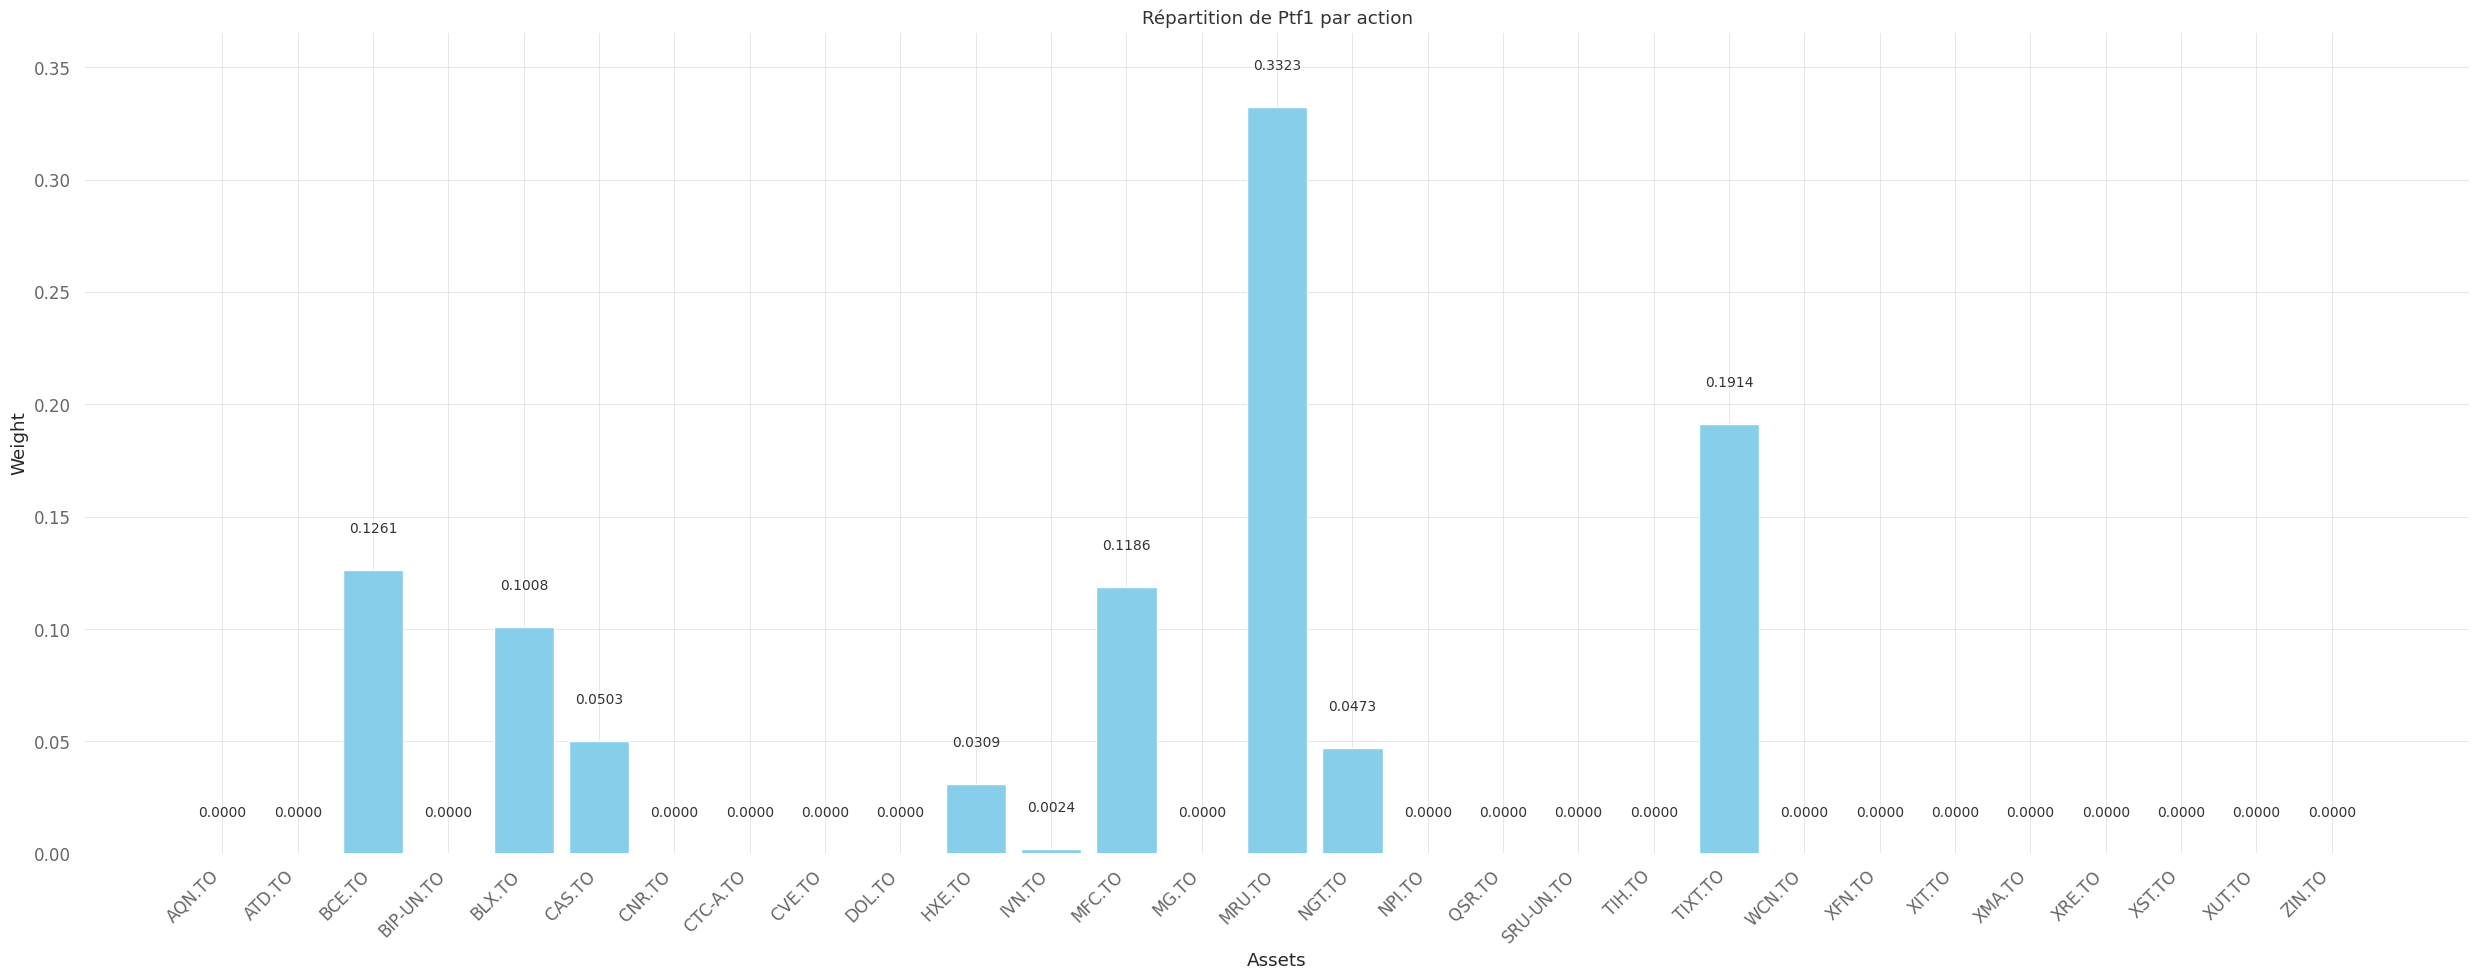

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

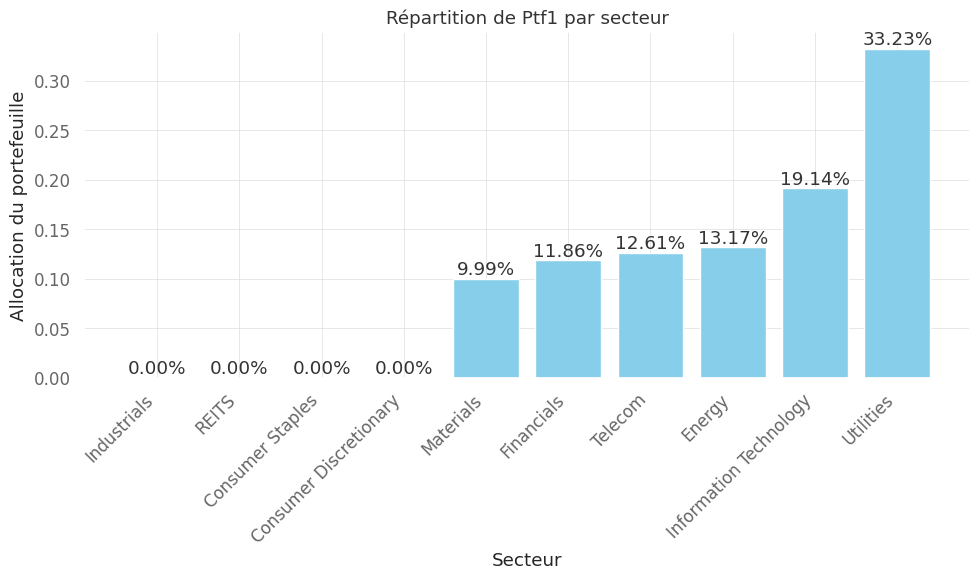

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Création du portfolio à variance minimale
Port_Min_Var  = min_variance(mean_monthly_return, cov_monthly_return)

show_and_save_optimized_portfolio(Port_Min_Var, 'Ptf1')

## Ptf2 : Portefeuille à variance minimale, 2% <= Poids <= 15 % ; Somme des poids = 1



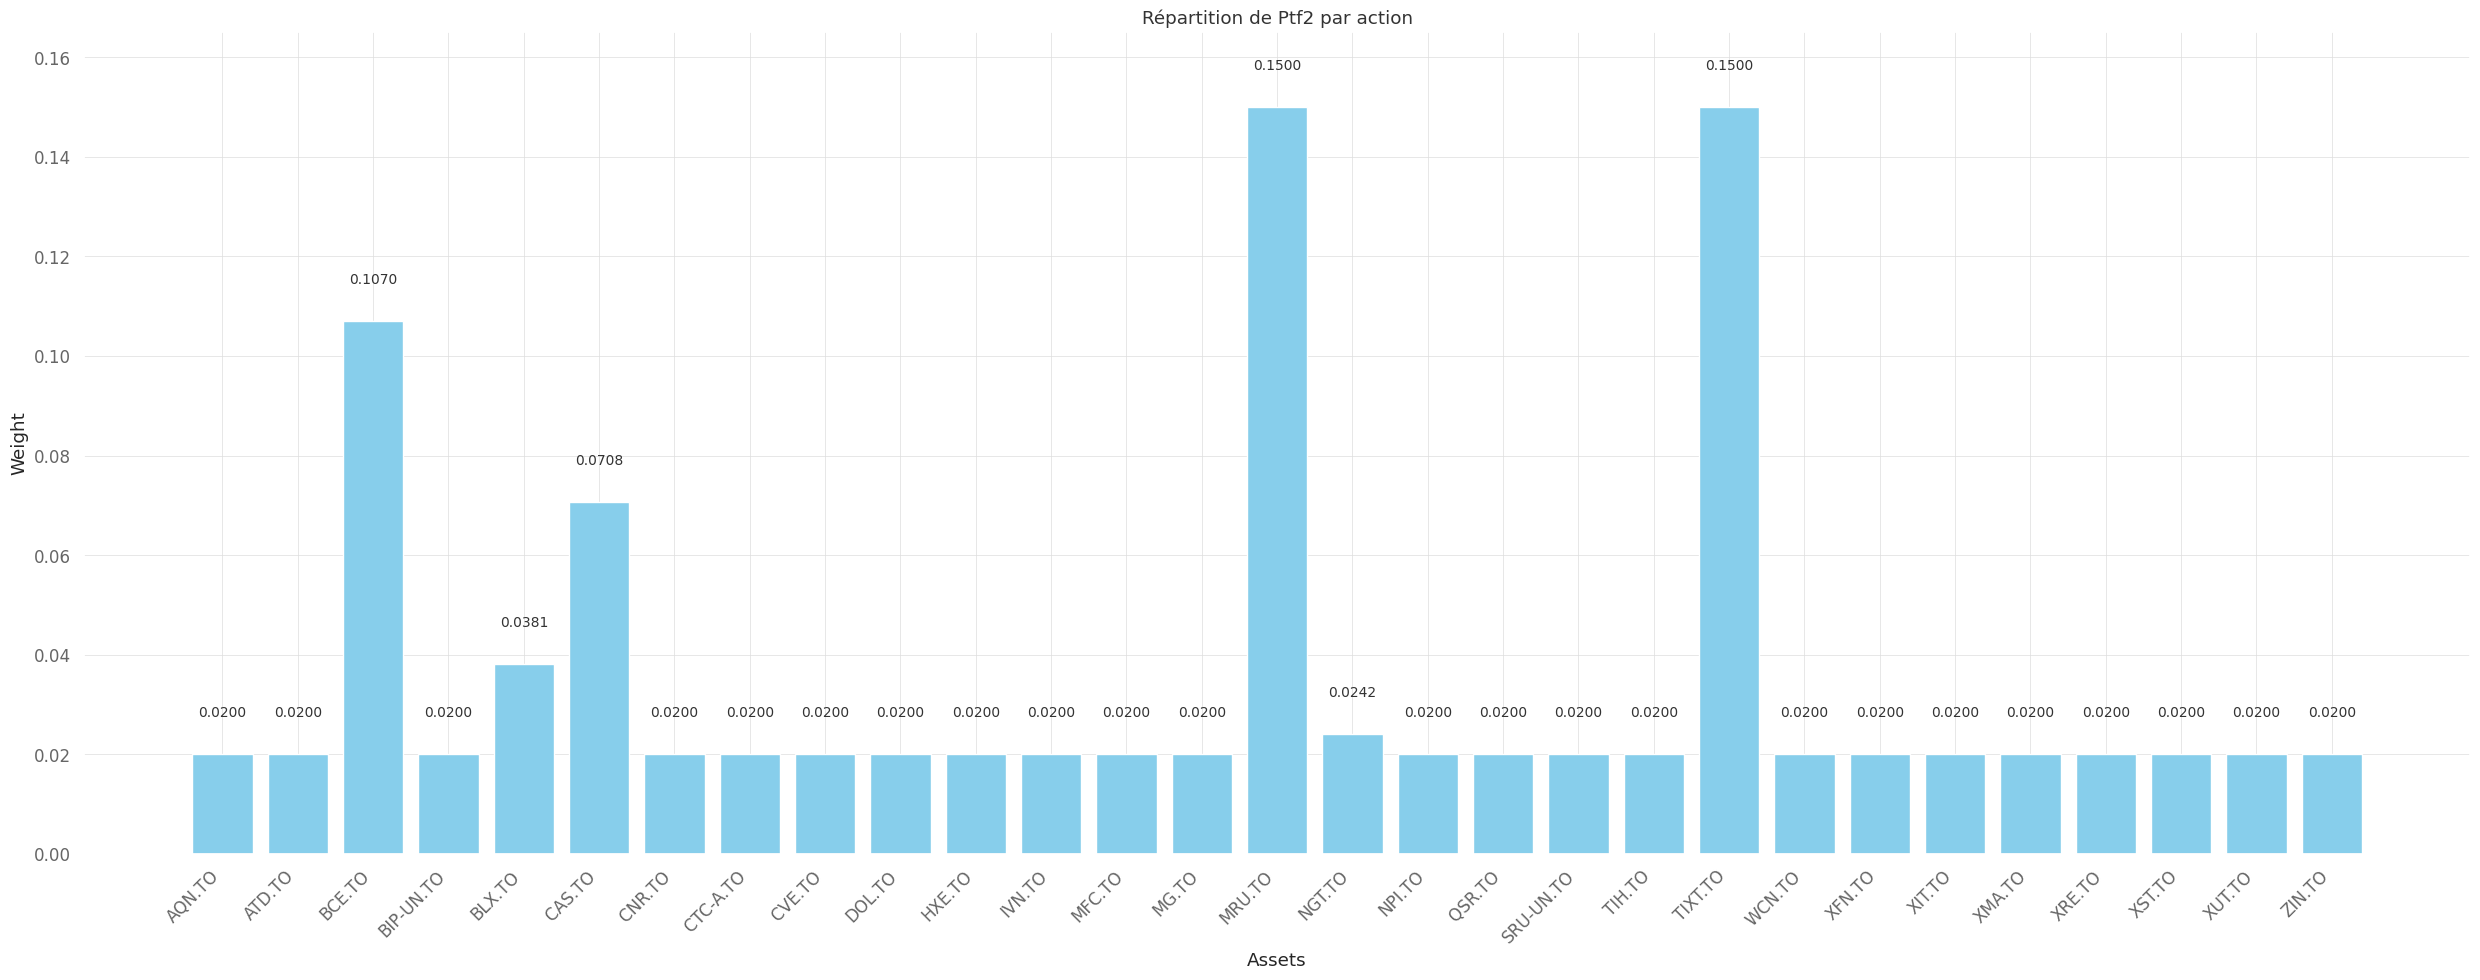

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

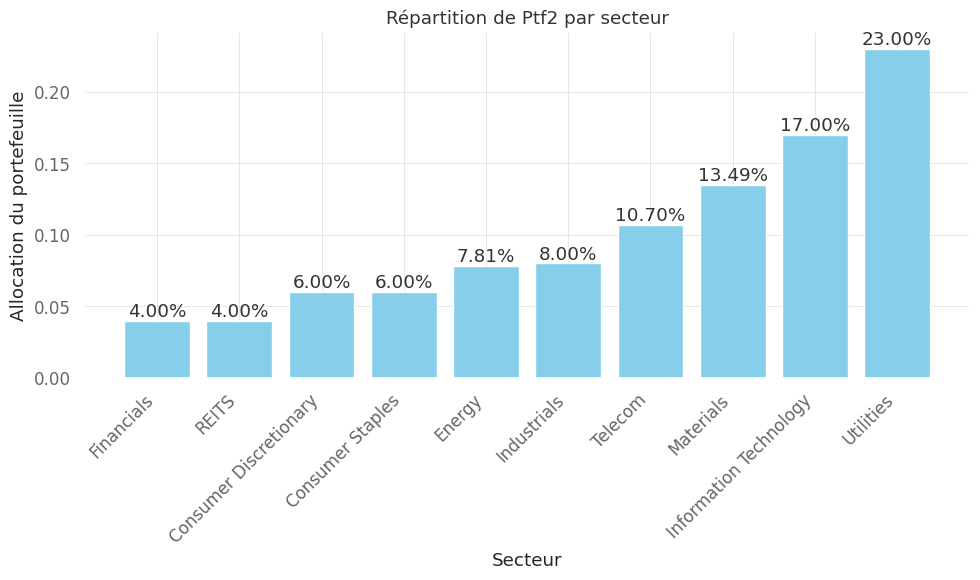

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
lower_bound = 0.02
upper_bound = 0.15

# Création du portfolio à variance minimale
Port_Min_Var_bounded  = min_variance(mean_monthly_return, cov_monthly_return, lower_bound, upper_bound)

show_and_save_optimized_portfolio(Port_Min_Var_bounded, 'Ptf2')

## Ptf3: maximisation ratio rendement / risque: poids >=0 ; somme des poids =1


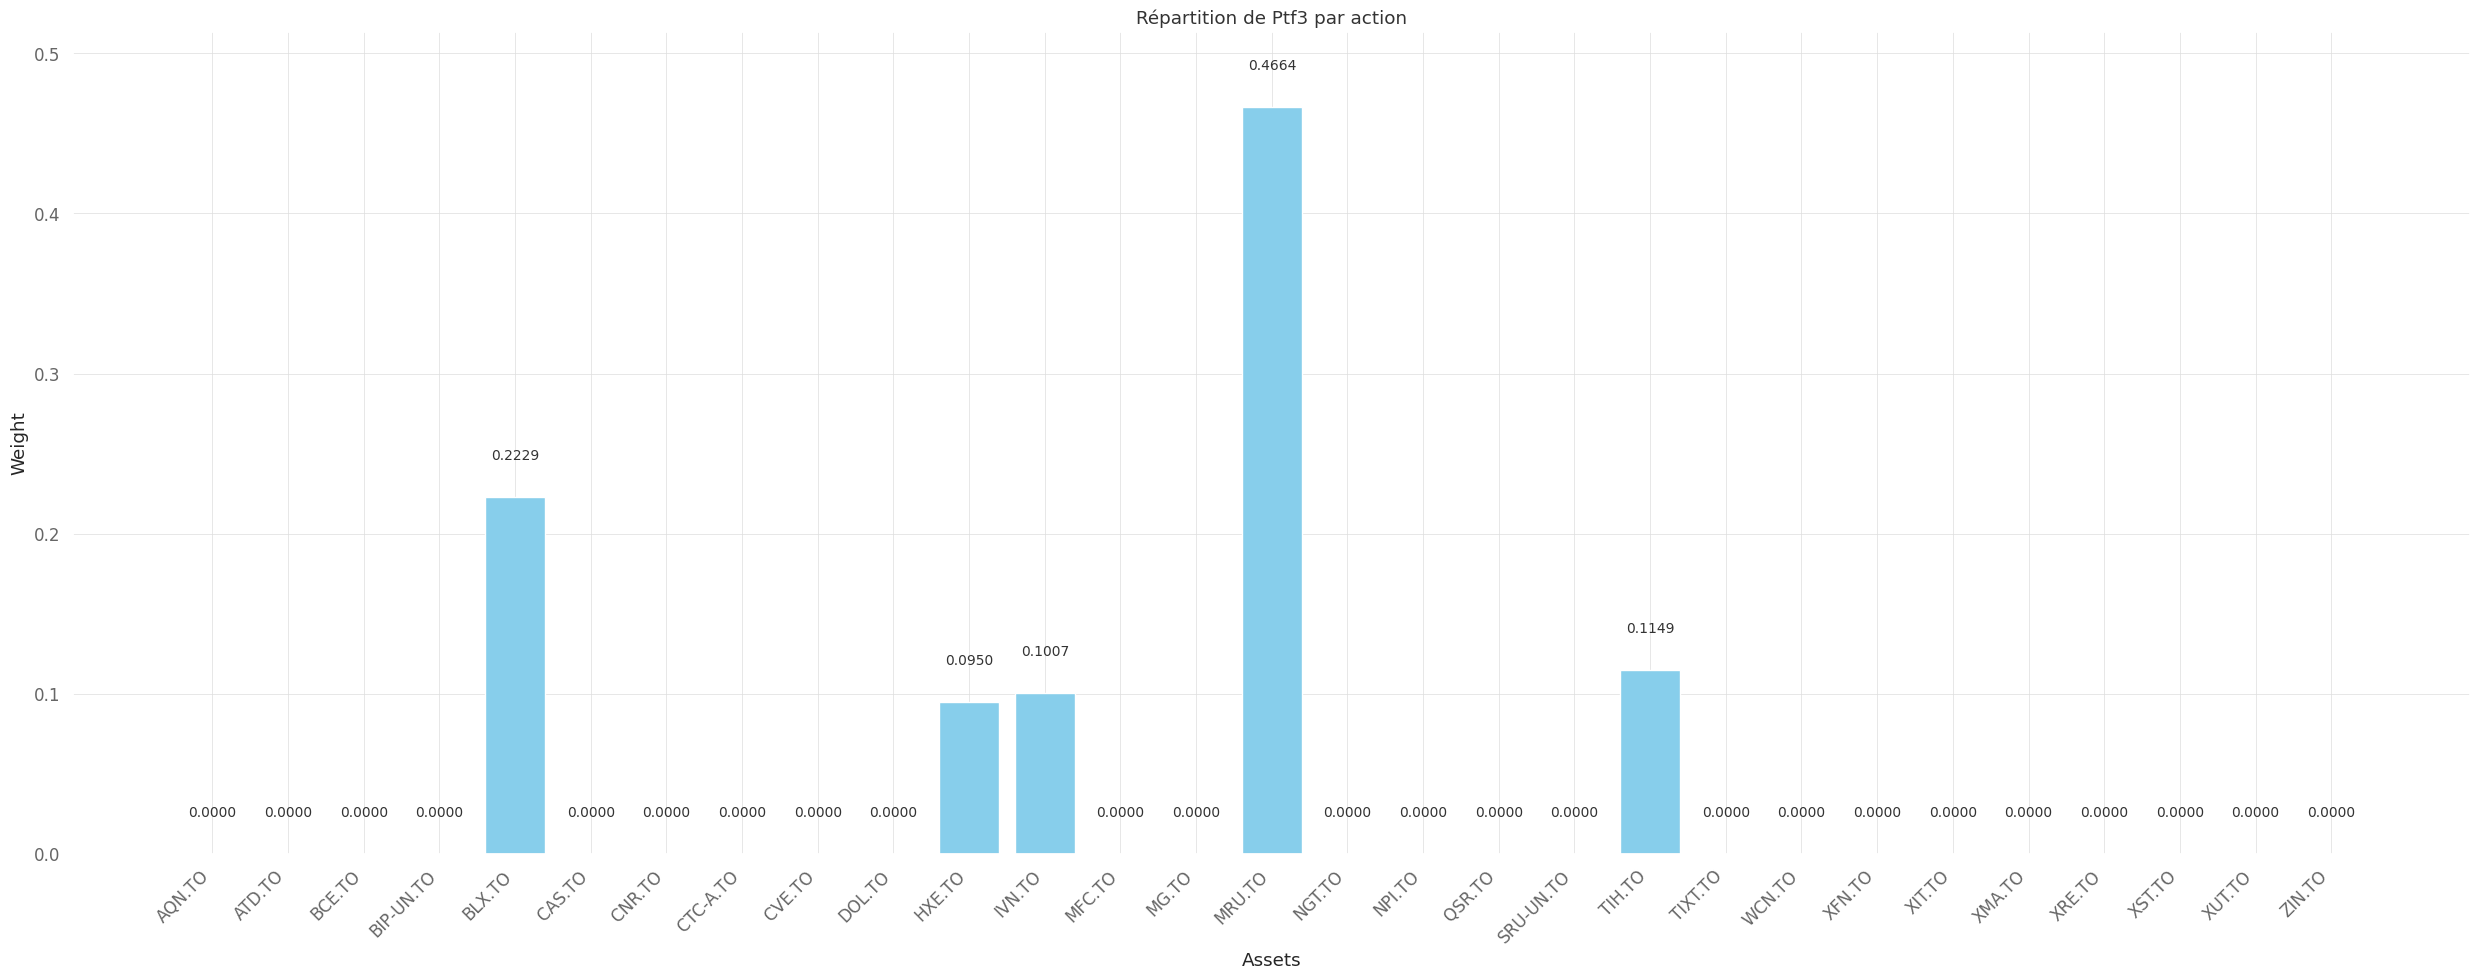

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

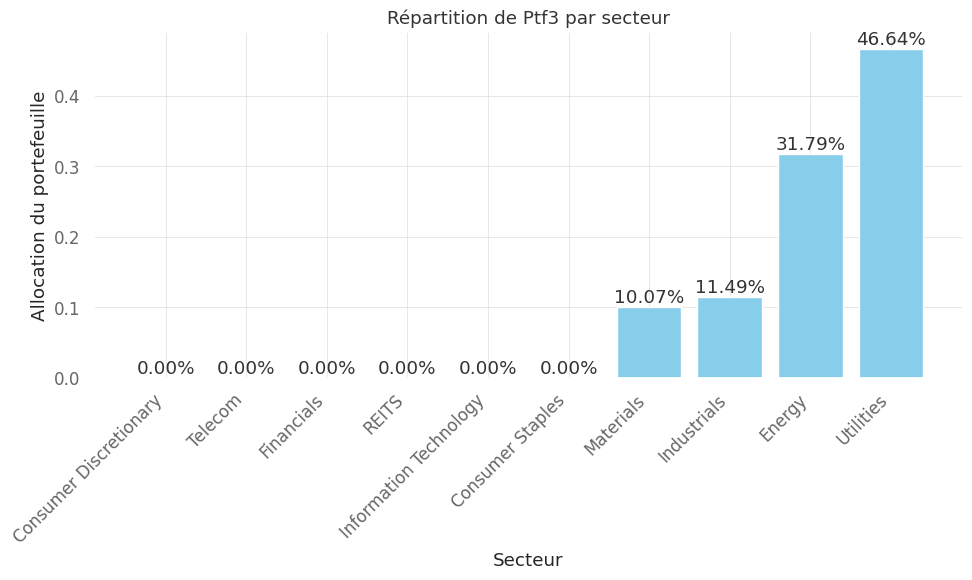

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Port_Max_Sharpe = max_sharpe_ratio(mean_monthly_return,cov_monthly_return)

show_and_save_optimized_portfolio(Port_Max_Sharpe, 'Ptf3')

## PTF4: maximisation ratio rendement / risque : 0.02 <= poids <= 0.15 ; somme des poids = 1

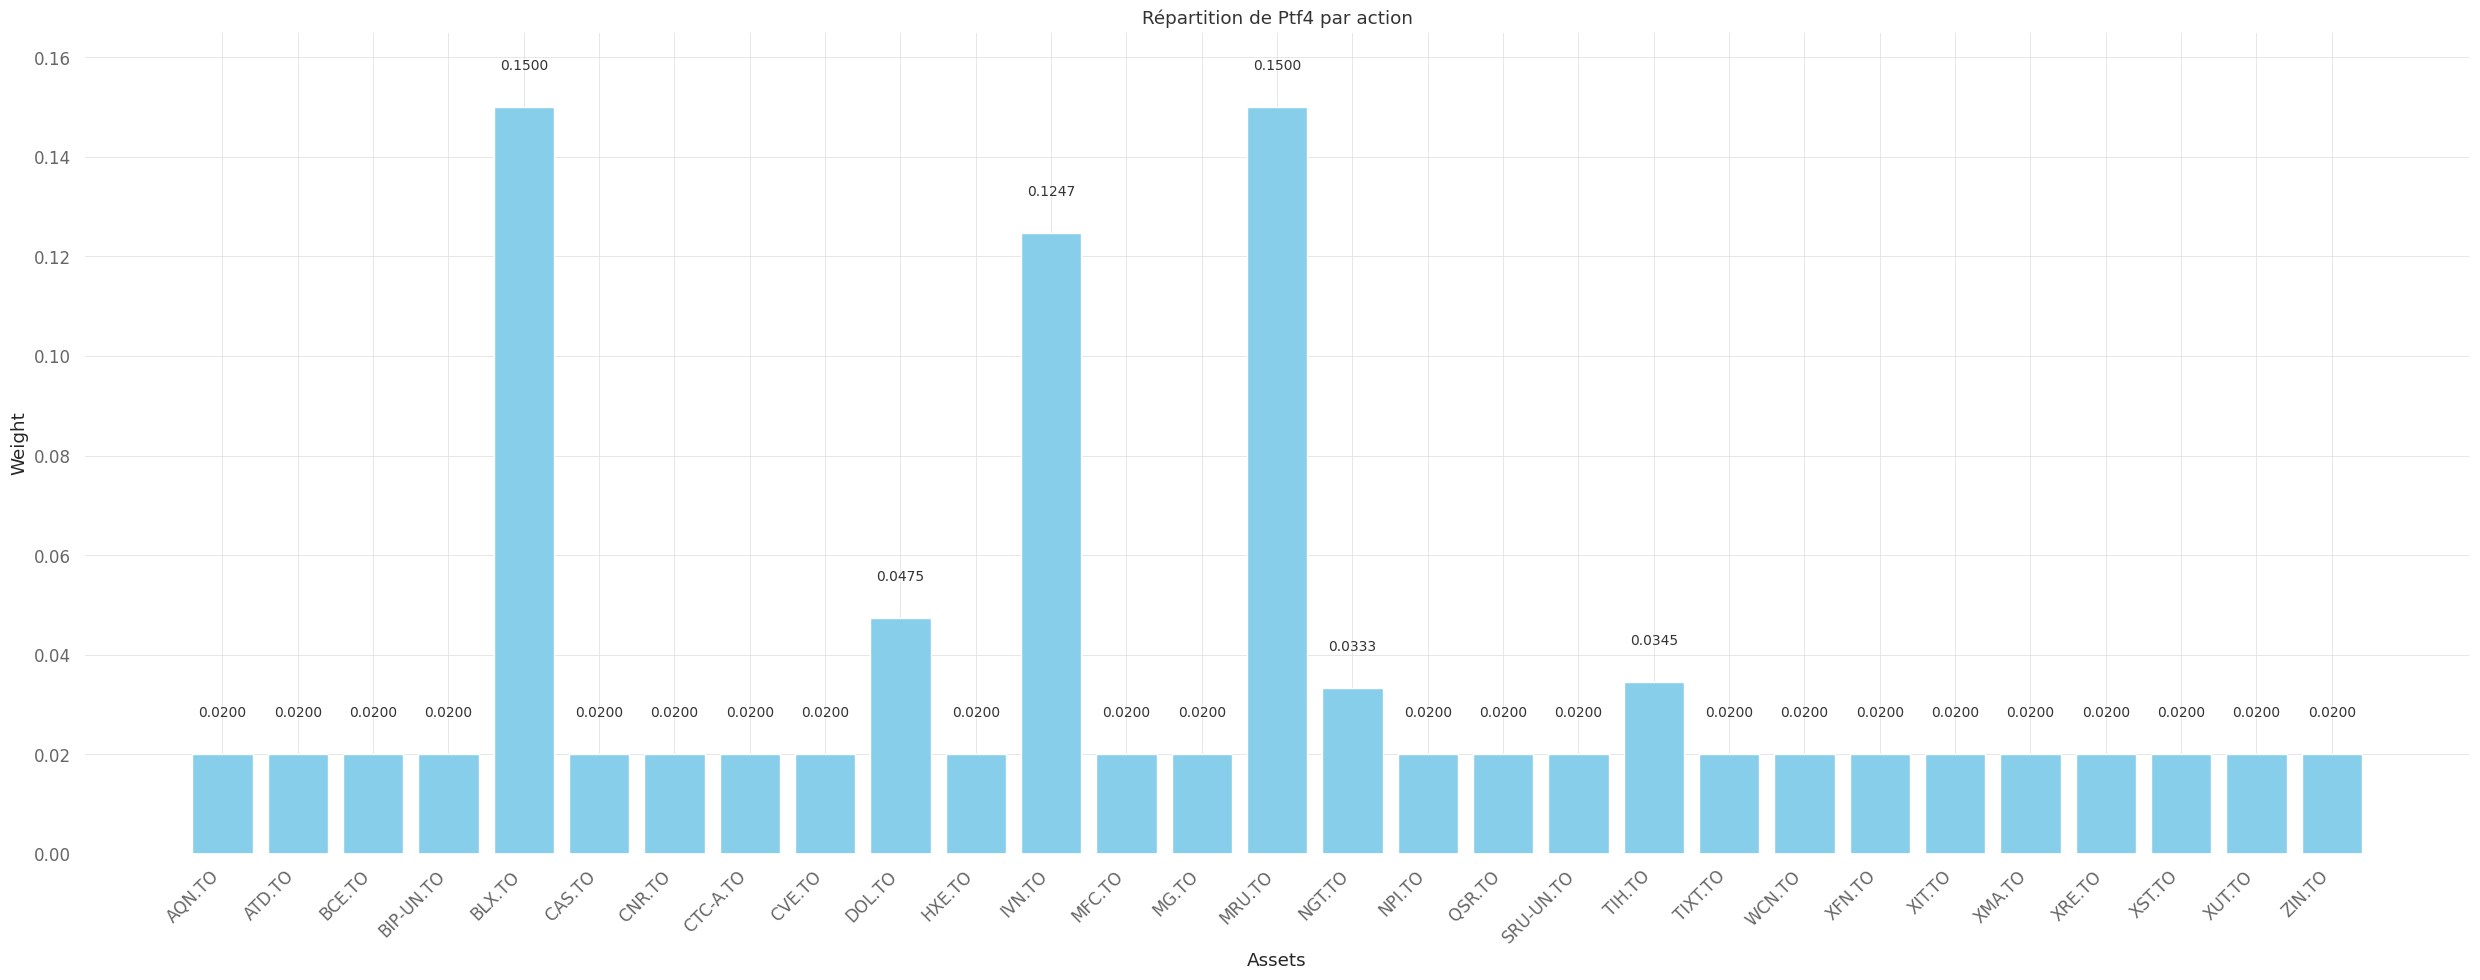

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

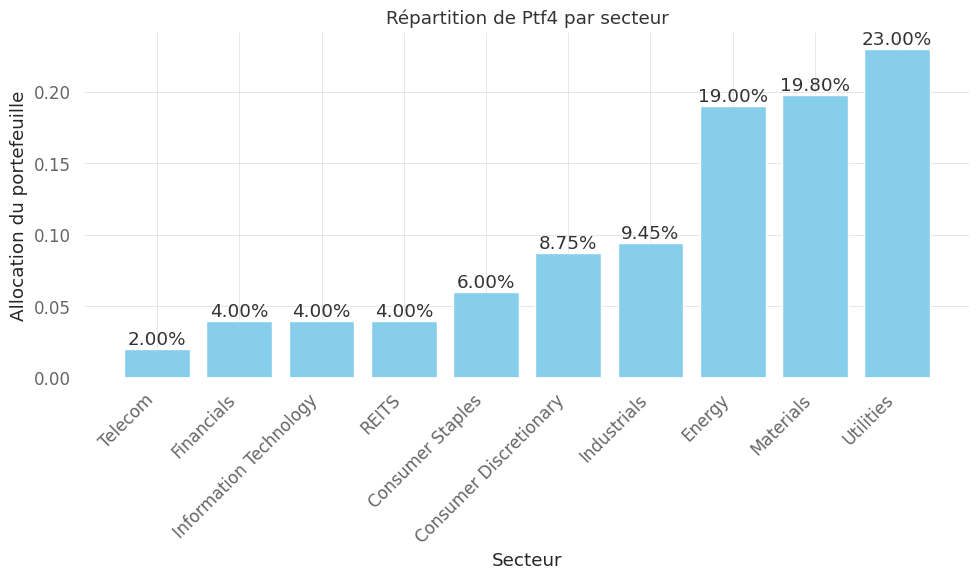

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
lower_bound = 0.02
upper_bound = 0.15

Port_Max_Sharpe_bounded = max_sharpe_ratio(mean_monthly_return,cov_monthly_return, 0, lower_bound, upper_bound)

show_and_save_optimized_portfolio(Port_Max_Sharpe_bounded, 'Ptf4')

## PTF5: Portefeuille équipondéré

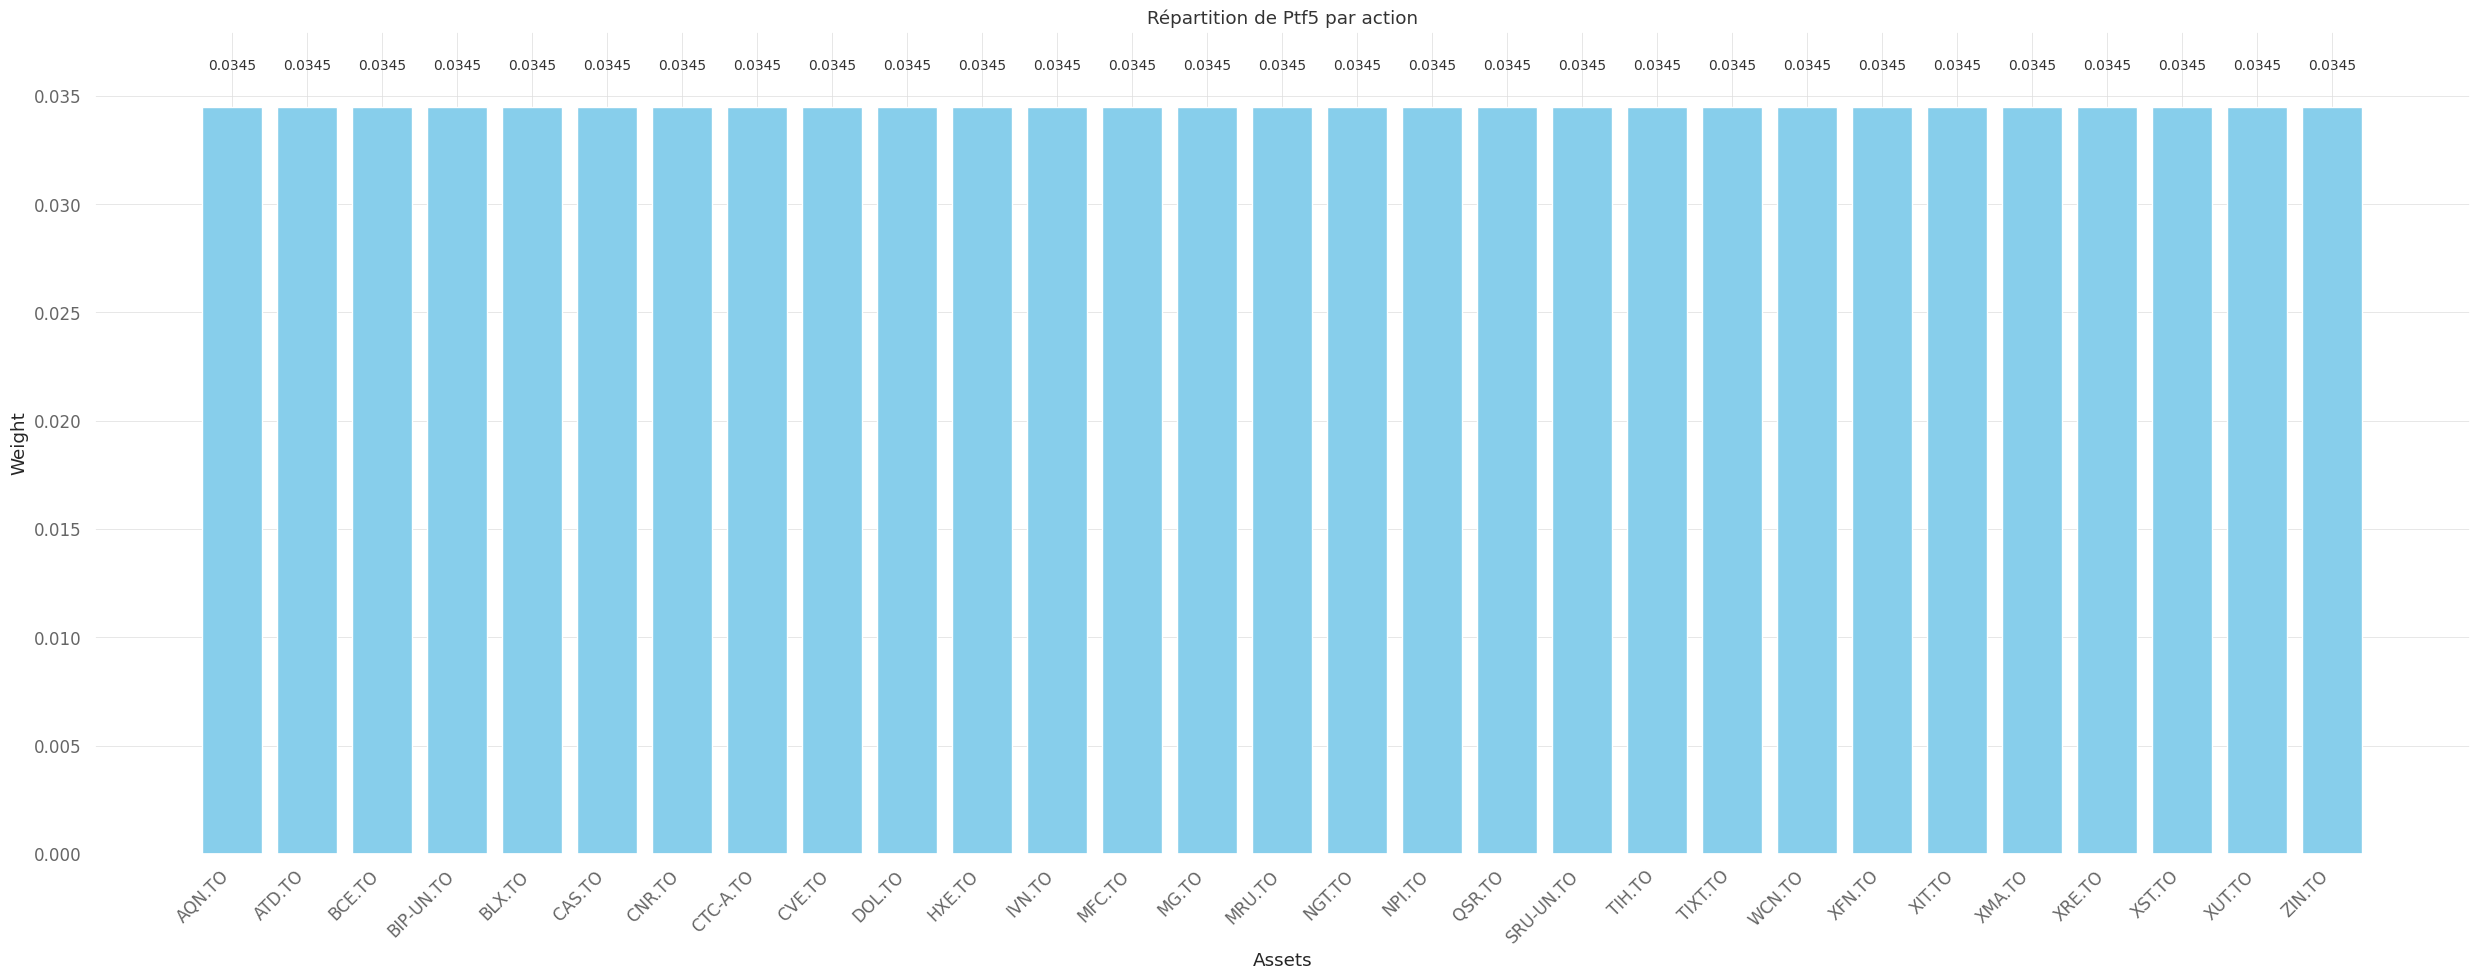

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

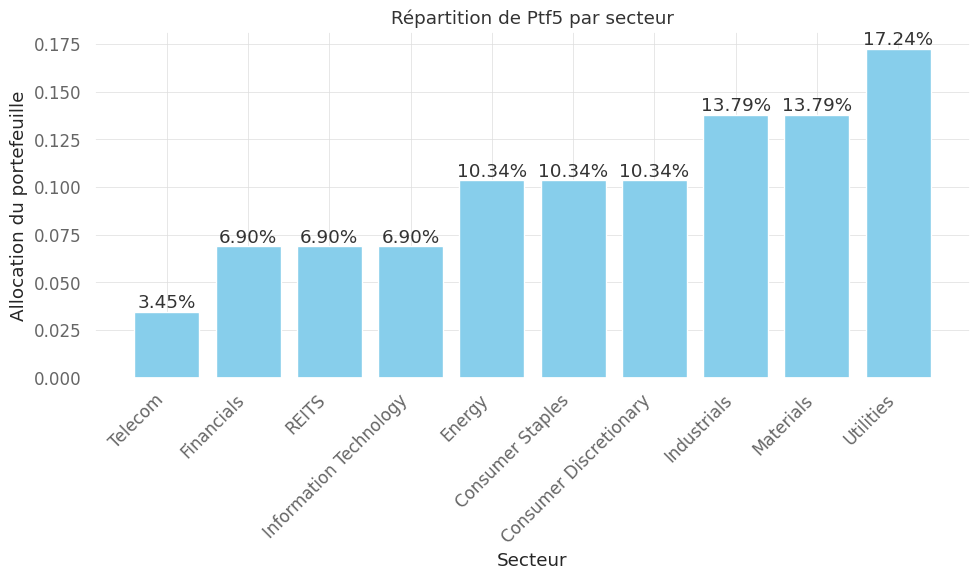

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Port_Equal_weights = equal_weight_portfolio(mean_monthly_return, cov_monthly_return)

show_and_save_optimized_portfolio(Port_Equal_weights, 'Ptf5')

## PTF6: Minimisation de l'expected shortfall (5% pires cas)

In [ ]:
def portfolio_expected_shortfall(weights, returns_data, percentile=5):
    """
    Calcule l'Expected Shortfall (ES) d'un portefeuille.

    Args:
        weights (array-like): Vecteur des poids du portefeuille.
        returns_data (pd.DataFrame ou np.ndarray): Table de rendements historiques
            (chaque colonne correspondant à un actif).
        percentile (float): Le percentile à utiliser pour la définition du VaR (par défaut 5).

    Returns:
        float: La valeur de l'Expected Shortfall (plus l'ES est élevé, plus le risque de perte extrême est important).
    """
    # Calcul des rendements du portefeuille
    p_returns = returns_data.dot(weights)

    # Calcul du VaR au percentile spécifié
    var_threshold = np.percentile(p_returns, percentile)

    # Calcul de l'Expected Shortfall: on prend l'opposé de la moyenne des rendements en dessous du VaR
    es = -np.mean(p_returns[p_returns <= var_threshold])
    return es

def min_expected_shortfall_portfolio(returns_data, percentile=5, lower_bound=0.0, upper_bound=1.0):
    """
    Optimise un portefeuille pour minimiser l'Expected Shortfall.

    Args:
        returns_data (pd.DataFrame ou np.ndarray): Matrice des rendements historiques (ex: monthly_return_train)
        percentile (float): Le percentile pour le calcul du VaR (défaut 5, correspondant aux 5% les plus défavorables).
        lower_bound (float): Borne inférieure pour chaque poids (par défaut 0.0: pas de vente à découvert).
        upper_bound (float): Borne supérieure pour chaque poids (par défaut 1.0).

    Returns:
        OptimizeResult: Objet retourné par scipy.optimize.minimize (contenant l'attribut x pour les poids optimaux).
    """
    num_assets = returns_data.shape[1]
    initial_guess = num_assets * [1. / num_assets]  # portefeuilles équipondéré comme point de départ
    args = (returns_data, percentile)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((lower_bound, upper_bound) for _ in range(num_assets))

    result = sco.minimize(
        lambda w, returns_data, percentile: portfolio_expected_shortfall(w, returns_data, percentile),
        initial_guess,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result

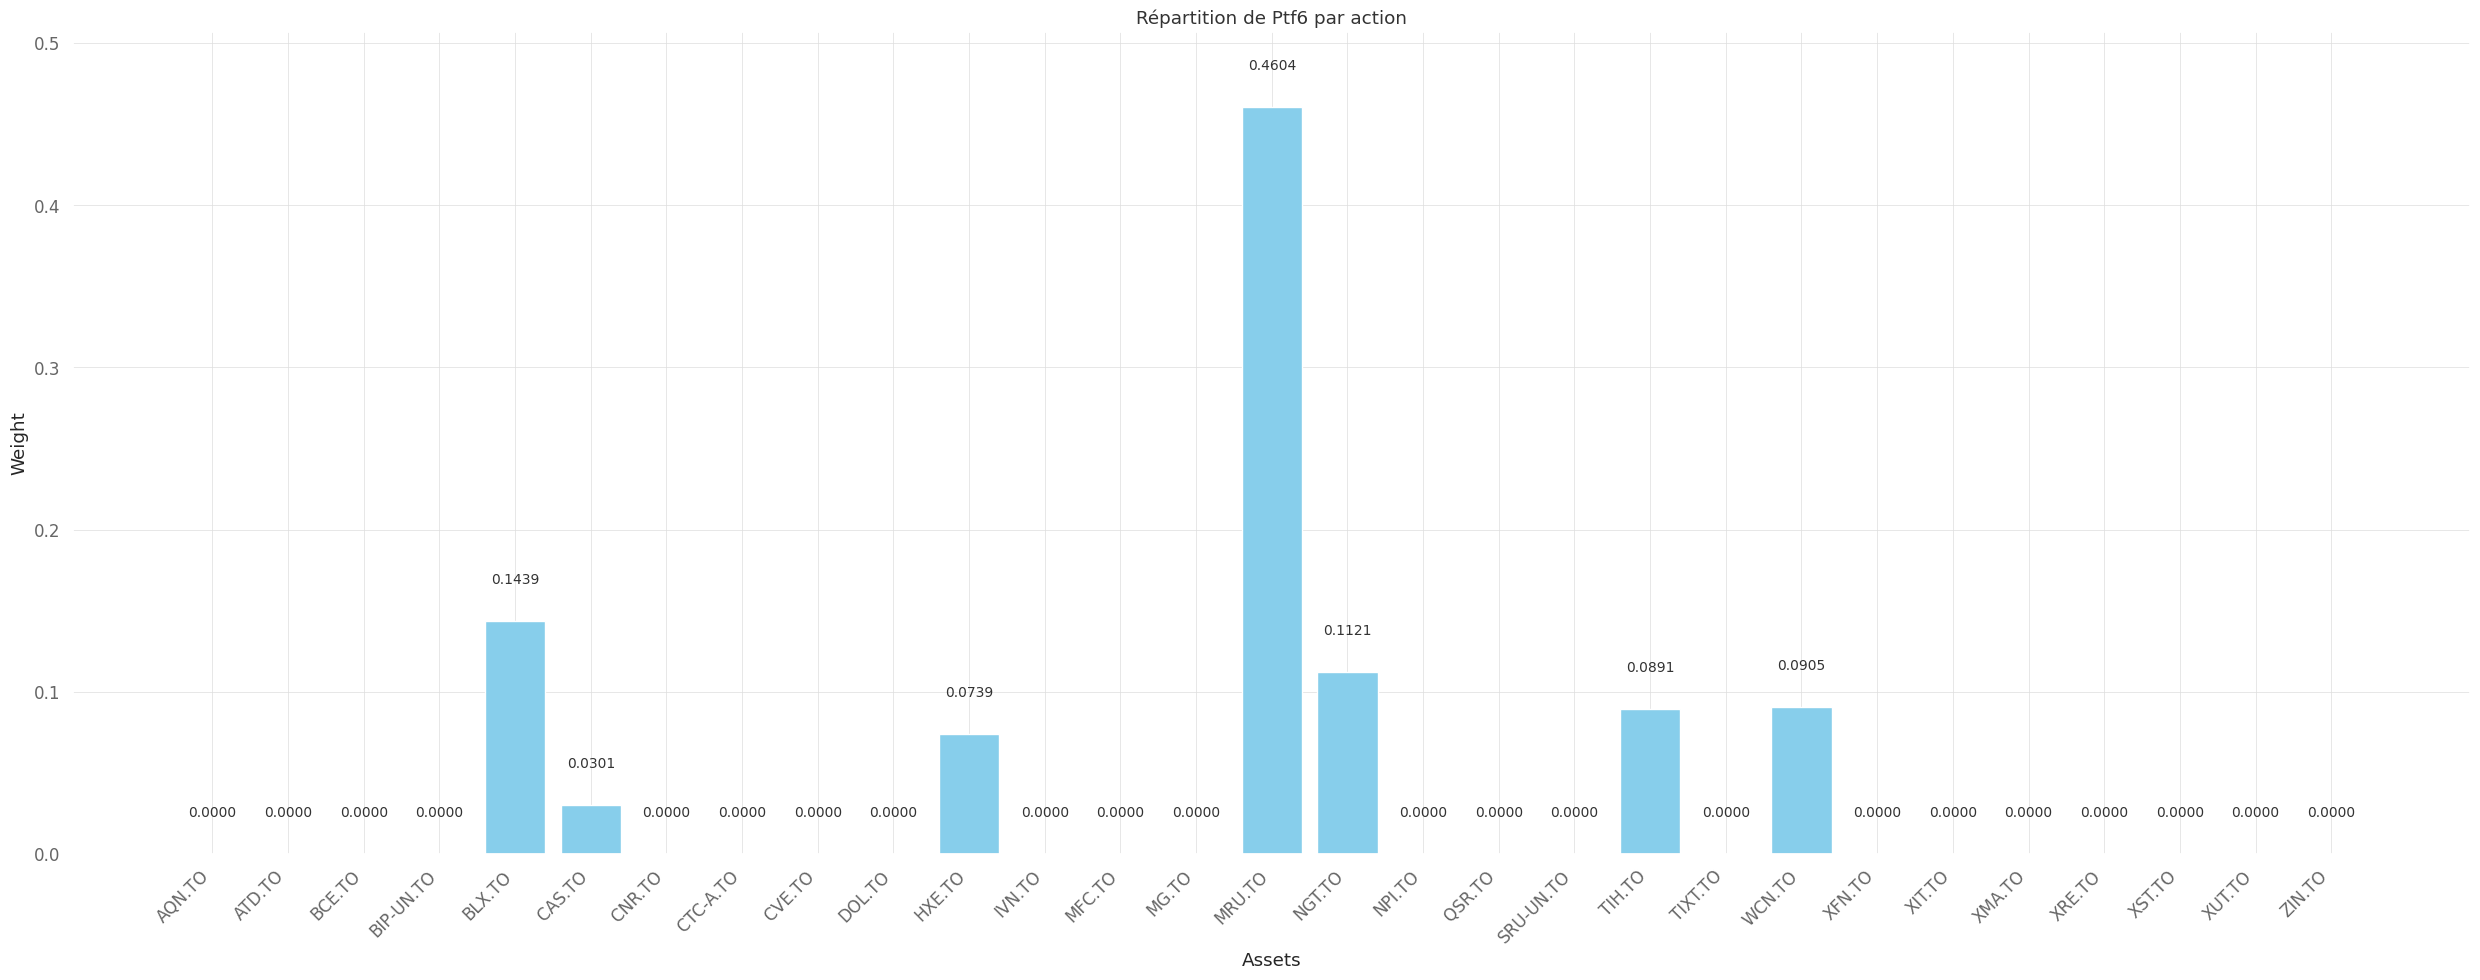

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

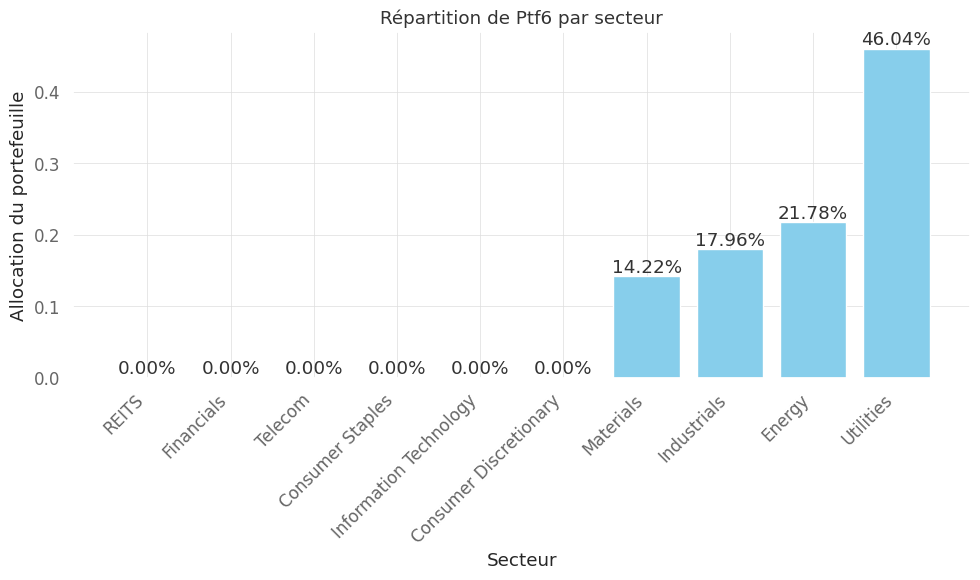

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Optimisation du portefeuille par Expected Shortfall
Port_ES = min_expected_shortfall_portfolio(monthly_return_train, percentile=5)

# Affichage et sauvegarde via votre fonction existante (même signature que pour min_variance)
show_and_save_optimized_portfolio(Port_ES, "Ptf6")

# 4 - Test des portefeuilles optimisés sur l'échantillon de test

## Préparation des tests d'optimisation

### Détermination du capital initial

In [ ]:
initial_capital = total_value_df.loc[split_date].round().item()

### Fonctions utilitaires pour tester les différents portefeuilles et les afficher

In [ ]:
def update_portfolio_values_with_rebalancing(monthly_returns, initial_weights, initial_capital):

    initial_weights = np.array(initial_weights)
    initial_portfolio_value = initial_weights * initial_capital

    portfolio_values = pd.DataFrame(index=[monthly_returns.index[0]], columns=monthly_returns.columns) # Initialiser le DataFrame avec la première date
    portfolio_values.iloc[0] = initial_portfolio_value

    for i in range(1, len(monthly_returns)):
        previous_values = portfolio_values.iloc[-1]  # Récupérer les valeurs du portefeuille de la dernière ligne
        monthly_returns_i = monthly_returns.iloc[i]
        current_values = previous_values + (previous_values * monthly_returns_i)

        # Créer une nouvelle ligne avec les valeurs actuelles du portefeuille
        new_row = pd.DataFrame([current_values], index=[monthly_returns.index[i]], columns=monthly_returns.columns)
        portfolio_values = pd.concat([portfolio_values, new_row]) # Ajouter la nouvelle ligne au DataFrame

        if i % 3 == 0:
            total_value = portfolio_values.iloc[-1].sum()
            rebalanced_values = initial_weights * total_value

            # Créer une nouvelle ligne avec les valeurs rééquilibrées
            rebalanced_row = pd.DataFrame([rebalanced_values], index=[monthly_returns.index[i]], columns=monthly_returns.columns)
            portfolio_values = pd.concat([portfolio_values, rebalanced_row])

    # Calcul de la valeur totale du portefeuille
    portfolio_values['Total Value'] = portfolio_values.sum(axis=1)
    return portfolio_values

def plot_portfolio_comparison(portfolio_values_list, portfolio_names, filename_prefix="4_portfolio_comparison", title_complement=''):

    plt.figure(figsize=(12, 6))

    for i, portfolio_values_df in enumerate(portfolio_values_list):
        plt.plot(portfolio_values_df.index, portfolio_values_df['Total Value'],
                 label=portfolio_names[i])

    plt.title('Portfolio Comparison' + title_complement)
    plt.xlabel('Date')
    plt.ylabel('Total Value')
    plt.legend()
    plt.grid(True)
    filename = f"figures/{filename_prefix}.png"

    plt.savefig(filename, dpi=300)
    files.download(filename)

    plt.show()
    plt.close()

def calculate_and_compare_portfolio_performance(portfolio_values_list, portfolio_names):

    performance_data = []

    for i, portfolio_values_df in enumerate(portfolio_values_list):
        # Calculer les rendements du portefeuille
        portfolio_returns = portfolio_values_df['Total Value'].pct_change().dropna()

        # Calculer le rendement annuel moyen
        mean_annual_return = portfolio_returns.mean() * 12

        # Calculer la volatilité annualisée
        volatility = portfolio_returns.std() * np.sqrt(12)

        # Calculer le ratio rendement/risque
        return_risk_ratio = mean_annual_return / volatility

        # Calculer le maximum drawdown
        maximum_drawdown = qs.stats.max_drawdown(portfolio_returns)

        # Ajouter les résultats à la liste
        performance_data.append([portfolio_names[i], mean_annual_return, volatility,
                                 return_risk_ratio, maximum_drawdown])

    # Créer un DataFrame pour les performances des portefeuilles
    performance_table = pd.DataFrame(performance_data,
                                     columns=['Portfolio', 'Mean Annual Return', 'Volatility',
                                              'Return-Risk Ratio', 'Maximum Drawdown'])

    return performance_table

def plot_performance_metrics(comparison_table, filename_prefix, title_complement=''):
    """
    Crée et sauvegarde un graphique pour chaque métrique de performance à partir d'une table comparée.

    Args:
        comparison_table (pd.DataFrame): DataFrame contenant les métriques de performance des portefeuilles.
        filename_prefix (str): Préfixe pour le nom du fichier de sauvegarde (chaque graphique aura ce préfixe suivi du nom de la métrique).
    """
    metrics = ['Mean Annual Return', 'Volatility', 'Return-Risk Ratio', 'Maximum Drawdown']

    # Boucle sur chaque métrique pour créer un graphique individuel
    for metric in metrics:
        plt.figure(figsize=(10, 6))

        # Graphique en barres pour la métrique courante
        plt.bar(comparison_table['Portfolio'], comparison_table[metric], color='skyblue')
        plt.title(metric+title_complement)
        plt.ylabel(metric)
        plt.xlabel('Portfolio')
        plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour une meilleure lisibilité

        # Ajouter les annotations de valeur au-dessus des barres
        for j, value in enumerate(comparison_table[metric]):
            plt.text(j, value + (0.05 * value), f"{value:.2f}", ha='center', fontsize=10)

        plt.tight_layout()

        # Construction du nom du fichier à partir du préfixe et du nom de la métrique
        filename = f"{filename_prefix}_{metric.replace(' ', '_').lower()}.png"
        plt.savefig(filename, dpi=300)
        files.download(filename)
        plt.show()
        plt.close()

## Benchmark : Portefeuille de PF

In [ ]:
benchmark = monthly_value_test.copy()
benchmark['Total Value'] = monthly_value_test.sum(axis=1)
benchmark

AQN.TO       ATD.TO       BCE.TO    BIP-UN.TO       BLX.TO  \
Date                                                                         
2023-04-30  682.824858  1195.173935  3183.063957  1354.865227  3713.542564   
2023-05-31  678.083058  1161.768494  2993.409683  1413.317558  3542.149857   
2023-06-30  657.696343  1200.652817  2999.330177  1403.462490  3406.167305   
2023-07-31  653.491911  1182.407822  2828.507362  1360.854401  3222.025146   
2023-08-31  614.450515  1251.482162  2842.411530  1256.475964  3110.680168   
2023-09-30  490.993704  1224.074295  2620.136238  1165.537159  2769.055714   
2023-10-31  426.260676  1339.596497  2601.438858   917.867743  2449.257179   
2023-11-30  511.146495  1373.490005  2699.978279  1049.798615  2942.027710   
2023-12-31  519.240448  1387.802719  2683.258675  1234.222858  3213.996178   
2024-01-31  495.017502  1401.141495  2790.239319  1242.793789  3094.711765   
2024-02-29  492.533123  1497.005447  2590.164940  1154.730133  2863.089455   
2024-03-31  541.391687  1378.118546  2417.526306  1263.452808  2746.953526   
2024-04-30  531.904702  1360.114426  2375.510025  1103.952946  2651.932846   
2024-05-31  542.024132  1418.048492  2448.514038  1188.423996  3335.716347   
2024-06-30  517.925975  1368.492462  2378.043587  1134.102806  3231.565926   
2024-07-31  555.288851  1520.572769  2499.333954  1316.682026  3303.892441   
2024-08-31  470.900368  1374.429199  2533.681625  1324.085419  3127.709717   
2024-09-30  481.830608  1338.926880  2576.941124  1445.924416  3487.294769   
2024-10-31  438.798385  1300.247314  2460.205902  1453.234741  3244.017426   
2024-11-30  453.142438  1466.785080  2077.117699  1519.820576  2937.359940   
2024-12-31  422.102377  1430.928589  1877.705307  1402.816814  2797.996189   
2025-01-31  428.056766  1377.618805  1950.401558  1465.157391  2518.294086   
2025-02-28  457.167290  1291.102570  1883.340607  1421.040005  2907.660007   
2025-03-31  495.129991  1277.460022  1915.739929  1327.110043  2834.160007   
2025-04-30  457.609995  1238.039978  1700.559982  1187.299976  2780.260082   

                 CAS.TO       CNR.TO     CTC-A.TO      CVE.TO       DOL.TO  \
Date                                                                         
2023-04-30  2080.417570  2012.889603  1309.610229    0.000000  1002.613953   
2023-05-31  2040.504009  1907.696045  1202.325439    0.000000   986.604767   
2023-06-30  2225.138535  2009.600327  1335.491211    0.000000  1071.908203   
2023-07-31  2287.952684  2002.334641  1347.966675    0.000000  1038.563324   
2023-08-31  2442.609457  1906.627655  1193.081909    0.000000  1047.530823   
2023-09-30  2358.050474  1852.416092  1087.021973    0.000000  1118.912659   
2023-10-31  2160.104815  1847.882278  1008.331604    0.000000  1132.304077   
2023-11-30  2383.730143  1983.013962  1064.040283    0.000000  1178.337708   
2023-12-31  2471.081760  2107.945557  1060.798706    0.000000  1141.750031   
2024-01-31  2855.429468  2110.856552  1090.129517    0.000000  1180.656738   
2024-02-29  2042.088238  2227.170013  1053.512085    0.000000  1256.160370   
2024-03-31  1942.949402  2268.424622  1030.626343    0.000000  1234.741699   
2024-04-30  1815.252804  2124.971161  1027.700684    0.000000  2635.910515   
2024-05-31  1937.423855  2206.490738  1051.269897    0.000000  2960.923264   
2024-06-30  1796.194912  2066.000443  1048.951782    0.000000  2867.046196   
2024-07-31  1935.434729  2042.613098  1109.195068    0.000000  2972.940216   
2024-08-31  1867.959835  2029.322098  1201.980103    0.000000  3135.334549   
2024-09-30  2101.706623  2034.799728  1268.087402    0.000000  3182.192276   
2024-10-31  2113.796778  1931.755844  1172.676025    0.000000  3330.269867   
2024-11-30  2468.797556  2008.717606  1221.745239  522.820724  3352.105408   
2024-12-31  2426.021421  1886.008087  1196.814941  517.966232  3224.310043   
2025-01-31  2617.495987  1961.593201  1308.959961  499.662689  3163.189972   
2025-02-28  2285.471041  1895.181442 

## Ptf1 : Portefeuille a variance minimale: Poids >=0 ; Somme des poids =1

In [ ]:
portfolio_1 = update_portfolio_values_with_rebalancing(monthly_return_test, Port_Min_Var.x, initial_capital)
portfolio_1

Ticker     AQN.TO ATD.TO        BCE.TO BIP-UN.TO       BLX.TO       CAS.TO  \
2023-04-30    0.0    0.0  10251.616365       0.0  8189.850116  4085.641102   
2023-05-31    0.0    0.0   9640.801476       0.0  7811.860484  4007.256605   
2023-06-30    0.0    0.0   9659.869466       0.0  7511.964442  4369.852276   
2023-07-31    0.0    0.0   9109.704597       0.0   7105.85716  4493.210239   
2023-07-31    0.0    0.0   8655.650503       0.0  6914.858862  3449.590796   
2023-08-31    0.0    0.0   8698.199309       0.0  6675.898961  3682.769823   
2023-09-30    0.0    0.0   8018.004071       0.0  5942.731223  3555.278598   
2023-10-31    0.0    0.0   7960.787325       0.0  5256.404572  3256.832074   
2023-10-31    0.0    0.0   7794.206728       0.0  6226.665396  3106.274194   
2023-11-30    0.0    0.0   8089.442042       0.0  7479.419593  3427.851917   
2023-12-31    0.0    0.0   8039.348205       0.0   8170.83602  3553.465301   
2024-01-31    0.0    0.0   8359.874384       0.0   7867.58321  4106.165039   
2024-01-31    0.0    0.0   8844.993281       0.0  7066.121738  3525.050763   
2024-02-29    0.0    0.0   8210.762186       0.0  6537.261033  2520.974439   
2024-03-31    0.0    0.0   7663.501761       0.0  6272.089129  2398.586745   
2024-04-30    0.0    0.0   7530.311134       0.0  6055.129444  2240.944262   
2024-04-30    0.0    0.0   8649.597335       0.0  6910.023085  3447.178389   
2024-05-31    0.0    0.0   8915.416174       0.0  8691.727241  3679.182111   
2024-06-30    0.0    0.0   8658.822423       0.0  8420.347136  3410.987313   
2024-07-31    0.0    0.0   9100.459303       0.0  8608.805109  3675.404746   
2024-07-31    0.0    0.0   9372.906094       0.0  7487.862726  3735.443175   
2024-08-31    0.0    0.0   9501.715412       0.0  7088.566419  3605.214743   
2024-09-30    0.0    0.0    9663.94552       0.0  7903.521372  4056.352583   
2024-10-31    0.0    0.0   9226.169579       0.0  7352.163425   4079.68692   
2024-10-31    0.0    0.0   8738.681215       0.0  6981.190752  3482.681548   
2024-11-30    0.0    0.0   7377.947268       0.0  6321.257674  4067.579147   
2024-12-31    0.0    0.0   6669.632034       0.0   6021.34408   3997.10139   
2025-01-31    0.0    0.0   6927.849999       0.0  5419.419529  4312.573976   
2025-01-31    0.0    0.0   8871.436007       0.0  7087.246403  3535.589149   
2025-02-28    0.0    0.0   8566.408083       0.0   8183.04067  3087.105636   
2025-03-31    0.0    0.0   8713.776975       0.0  7976.189289  2699.073517   
2025-04-30    0.0    0.0   7735.027178       0.0  7824.498486  2593.336582   
2025-04-30    0.0    0.0   8085.946549       0.0  6459.731609  3222.543099   

Ticker     CNR.TO CTC-A.TO CVE.TO DOL.TO  ...       TIXT.TO WCN.TO XFN.TO  \
2023-04-30    0.0      0.0    0.0    0.0  ...  15559.458856    0.0    0.0   
2023-05-31    0.0      0.0    0.0    0.0  ...   12181.98807    0.0    0.0   
2023-06-30    0.0      0.0    0.0    0.0  ...  11598.869089    0.0    0.0   
2023-07-31    0.0      0.0    0.0    0.0  ...   7101.348478    0.0    0.0   
2023-07-31    0.0      0.0    0.0    0.0  ...  13137.171064    0.0    0.0   
2023-08-31    0.0      0.0    0.0    0.0  ...  12677.903789    0.0    0.0   
2023-09-30    0.0      0.0    0.0    0.0  ...  11033.087315    0.0    0.0   
2023-10-31    0.0      0.0    0.0    0.0  ...   9484.396645    0.0    0.0   
2023-10-31    0.0      0.0    0.0    0.0  ...  11829.709051    0.0    0.0   
2023-11-30    0.0      0.0    0.0    0.0  ...  13295.100156    0.0    0.0   
2023-12-31    0.0      0.0    0.0    0.0  ...  15160.145114    0.0    0.0   
2024-01-31    0.0      0.0    0.0    0.0  ...  15466.544622    0.0    0.0   
2024-01-31    0.0      0.0    0.0    0.0  ...  13424.547323    0.0    0.0   
2024-02-29    0.0      0.0    0.0    0.0  ...  16164.958741    0.0    0.0   
2024-03-31    0.0      0.0    0.0    0.0  ...  13262.667178    0.0    0.0   
2024-04-30    0.0      0.0    0.0    0.0  ...  13389.858878    0.0    0.0   
2024-04-30    0.0      0.0    0.0    0

## Ptf2 : Portefeuille à variance minimale, 2% <= Poids <= 15 % ; Somme des poids = 1



In [ ]:
portfolio_2 = update_portfolio_values_with_rebalancing(monthly_return_test, Port_Min_Var_bounded.x, initial_capital)
portfolio_2

Ticker           AQN.TO       ATD.TO       BCE.TO    BIP-UN.TO       BLX.TO  \
2023-04-30       1625.7       1625.7   8694.19046       1625.7  3099.316441   
2023-05-31  1614.410512  1580.261236   8176.17059  1695.836832  2956.272372   
2023-06-30  1565.872908  1633.152487  8192.341771  1684.011756  2842.781561   
2023-07-31  1555.862807  1608.335272  7725.757967  1632.886397  2689.096822   
2023-07-31  1467.755701  1467.755701  7849.509514  1467.755701  2798.203467   
2023-08-31  1380.067957  1553.499601  7888.095552  1355.177863  2701.504686   
2023-09-30  1102.781528  1519.477453   7271.25006  1257.095402   2404.81714   
2023-10-31   957.389874  1662.878374  7219.362176   989.970427  2127.084557   
2023-10-31  1300.619453  1300.619453  6955.670319  1300.619453  2479.566496   
2023-11-30  1559.625626  1333.526792  7219.142868  1487.565622  2978.435014   
2023-12-31  1584.322139  1347.423062  7174.438355  1748.894949  3253.769065   
2024-01-31  1510.412356  1360.373731  7460.480862  1761.039965  3133.008519   
2024-01-31  1495.213697  1495.213697  7996.353977  1495.213697  2850.550774   
2024-02-29  1487.709562  1597.513925  7422.974645  1389.263711  2637.202583   
2024-03-31  1635.288173  1470.644994  6928.221519  1520.068704  2530.229337   
2024-04-30  1606.632479  1451.432083  6807.809964   1328.17333  2442.705428   
2024-04-30  1459.084281  1459.084281   7803.13504  1459.084281  2781.671834   
2024-05-31  1486.843202  1521.233968  8042.940457  1570.728878  3498.907682   
2024-06-30  1420.738802  1468.071952  7811.457347  1498.933069  3389.661969   
2024-07-31  1523.230064  1631.218509  8209.874994  1740.246316  3465.526873   
2024-07-31  1534.416569  1534.416569  8206.009656  1534.416569  2925.289106   
2024-08-31  1301.227868   1386.94246  8318.782631  1543.044232   2769.29571   
2024-09-30  1331.431143  1351.116915  8460.815616  1685.031266   3087.67479   
2024-10-31  1212.521215  1312.085198  8077.541362  1693.550472  2872.275356   
2024-10-31  1440.794776  1440.794776  7705.323367  1440.794776    2746.8038   
2024-11-30  1487.893484  1625.334086  6505.497579  1506.810623  2487.147997   
2024-12-31  1385.973424  1585.601764  5880.941333  1390.808436  2369.144661   
2025-01-31  1405.524664  1526.529573  6108.624764  1452.615365  2132.312765   
2025-01-31  1457.683586  1457.683586  7795.644168  1457.683586  2779.001478   
2025-02-28  1556.815142  1366.139179  7527.605358  1413.791244   3208.67666   
2025-03-31  1686.091467   1351.70375  7657.103608  1320.340421  3127.567543   
2025-04-30  1558.322706  1309.992683  6797.041591  1181.243529  3068.087607   
2025-04-30  1292.701782  1292.701782  6913.326875  1292.701782   2464.47185   

Ticker           CAS.TO       CNR.TO     CTC-A.TO       CVE.TO       DOL.TO  \
2023-04-30  5751.172685       1625.7       1625.7       1625.7       1625.7   
2023-05-31  5640.834364  1540.740961  1492.520769  1550.634826   1599.74172   
2023-06-30  6151.243935  1623.043433   1657.82766  1618.573111  1738.057965   
2023-07-31  6324.889374  1617.175339  1673.314223   1804.16968  1683.990524   
2023-07-31  5192.419571  1467.755701  1467.755701  1467.755701  1467.755701   
2023-08-31  5543.407098  1397.600358  1299.106875  1576.608475  1480.429071   
2023-09-30  5351.503777   1357.86208  1183.621767  1663.415184  1581.309869   
2023-10-31  4902.273806  1354.538694  1097.938464  1554.010963   1600.23537   
2023-10-31  4601.148471  1300.619453  1300.619453  1300.619453  1300.619453   
2023-11-30  5077.483383  1395.730975   1372.47656  1184.932113  1353.495916   
2023-12-31  5263.547392  1483.663233  1368.295338  1093.967023  1311.469533   
2024-01-31   6082.23029  1485.712118  1406.128351  1079.103576  1356.159667   
2024-01-31  5289.556604  1495.213697  1495.213697  1495.213697  1495.213697   
2024-02-29  3782.878003  1577.603701  1444.989495  1623.590422  1590.833415   
2024-03-31  3599.227701  1606.826177  1413.599578  1869.608254  1563.708266   
2024-04-30   3362.67541  1505.211703  1409.586765

## Ptf3: maximisation ratio rendement / risque: poids >=0 ; somme des poids =1


In [ ]:
portfolio_3 = update_portfolio_values_with_rebalancing(monthly_return_test, Port_Max_Sharpe.x, initial_capital)
portfolio_3

Ticker     AQN.TO ATD.TO BCE.TO BIP-UN.TO        BLX.TO CAS.TO CNR.TO  \
2023-04-30    0.0    0.0    0.0       0.0  18115.724212    0.0    0.0   
2023-05-31    0.0    0.0    0.0       0.0  17279.621495    0.0    0.0   
2023-06-30    0.0    0.0    0.0       0.0  16616.259662    0.0    0.0   
2023-07-31    0.0    0.0    0.0       0.0  15717.961474    0.0    0.0   
2023-07-31    0.0    0.0    0.0       0.0  17408.106774    0.0    0.0   
2023-08-31    0.0    0.0    0.0       0.0  16806.526965    0.0    0.0   
2023-09-30    0.0    0.0    0.0       0.0  14960.782531    0.0    0.0   
2023-10-31    0.0    0.0    0.0       0.0  13232.960189    0.0    0.0   
2023-10-31    0.0    0.0    0.0       0.0  16033.487872    0.0    0.0   
2023-11-30    0.0    0.0    0.0       0.0  19259.294616    0.0    0.0   
2023-12-31    0.0    0.0    0.0       0.0  21039.672425    0.0    0.0   
2024-01-31    0.0    0.0    0.0       0.0  20258.804986    0.0    0.0   
2024-01-31    0.0    0.0    0.0       0.0  17734.922849    0.0    0.0   
2024-02-29    0.0    0.0    0.0       0.0  16407.560523    0.0    0.0   
2024-03-31    0.0    0.0    0.0       0.0  15742.018172    0.0    0.0   
2024-04-30    0.0    0.0    0.0       0.0  15197.481379    0.0    0.0   
2024-04-30    0.0    0.0    0.0       0.0  18293.387209    0.0    0.0   
2024-05-31    0.0    0.0    0.0       0.0  23010.217186    0.0    0.0   
2024-06-30    0.0    0.0    0.0       0.0  22291.773661    0.0    0.0   
2024-07-31    0.0    0.0    0.0       0.0  22790.691629    0.0    0.0   
2024-07-31    0.0    0.0    0.0       0.0  20742.743835    0.0    0.0   
2024-08-31    0.0    0.0    0.0       0.0  19636.620323    0.0    0.0   
2024-09-30    0.0    0.0    0.0       0.0  21894.194007    0.0    0.0   
2024-10-31    0.0    0.0    0.0       0.0  20366.832051    0.0    0.0   
2024-10-31    0.0    0.0    0.0       0.0  20631.127444    0.0    0.0   
2024-11-30    0.0    0.0    0.0       0.0  18680.863668    0.0    0.0   
2024-12-31    0.0    0.0    0.0       0.0  17794.545588    0.0    0.0   
2025-01-31    0.0    0.0    0.0       0.0  16015.711208    0.0    0.0   
2025-01-31    0.0    0.0    0.0       0.0  20137.156728    0.0    0.0   
2025-02-28    0.0    0.0    0.0       0.0  23250.662263    0.0    0.0   
2025-03-31    0.0    0.0    0.0       0.0   22662.93066    0.0    0.0   
2025-04-30    0.0    0.0    0.0       0.0  22231.928083    0.0    0.0   
2025-04-30    0.0    0.0    0.0       0.0  20221.417711    0.0    0.0   

Ticker     CTC-A.TO CVE.TO DOL.TO  ... TIXT.TO WCN.TO XFN.TO XIT.TO XMA.TO  \
2023-04-30      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2023-05-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2023-06-30      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2023-07-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2023-07-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2023-08-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2023-09-30      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2023-10-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2023-10-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2023-11-30      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2023-12-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2024-01-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2024-01-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2024-02-29      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2024-03-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2024-04-30      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2024-04-30      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2024-05-31      0.0    0.0    0.0  ...     0.0    0.0    0.0    0.0    0.0   
2024-06-30      0.0    0.0    0.0  

## PTF4: maximisation ratio rendement / risque : 0.02 <= poids <= 0.15 ; somme des poids = 1

In [ ]:
portfolio_4 = update_portfolio_values_with_rebalancing(monthly_return_test, Port_Max_Sharpe_bounded.x, initial_capital)
portfolio_4

Ticker           AQN.TO       ATD.TO       BCE.TO    BIP-UN.TO        BLX.TO  \
2023-04-30       1625.7       1625.7       1625.7       1625.7      12192.75   
2023-05-31  1614.410512  1580.261236  1528.837054  1695.836832  11630.012829   
2023-06-30  1565.872908  1633.152487  1531.860853  1684.011756  11183.538545   
2023-07-31  1555.862807  1608.335272  1444.615779  1632.886397  10578.940842   
2023-07-31  1599.061898  1599.061898  1599.061898  1599.061898  11992.964238   
2023-08-31  1503.529562  1692.476492  1606.922449  1476.412788  11578.517956   
2023-09-30  1201.436944  1655.410705  1481.261842  1369.555818  10306.929536   
2023-10-31  1043.038475  1811.640348  1470.691508  1078.533702   9116.581164   
2023-10-31  1403.876374  1403.876374  1403.876374  1403.876374  10529.072804   
2023-11-30  1683.445196  1439.396246  1457.053547  1605.664306  12647.436216   
2023-12-31  1710.102379  1454.395748  1448.030749  1887.740718  13816.597144   
2024-01-31  1630.324855  1468.374578  1505.763261  1900.849934  13303.807277   
2024-01-31  1626.422334  1626.422334  1626.422334  1626.422334  12198.167502   
2024-02-29  1618.259693  1737.699656  1509.799564  1511.174979   11285.20114   
2024-03-31  1778.788686  1599.697667  1409.169009  1653.458428  10827.437825   
2024-04-30  1747.618385  1578.798777  1384.677842  1444.723769  10452.902731   
2024-04-30  1679.975634  1679.975634  1679.975634  1679.975634  12599.817254   
2024-05-31  1711.936989  1751.534187  1731.604531  1808.522151  15848.597539   
2024-06-30  1635.825017  1690.323952  1681.767385  1725.857146  15353.759868   
2024-07-31  1753.832473  1878.169332  1767.544695  2003.702902  15697.396351   
2024-07-31   1846.15967   1846.15967   1846.15967   1846.15967  13846.197529   
2024-08-31  1565.594676  1668.723661  1871.530944  1856.540191  13107.837899   
2024-09-30  1601.934265  1625.619541  1903.485034  2027.374332  14614.813612   
2024-10-31  1458.865742   1578.65786  1817.257318   2037.62436  13595.268873   
2024-10-31  1834.943694  1834.943694  1834.943694  1834.943694  13762.077702   
2024-11-30  1894.926891  2069.966231  1549.217494   1919.01907  12461.146297   
2024-12-31  1765.125219  2019.364594  1400.485833  1771.282914  11869.924207   
2025-01-31  1790.024965  1944.132405  1454.706306  1849.997965  10683.345479   
2025-01-31  1774.979551  1774.979551  1774.979551  1774.979551  13312.346636   
2025-02-28  1895.689208  1663.508549  1713.950162  1721.533104  15370.634481   
2025-03-31  2053.105287  1645.930942  1743.435441  1607.740713  14982.094683   
2025-04-30  1897.524926  1595.140569  1547.609097  1438.366412  14697.165892   
2025-04-30  1686.965226  1686.965226  1686.965226  1686.965226  12652.239195   

Ticker           CAS.TO       CNR.TO     CTC-A.TO       CVE.TO       DOL.TO  \
2023-04-30       1625.7       1625.7       1625.7       1625.7  3858.949075   
2023-05-31   1594.51036  1540.740961  1492.520769  1550.634826  3797.331508   
2023-06-30  1738.789254  1623.043433   1657.82766  1618.573111  4125.654903   
2023-07-31  1787.874094  1617.175339  1673.314223   1804.16968  3997.314188   
2023-07-31  1599.061898  1599.061898  1599.061898  1599.061898  3795.717804   
2023-08-31  1707.152312  1522.630421  1415.325659  1717.652699  3828.492016   
2023-09-30  1648.053604  1479.337136  1289.509193  1812.225181   4089.37674   
2023-10-31  1509.708365  1475.716438  1196.160617  1693.033601  4138.319394   
2023-10-31  1403.876374  1403.876374  1403.876374  1403.876374  3332.402925   
2023-11-30  1549.212986  1506.538854  1481.438258   1279.00455  3467.881201   
2023-12-31  1605.983783  1601.452105  1476.925086   1180.81769  3360.202633   
2024-01-31  1855.775674  1603.663652  1517.761684  1164.774225  3474.706174   
2024-01-31  1626.422334  1626.422334  1626.422334  1626.422334   3860.66369   
2024-02-29  1163.151797  1716.042261  1571.790836  1766.064428  4107.555203   
2024-03-31  1106.683368  1747.829081  1537.646377  2033.670923  4037.517671   
2024-04-30   10

## PTF5: Portefeuille équipondéré

In [ ]:
portfolio_5 = update_portfolio_values_with_rebalancing(monthly_return_test, Port_Equal_weights.x, initial_capital)
portfolio_5

Ticker           AQN.TO       ATD.TO       BCE.TO    BIP-UN.TO       BLX.TO  \
2023-04-30  2802.931034  2802.931034  2802.931034  2802.931034  2802.931034   
2023-05-31    2783.4664  2724.588339  2635.925955  2923.856608  2673.566168   
2023-06-30  2699.780876   2815.78015  2641.139402  2903.468545  2570.928401   
2023-07-31  2682.522081  2772.991848  2490.716861  2815.321375  2431.940424   
2023-07-31  2759.656883  2759.656883  2759.656883  2759.656883  2759.656883   
2023-08-31  2594.787424  2920.871547    2773.2226  2547.989366  2664.290173   
2023-09-30  2073.436766  2856.903508  2556.357851  2363.575884   2371.68964   
2023-10-31  1800.073099   3126.52422  2538.115596   1861.33067  2097.782955   
2023-10-31  2457.955533  2457.955533  2457.955533  2457.955533  2457.955533   
2023-11-30   2947.43434  2520.144959  2551.059976  2811.252856  2952.476101   
2023-12-31  2994.106662  2546.406609  2535.262547  3305.122038  3225.410445   
2024-01-31  2854.429402   2570.88123  2636.342634  3328.074109  3105.702403   
2024-01-31  2806.972533  2806.972533  2806.972533  2806.972533  2806.972533   
2024-02-29  2792.884982   2999.02129  2605.698298  2608.072068  2596.885936   
2024-03-31  3069.935084  2760.849578  2432.024341   2853.63297  2491.548061   
2024-04-30  3016.139599   2724.78108  2389.756086  2493.386775  2405.362187   
2024-04-30  2850.303555  2850.303555  2850.303555  2850.303555  2850.303555   
2024-05-31  2904.530273   2971.71222  2937.898891   3068.39993  3585.235643   
2024-06-30  2775.396124  2867.860863    2853.3435  2928.147683   3473.29453   
2024-07-31  2975.611569  3186.565695  2998.876191  3399.550202  3551.031235   
2024-07-31   3052.55334   3052.55334   3052.55334   3052.55334   3052.55334   
2024-08-31  2588.650015  2759.169787  3094.503757  3069.717129  2889.773476   
2024-09-30  2648.736115  2687.898799  3147.338604  3352.184748  3222.003588   
2024-10-31  2412.177866  2610.249482  3004.764423  3369.132772  2997.233235   
2024-10-31  3002.473561  3002.473561  3002.473561  3002.473561  3002.473561   
2024-11-30  3100.622602  3387.035199  2534.946757  3140.044045  2718.649255   
2024-12-31  2888.231295  3304.236977  2291.580772  2898.306981  2589.662286   
2025-01-31  2928.974143  3181.136383  2380.300407  3027.106498  2330.786313   
2025-01-31  3012.266406  3012.266406  3012.266406  3012.266406  3012.266406   
2025-02-28  3217.119269  2823.092196  2908.695195  2921.563987  3478.007834   
2025-03-31  3484.265539  2793.261746  2958.733809  2728.450216  3390.090548   
2025-04-30  3220.234614  2707.066876  2626.402591  2441.009993  3325.617961   
2025-04-30  2774.643271  2774.643271  2774.643271  2774.643271  2774.643271   

Ticker           CAS.TO       CNR.TO     CTC-A.TO       CVE.TO       DOL.TO  \
2023-04-30  2802.931034  2802.931034  2802.931034  2802.931034  2802.931034   
2023-05-31  2749.155792  2656.449932  2573.311671   2673.50832   2758.17538   
2023-06-30  2997.912508  2798.350746  2858.323551  2790.643294  2996.651663   
2023-07-31  3082.541542  2788.233343  2885.024522  3110.637378  2903.431938   
2023-07-31  2759.656883  2759.656883  2759.656883  2759.656883  2759.656883   
2023-08-31  2946.199039  2627.751638  2442.565357  2964.320579  2783.485203   
2023-09-30  2844.206642  2553.036198  2225.431626  3127.533524  2973.160084   
2023-10-31  2605.450786  2546.787607  2064.330894  2921.833004  3008.743586   
2023-10-31  2457.955533  2457.955533  2457.955533  2457.955533  2457.955533   
2023-11-30  2712.415922   2637.70057  2593.753574  2239.325605  2557.883299   
2023-12-31  2811.812207  2803.877987  2585.851756   2067.41664   2478.46039   
2024-01-31  3249.156528   2807.75004   2657.34989  2039.327183  2562.917348   
2024-01-31  2806.972533  2806.972533  2806.972533  2806.972533  2806.972533   
2024-02-29  2007.433788  2961.643722  2712.686374  3047.974834  2986.479932   
2024-03-31  1909.977349   3016.50323  2653.757918  3509.825403  2935.557748   
2024-04-30  1784.447775  2825.741842  2646.224643

## PTF6: Minimisation de l'expected shortfall (5% pires cas)

In [ ]:
portfolio_6 = update_portfolio_values_with_rebalancing(monthly_return_test, Port_ES.x, initial_capital)
portfolio_6

Ticker     AQN.TO ATD.TO BCE.TO BIP-UN.TO        BLX.TO       CAS.TO CNR.TO  \
2023-04-30    0.0    0.0    0.0       0.0  11694.107999  2446.634711    0.0   
2023-05-31    0.0    0.0    0.0       0.0  11154.384864  2399.695143    0.0   
2023-06-30    0.0    0.0    0.0       0.0   10726.16986  2616.830993    0.0   
2023-07-31    0.0    0.0    0.0       0.0  10146.298147  2690.702355    0.0   
2023-07-31    0.0    0.0    0.0       0.0  11002.278114  2301.890451    0.0   
2023-08-31    0.0    0.0    0.0       0.0   10622.06742  2457.489363    0.0   
2023-09-30    0.0    0.0    0.0       0.0   9455.519337  2372.415263    0.0   
2023-10-31    0.0    0.0    0.0       0.0   8363.500418  2173.263757    0.0   
2023-10-31    0.0    0.0    0.0       0.0  10494.654831  2195.685793    0.0   
2023-11-30    0.0    0.0    0.0       0.0  12606.093627   2422.99465    0.0   
2023-12-31    0.0    0.0    0.0       0.0  13771.432742  2511.785112    0.0   
2024-01-31    0.0    0.0    0.0       0.0  13260.319109  2902.463748    0.0   
2024-01-31    0.0    0.0    0.0       0.0  11108.225549  2324.056714    0.0   
2024-02-29    0.0    0.0    0.0       0.0  10276.835402  1662.071829    0.0   
2024-03-31    0.0    0.0    0.0       0.0   9859.974579  1581.381944    0.0   
2024-04-30    0.0    0.0    0.0       0.0    9518.90529  1477.448669    0.0   
2024-04-30    0.0    0.0    0.0       0.0  11367.025613  2378.202718    0.0   
2024-05-31    0.0    0.0    0.0       0.0  14297.938656  2538.261706    0.0   
2024-06-30    0.0    0.0    0.0       0.0  13851.516905  2353.234554    0.0   
2024-07-31    0.0    0.0    0.0       0.0  14161.531297  2535.655708    0.0   
2024-07-31    0.0    0.0    0.0       0.0   13094.69898   2739.66557    0.0   
2024-08-31    0.0    0.0    0.0       0.0  12396.413616  2644.152846    0.0   
2024-09-30    0.0    0.0    0.0       0.0  13821.598637  2975.028395    0.0   
2024-10-31    0.0    0.0    0.0       0.0  12857.389408  2992.142369    0.0   
2024-10-31    0.0    0.0    0.0       0.0  12994.572511  2718.717167    0.0   
2024-11-30    0.0    0.0    0.0       0.0  11766.193493  3175.311064    0.0   
2024-12-31    0.0    0.0    0.0       0.0  11207.943607  3120.293377    0.0   
2025-01-31    0.0    0.0    0.0       0.0  10087.539867  3366.563592    0.0   
2025-01-31    0.0    0.0    0.0       0.0  13294.383476  2781.443449    0.0   
2025-02-28    0.0    0.0    0.0       0.0  15349.893948  2428.622044    0.0   
2025-03-31    0.0    0.0    0.0       0.0   14961.87843  2123.357674    0.0   
2025-04-30    0.0    0.0    0.0       0.0  14677.334111  2040.174563    0.0   
2025-04-30    0.0    0.0    0.0       0.0  13821.162215  2891.655801    0.0   

Ticker     CTC-A.TO CVE.TO DOL.TO  ... TIXT.TO       WCN.TO XFN.TO XIT.TO  \
2023-04-30      0.0    0.0    0.0  ...     0.0  7355.500897    0.0    0.0   
2023-05-31      0.0    0.0    0.0  ...     0.0  7253.791691    0.0    0.0   
2023-06-30      0.0    0.0    0.0  ...     0.0  7402.761605    0.0    0.0   
2023-07-31      0.0    0.0    0.0  ...     0.0  7281.551189    0.0    0.0   
2023-07-31      0.0    0.0    0.0  ...     0.0  6920.345404    0.0    0.0   
2023-08-31      0.0    0.0    0.0  ...     0.0  6895.985139    0.0    0.0   
2023-09-30      0.0    0.0    0.0  ...     0.0  6789.141622    0.0    0.0   
2023-10-31      0.0    0.0    0.0  ...     0.0  6684.533054    0.0    0.0   
2023-10-31      0.0    0.0    0.0  ...     0.0  6601.054397    0.0    0.0   
2023-11-30      0.0    0.0    0.0  ...     0.0  6756.559711    0.0    0.0   
2023-12-31      0.0    0.0    0.0  ...     0.0  7273.806485    0.0    0.0   
2024-01-31      0.0    0.0    0.0  ...     0.0  7672.678494    0.0    0.0   
2024-01-31      0.0    0.0    0.0  ...     0.0  6986.985497    0.0    0.0   
2024-02-29      0.0    0.0    0.0  ...     0.0  7559.776924    0.0    0.0   
2024-03-31      0.0    0.0    0.0  ...     0.0  7795.789556    0.0    0.0   
2024-04-30      0.0    0.0    0.0  ...     0.0  7472.066747    0.0    0.0   
2024

## Comparaison des rendements des portefeuilles

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

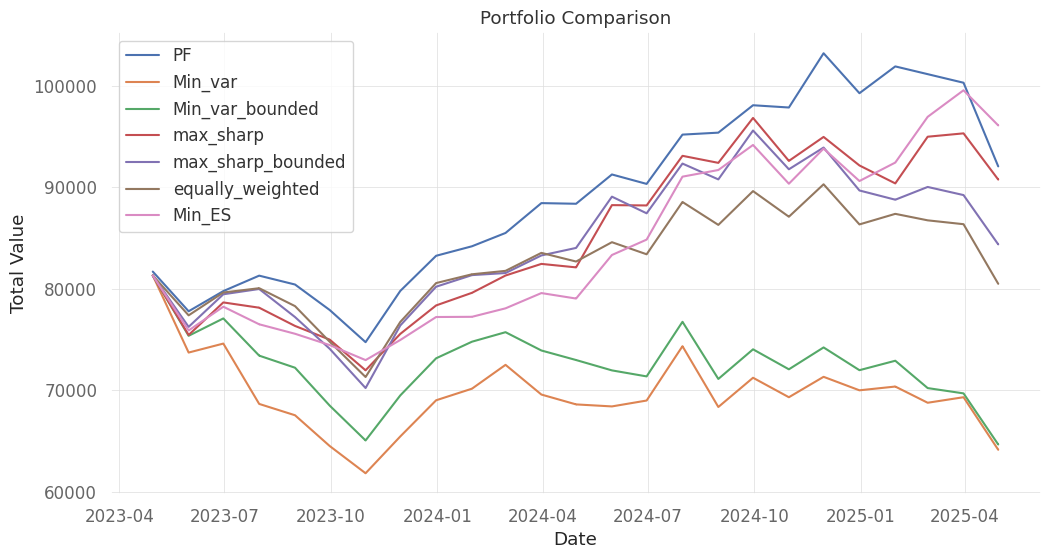

In [ ]:
portfolio_values_list = [benchmark, portfolio_1, portfolio_2, portfolio_3, portfolio_4, portfolio_5, portfolio_6]
portfolio_names = ['PF', 'Min_var', 'Min_var_bounded', 'max_sharp', 'max_sharp_bounded', 'equally_weighted', 'Min_ES']

plot_portfolio_comparison(portfolio_values_list, portfolio_names)

## Comparaison des métriques des portefeuilles

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

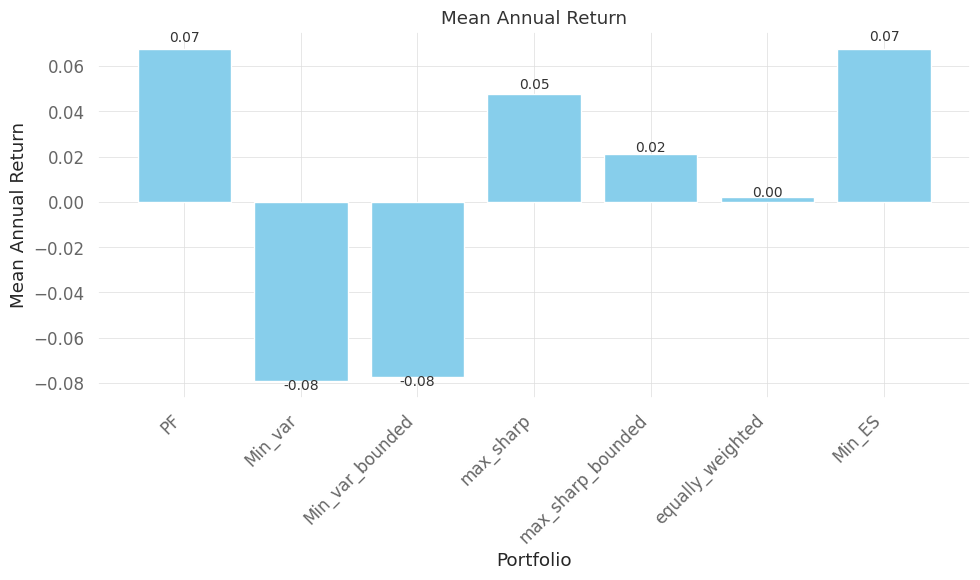

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

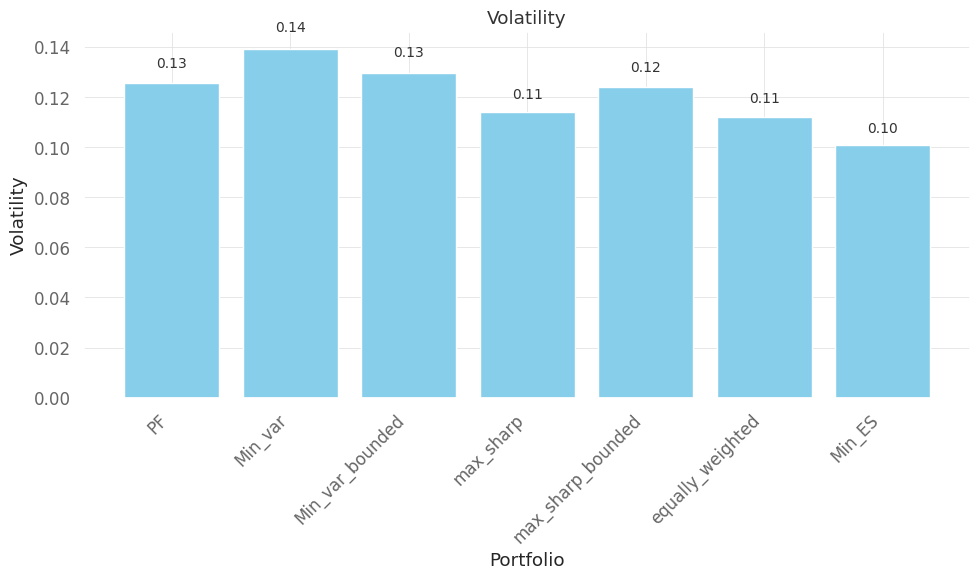

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

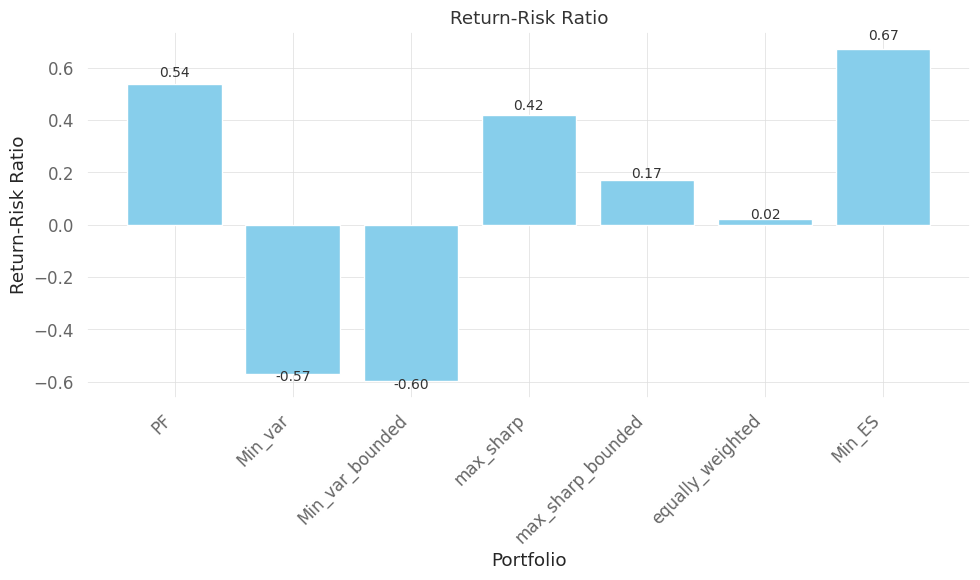

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

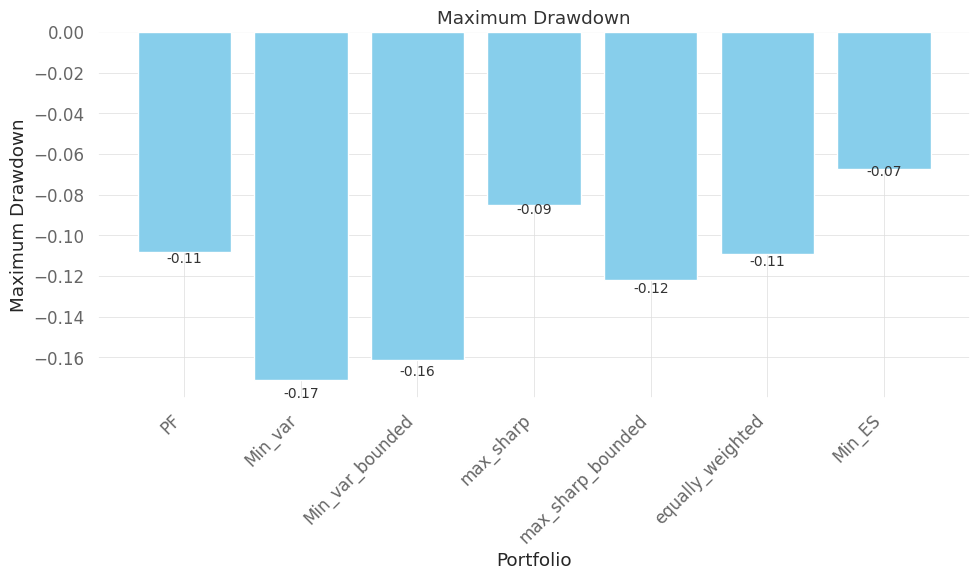

Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF            0.067487    0.125531           0.537613   
1            Min_var           -0.079141    0.139069          -0.569075   
2    Min_var_bounded           -0.077468    0.129613          -0.597683   
3          max_sharp            0.047571    0.113905           0.417632   
4  max_sharp_bounded            0.021295    0.124175           0.171487   
5   equally_weighted            0.002264    0.112072           0.020203   
6             Min_ES            0.067731    0.100717           0.672483   

   Maximum Drawdown  
0         -0.108024  
1         -0.171305  
2         -0.161157  
3         -0.085049  
4         -0.122063  
5         -0.109326  
6         -0.067248

In [ ]:
performance_table = calculate_and_compare_portfolio_performance(portfolio_values_list, portfolio_names)
plot_performance_metrics(performance_table, 'figures/4_performance_comparison')
performance_table

## Comparaison par secteur

In [ ]:
def calculate_and_compare_portfolio_performance_by_sector(portfolio_values_list, portfolio_names, sector_name):
    performance_data = []

    for i, portfolio_values_df in enumerate(portfolio_values_list):
        # Calculate portfolio returns
        sector_returns_df = portfolio_values_df[secteurs_dict[sector_name]].copy()

        # Calculer la somme par ligne pour obtenir la colonne "Total Value"
        total_value = sector_returns_df.sum(axis=1)

        # Vérifier la présence de 0 et afficher un warning le cas échéant
        if (total_value == 0).any():
            print(f"Attention : Le portefeuille {portfolio_names[i]} comporte des lignes avec une 'Total Value' nulle. Ces lignes seront supprimées.")

        # Supprimer les lignes où la valeur totale est nulle
        sector_returns_df = sector_returns_df.loc[total_value != 0].copy()

        sector_returns_df['Total Value'] = sector_returns_df.sum(axis=1)

        sector_returns = sector_returns_df['Total Value'].pct_change().dropna()

        # Calculer les rendements annuels moyens
        mean_annual_return = sector_returns.mean() * 12

        # Calculer la volatilité annualisée
        volatility = sector_returns.std() * np.sqrt(12)

        # Calculer le ratio rendement/risque (Sharpe Ratio en supposant un taux sans risque de 0)
        return_risk_ratio = mean_annual_return / volatility

        # Calculer le maximum drawdown
        maximum_drawdown = qs.stats.max_drawdown(sector_returns)

        # Ajouter les données de performance pour le portefeuille actuel
        performance_data.append([portfolio_names[i], mean_annual_return, volatility,
                                 return_risk_ratio, maximum_drawdown])

    # Créer une table de performance
    performance_table = pd.DataFrame(performance_data,
                                     columns=['Portfolio', 'Mean Annual Return', 'Volatility',
                                              'Return-Risk Ratio', 'Maximum Drawdown'])

    return performance_table

Attention : Le portefeuille max_sharp comporte des lignes avec une 'Total Value' nulle. Ces lignes seront supprimées.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

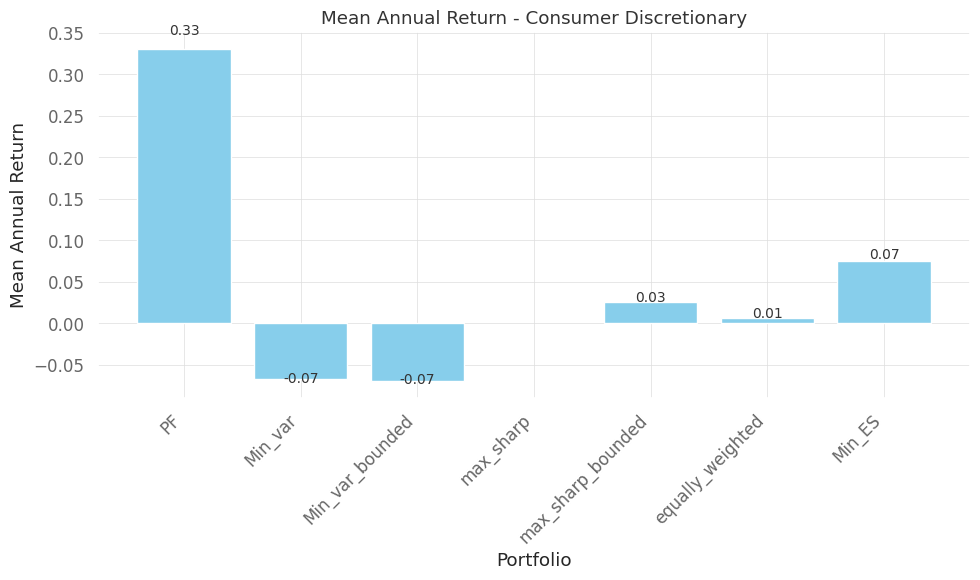

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

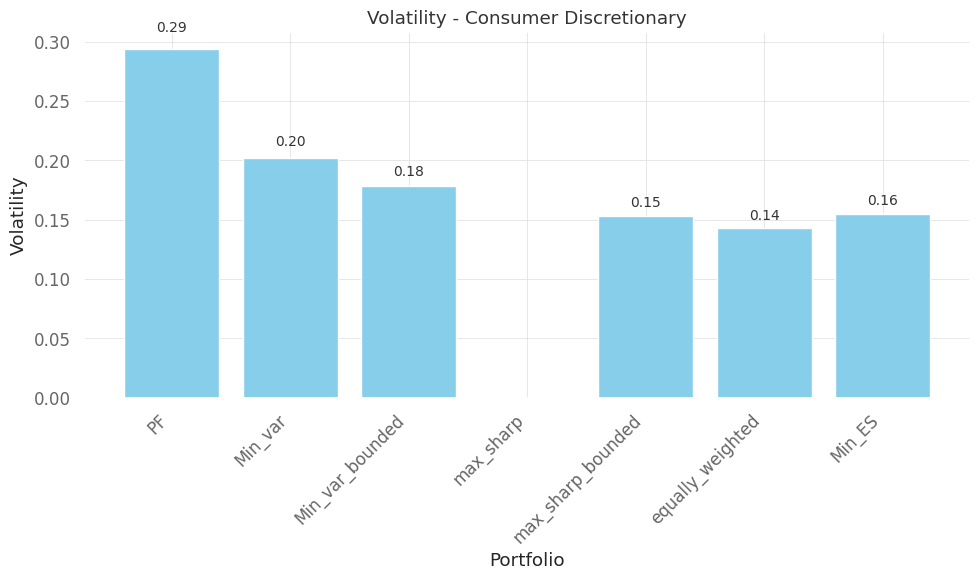

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

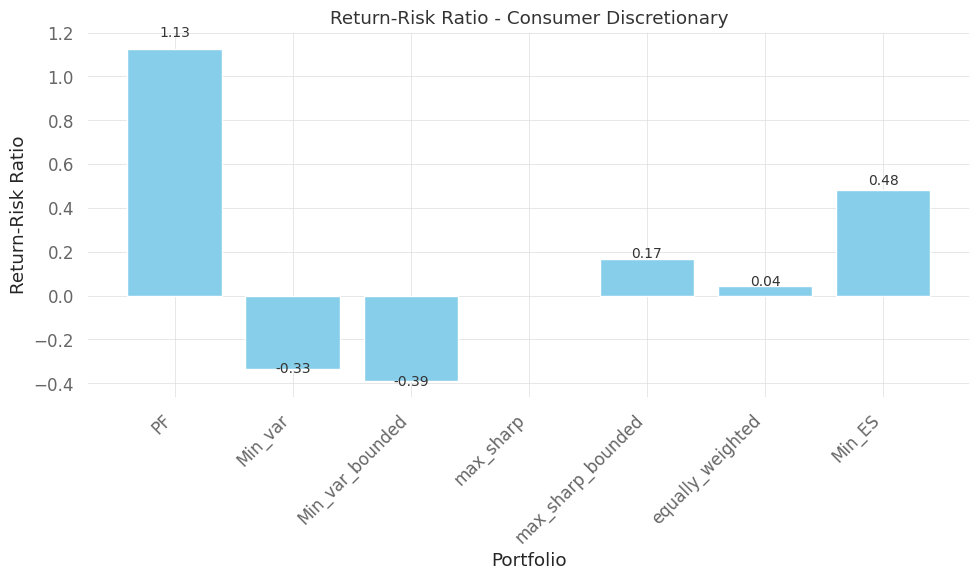

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

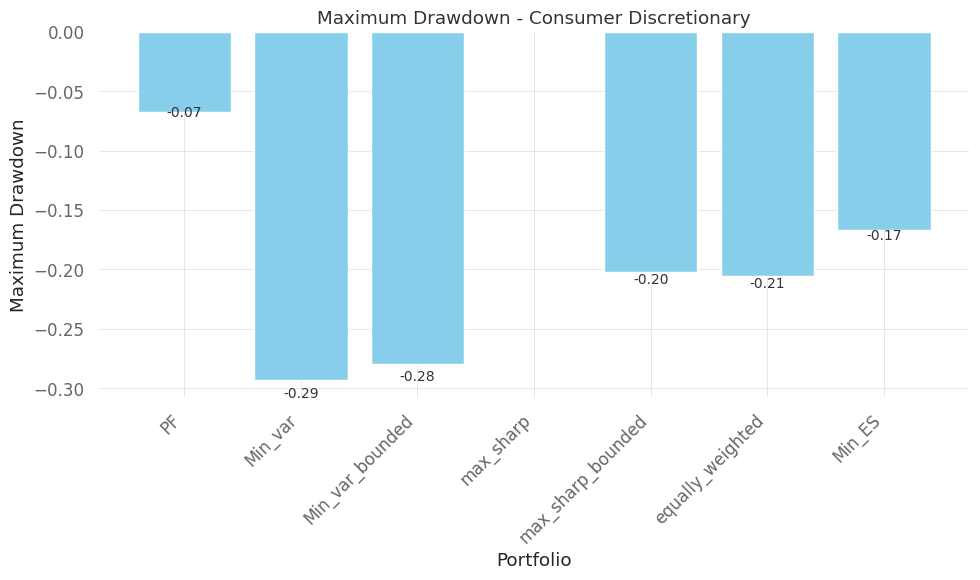

           Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF            0.330848    0.293555           1.127040   
1            Min_var           -0.067447    0.202266          -0.333456   
2    Min_var_bounded           -0.069481    0.178276          -0.389736   
3          max_sharp                 NaN         NaN                NaN   
4  max_sharp_bounded            0.025419    0.153229           0.165891   
5   equally_weighted            0.006183    0.143254           0.043161   
6             Min_ES            0.074577    0.155154           0.480666   

   Maximum Drawdown  
0         -0.067537  
1         -0.293251  
2         -0.279300  
3               NaN  
4         -0.201991  
5         -0.205199  
6         -0.166880  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

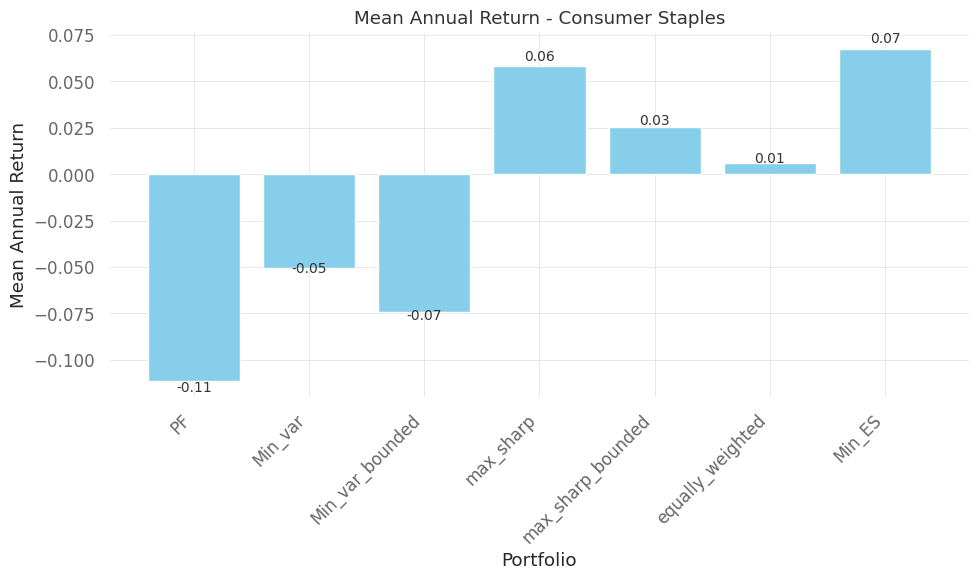

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

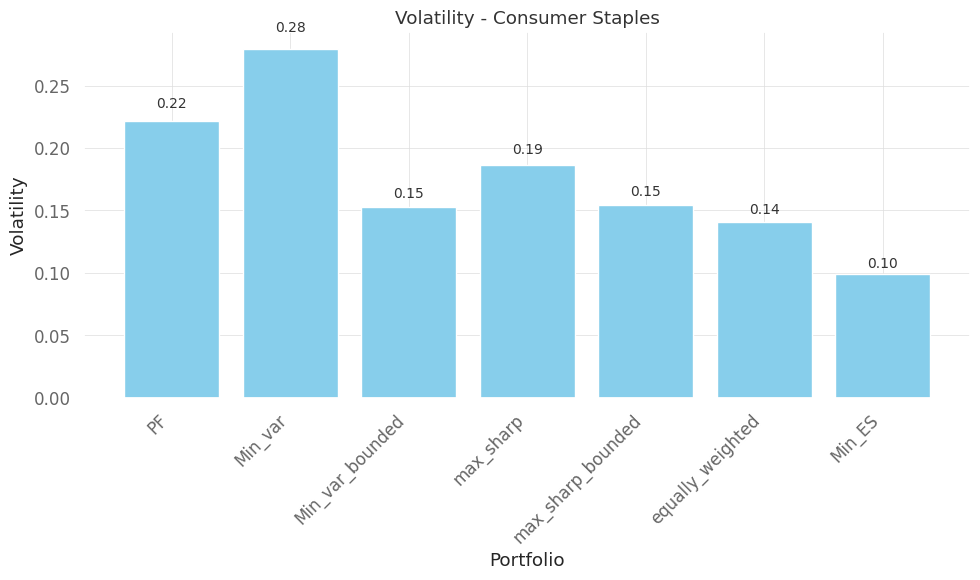

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

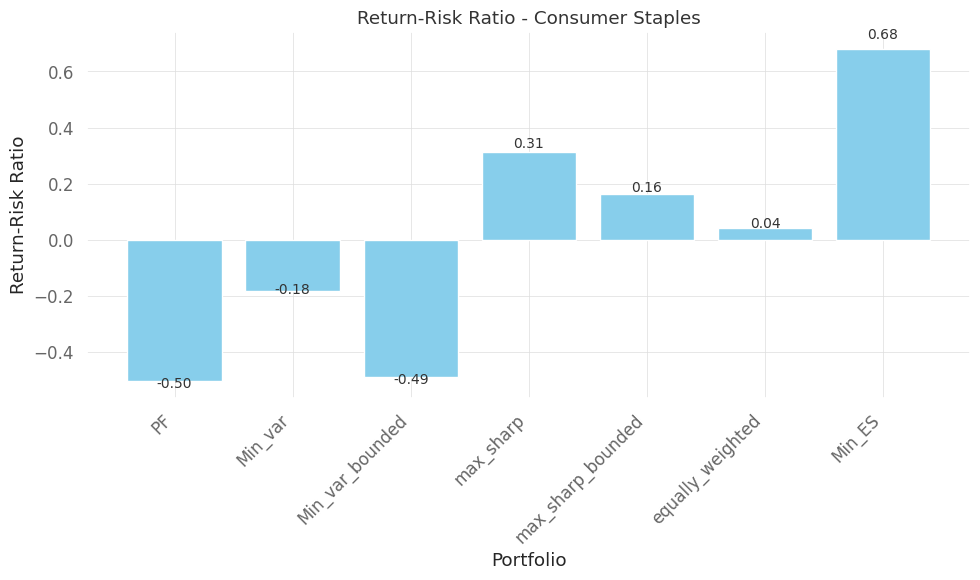

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

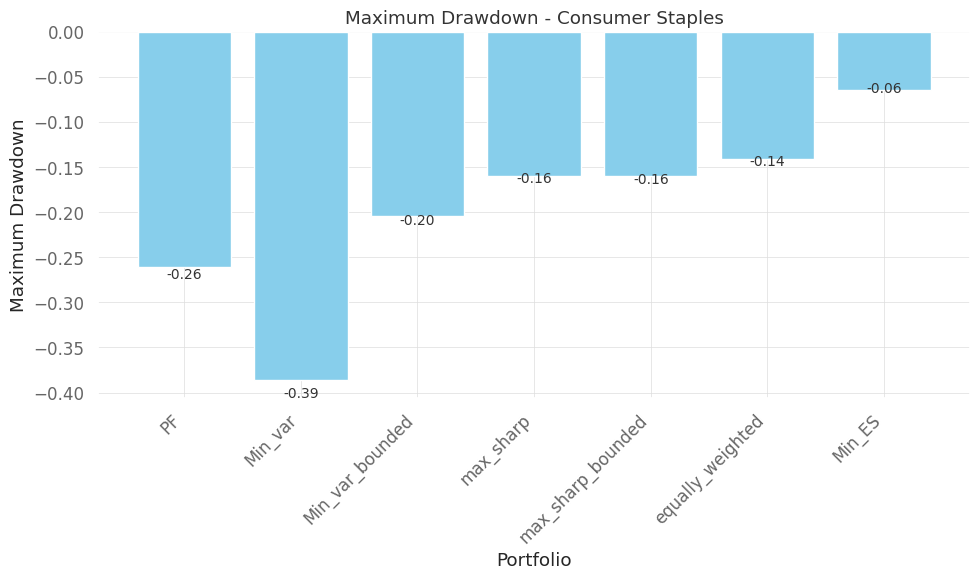

           Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF           -0.111373    0.221313          -0.503237   
1            Min_var           -0.050571    0.279060          -0.181218   
2    Min_var_bounded           -0.074382    0.152508          -0.487728   
3          max_sharp            0.058280    0.186001           0.313333   
4  max_sharp_bounded            0.025420    0.154082           0.164980   
5   equally_weighted            0.005737    0.140521           0.040830   
6             Min_ES            0.067570    0.099122           0.681688   

   Maximum Drawdown  
0         -0.260562  
1         -0.386387  
2         -0.203803  
3         -0.159547  
4         -0.160307  
5         -0.141298  
6         -0.064239  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

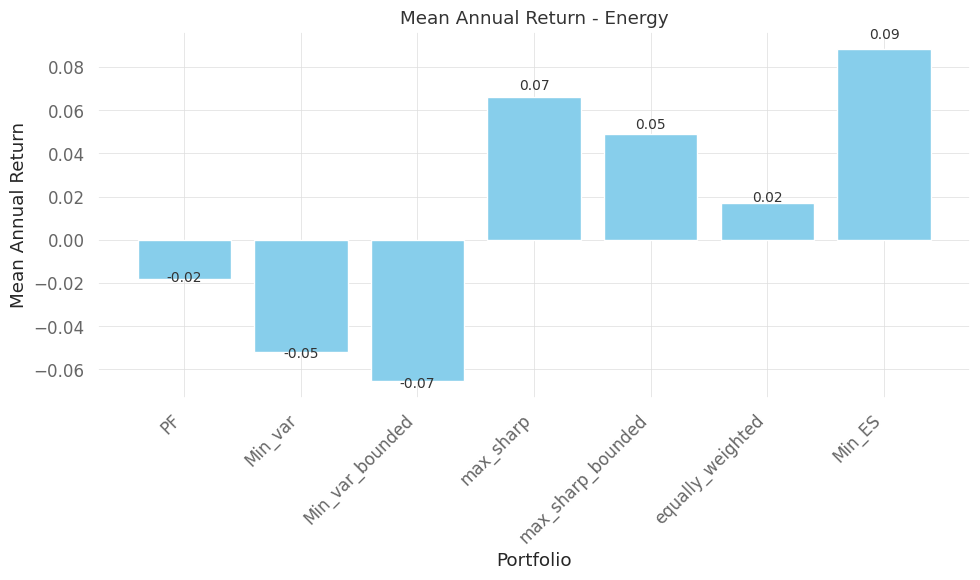

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

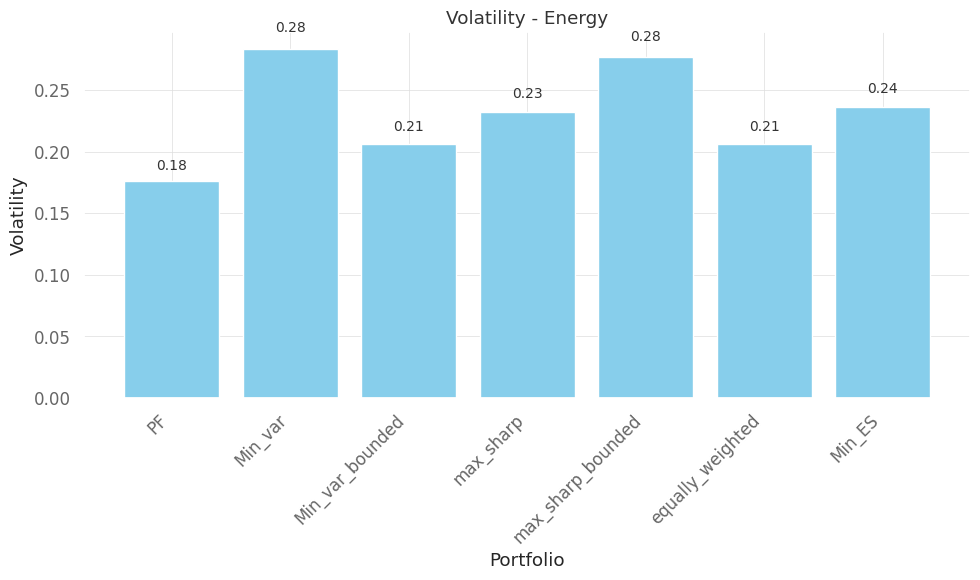

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

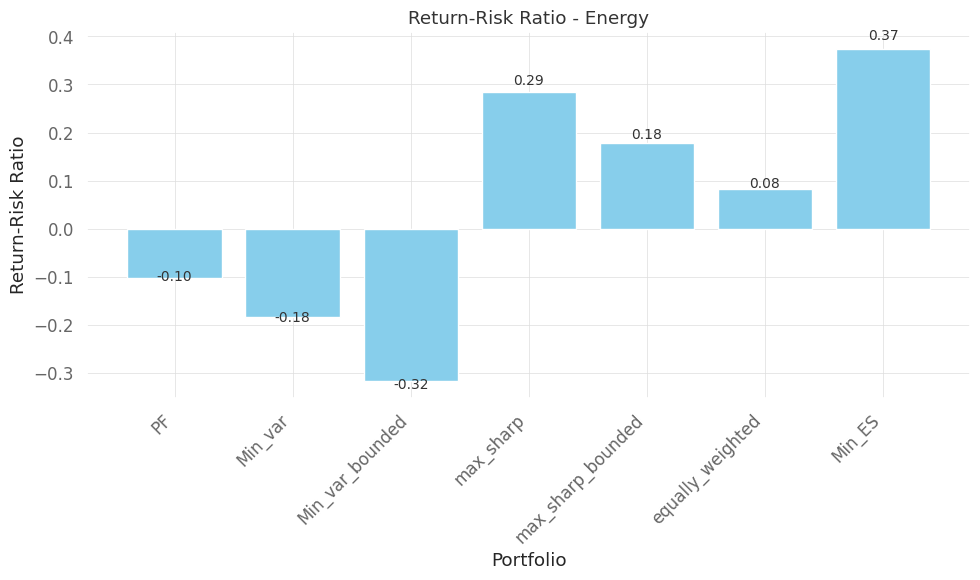

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

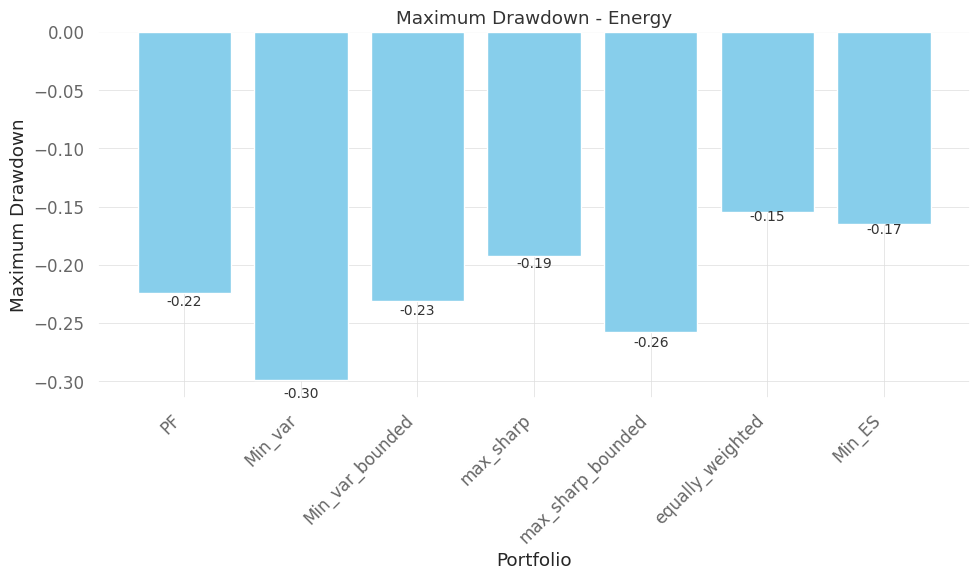

           Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF           -0.018246    0.176196          -0.103557   
1            Min_var           -0.051992    0.283049          -0.183684   
2    Min_var_bounded           -0.065388    0.206378          -0.316834   
3          max_sharp            0.066215    0.232098           0.285290   
4  max_sharp_bounded            0.049176    0.276569           0.177806   
5   equally_weighted            0.016900    0.206330           0.081910   
6             Min_ES            0.088548    0.236307           0.374718   

   Maximum Drawdown  
0         -0.224177  
1         -0.299095  
2         -0.230804  
3         -0.192525  
4         -0.257718  
5         -0.154562  
6         -0.165134  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

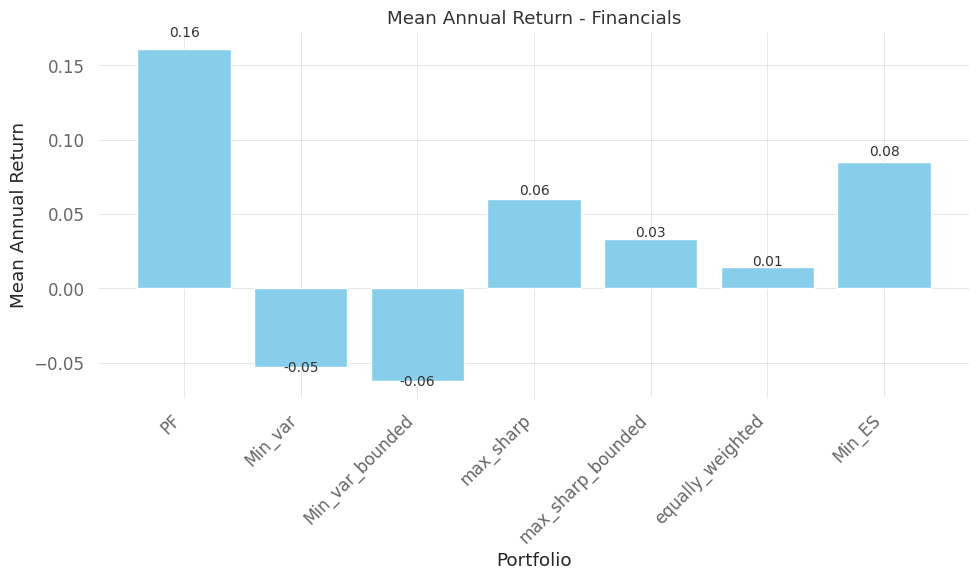

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

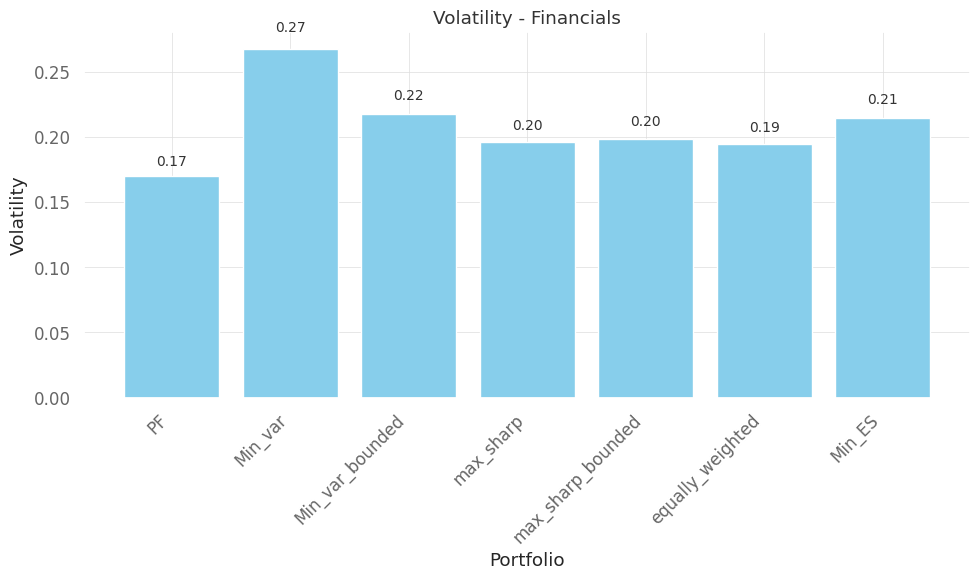

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

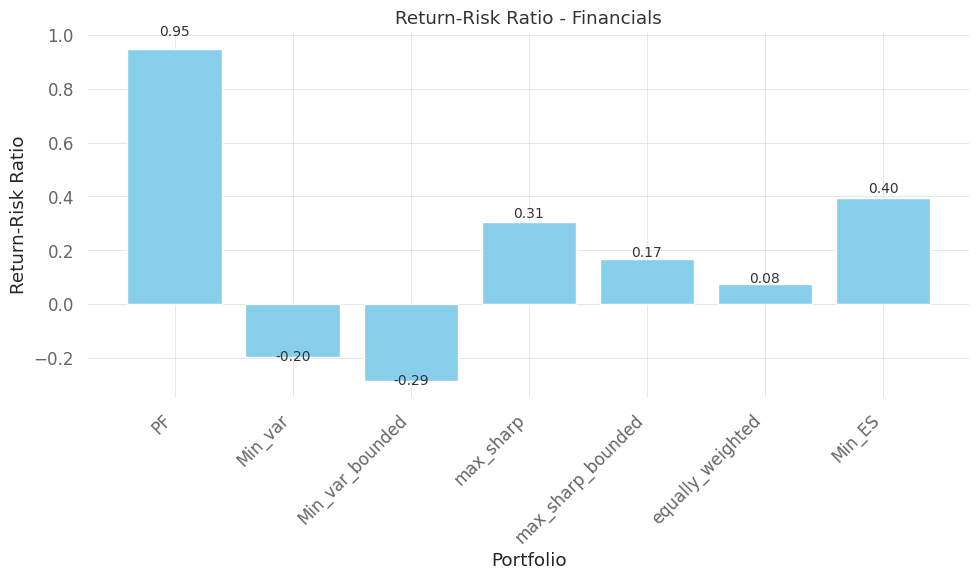

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

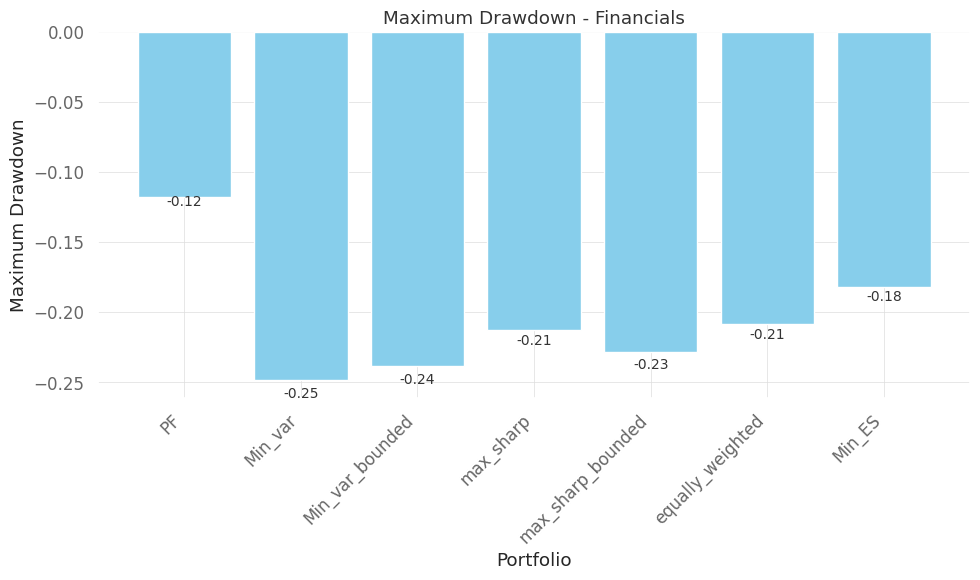

           Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF            0.161203    0.169719           0.949819   
1            Min_var           -0.053188    0.267021          -0.199189   
2    Min_var_bounded           -0.062324    0.217312          -0.286796   
3          max_sharp            0.059775    0.195735           0.305388   
4  max_sharp_bounded            0.033024    0.198322           0.166519   
5   equally_weighted            0.014593    0.194549           0.075012   
6             Min_ES            0.084773    0.214418           0.395363   

   Maximum Drawdown  
0         -0.117968  
1         -0.248668  
2         -0.238843  
3         -0.212855  
4         -0.228709  
5         -0.208367  
6         -0.182381  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

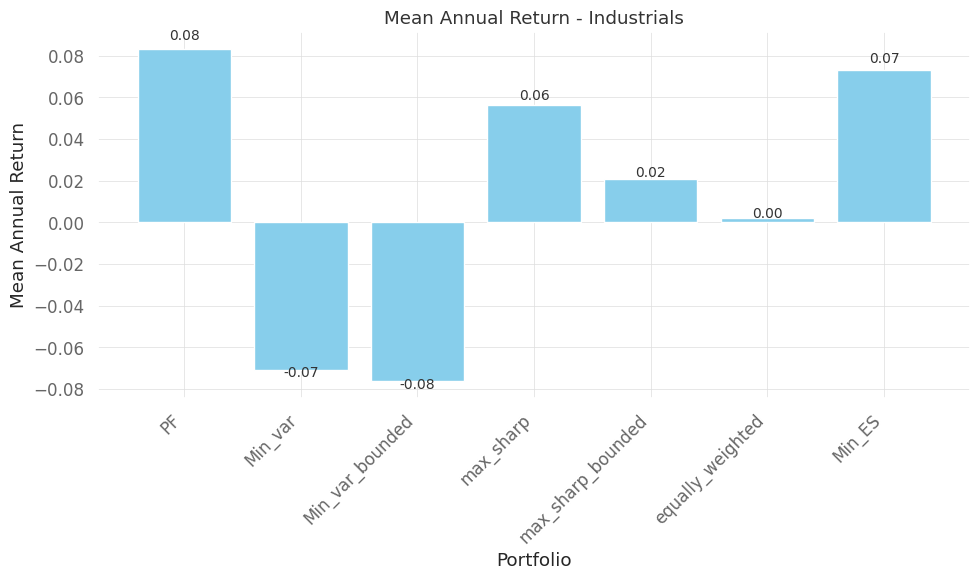

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

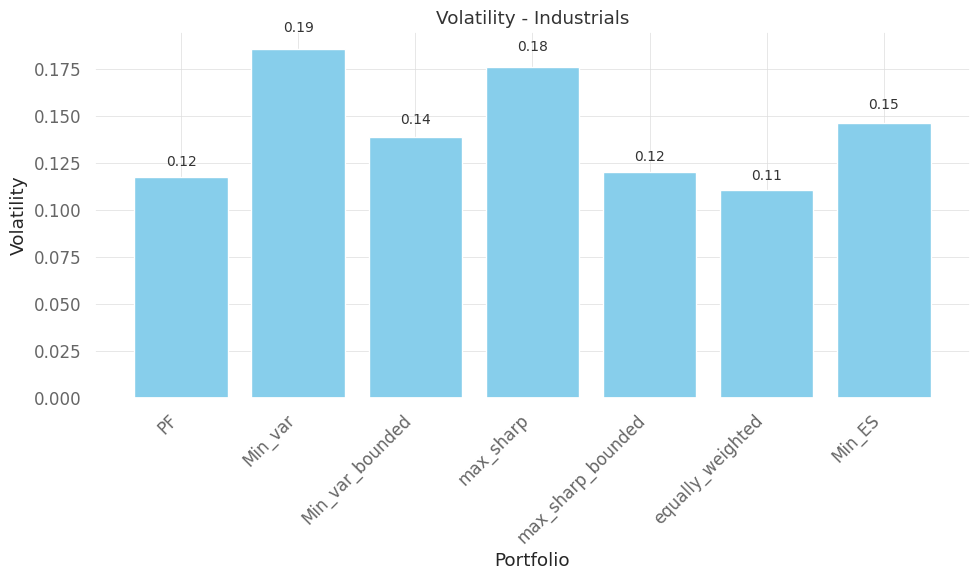

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

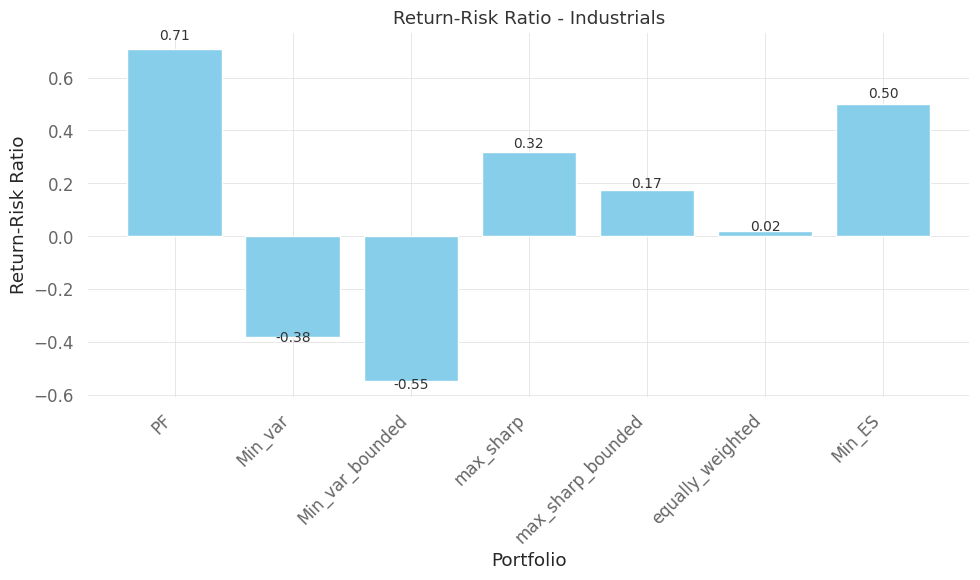

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

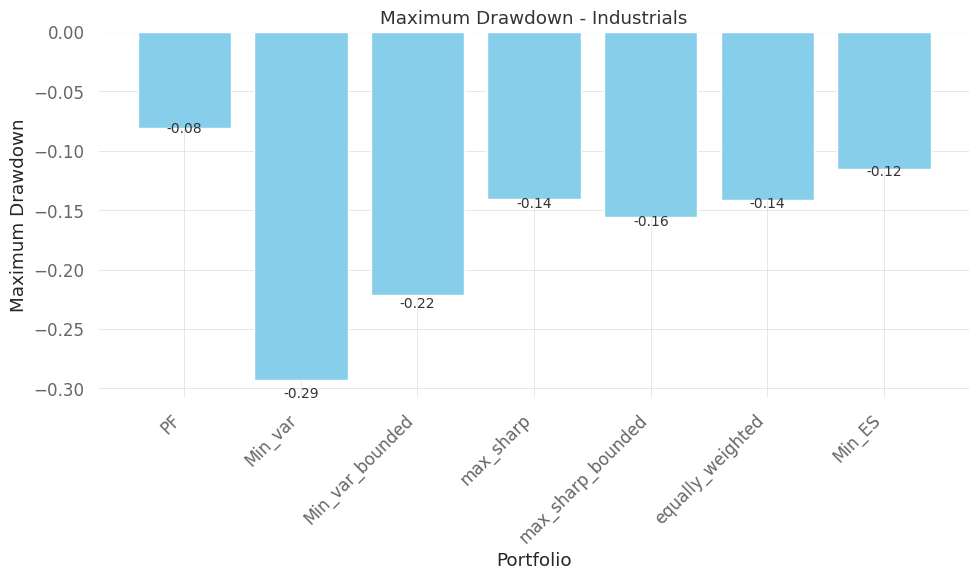

           Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF            0.083468    0.117545           0.710090   
1            Min_var           -0.070700    0.185461          -0.381213   
2    Min_var_bounded           -0.076146    0.138800          -0.548605   
3          max_sharp            0.056224    0.176045           0.319375   
4  max_sharp_bounded            0.020817    0.120009           0.173461   
5   equally_weighted            0.002066    0.110494           0.018701   
6             Min_ES            0.073196    0.146441           0.499833   

   Maximum Drawdown  
0         -0.080543  
1         -0.293136  
2         -0.221169  
3         -0.140996  
4         -0.155378  
5         -0.141091  
6         -0.115498  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

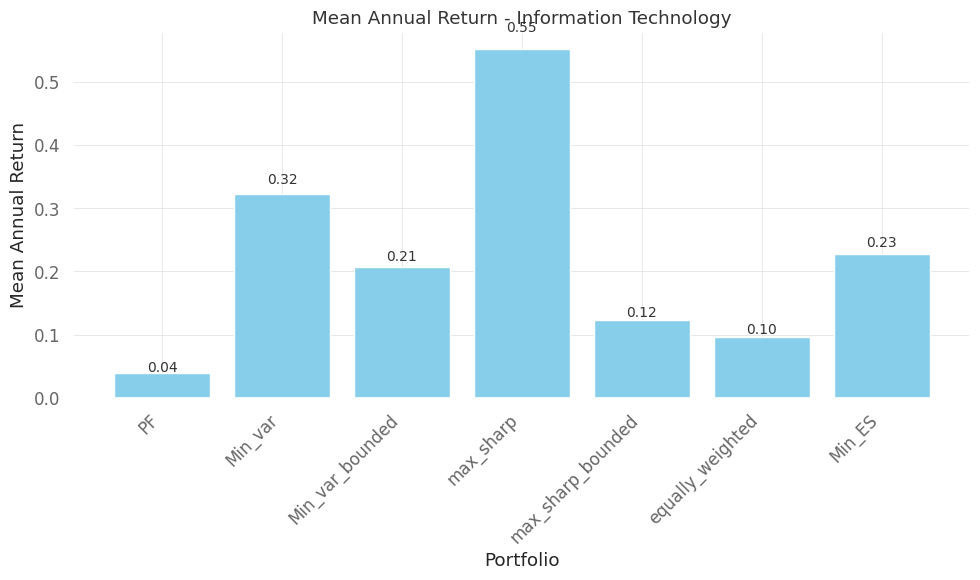

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

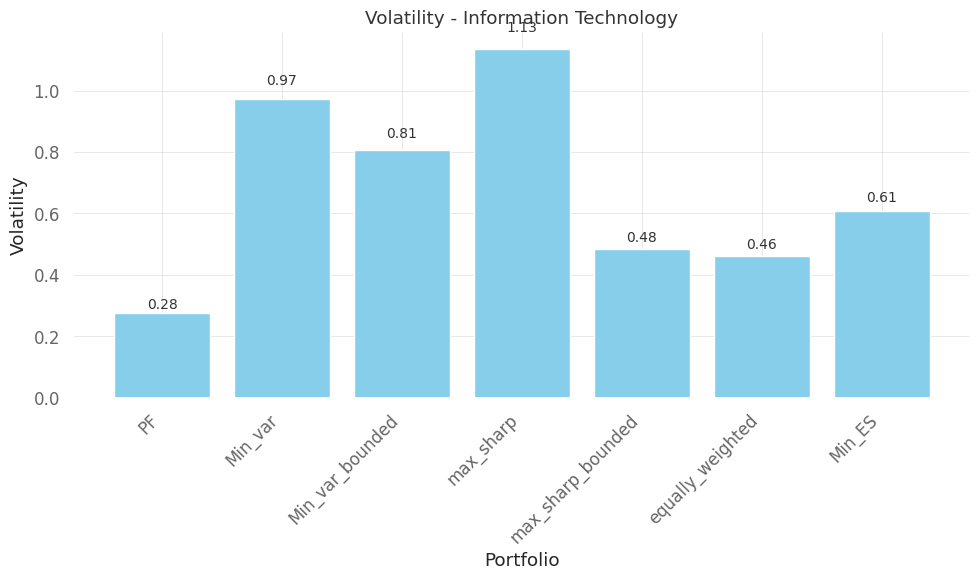

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

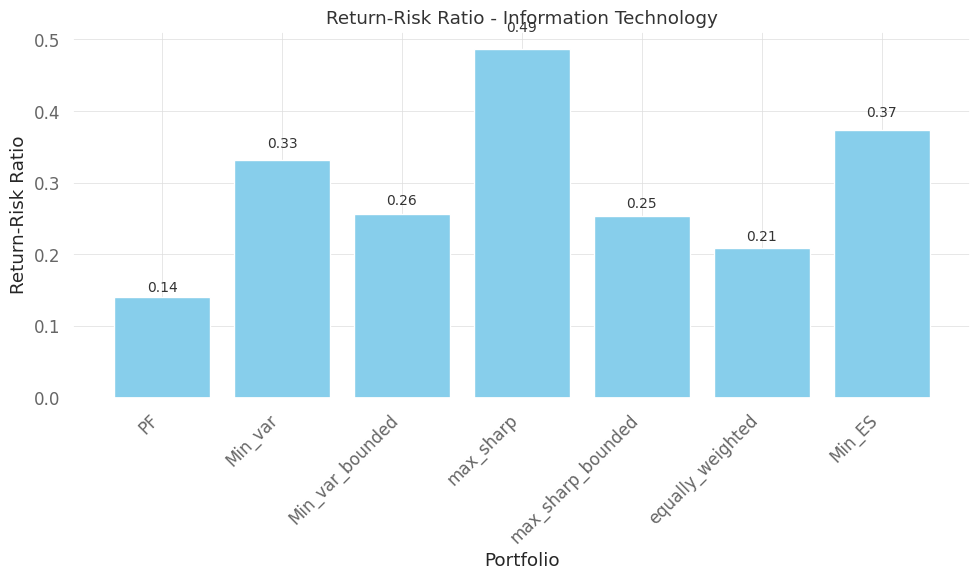

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

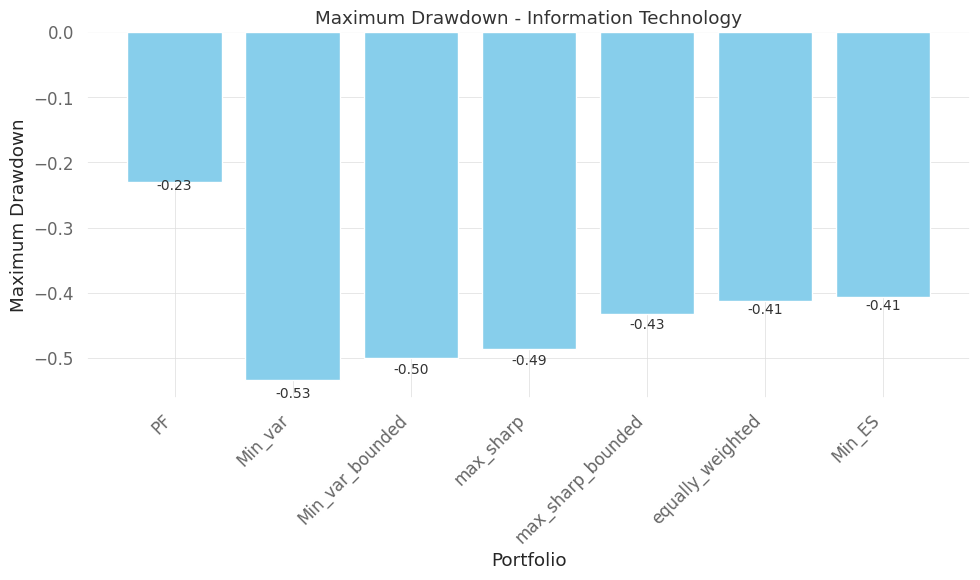

           Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF            0.038864    0.276331           0.140642   
1            Min_var            0.322942    0.971761           0.332326   
2    Min_var_bounded            0.206518    0.806395           0.256101   
3          max_sharp            0.551606    1.134500           0.486210   
4  max_sharp_bounded            0.122227    0.482575           0.253280   
5   equally_weighted            0.096578    0.461741           0.209161   
6             Min_ES            0.227758    0.608766           0.374131   

   Maximum Drawdown  
0         -0.229566  
1         -0.534042  
2         -0.499582  
3         -0.485711  
4         -0.433081  
5         -0.412017  
6         -0.406193  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

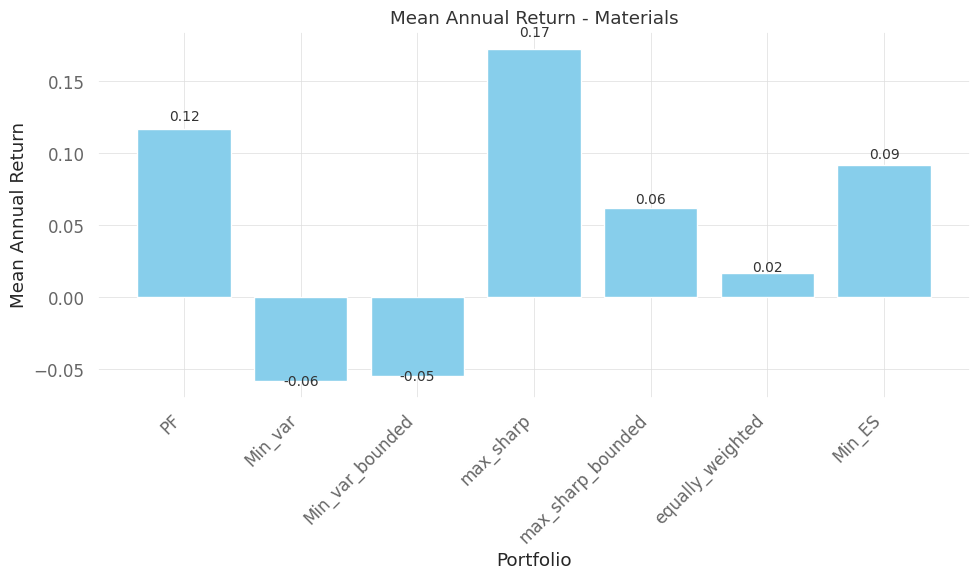

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

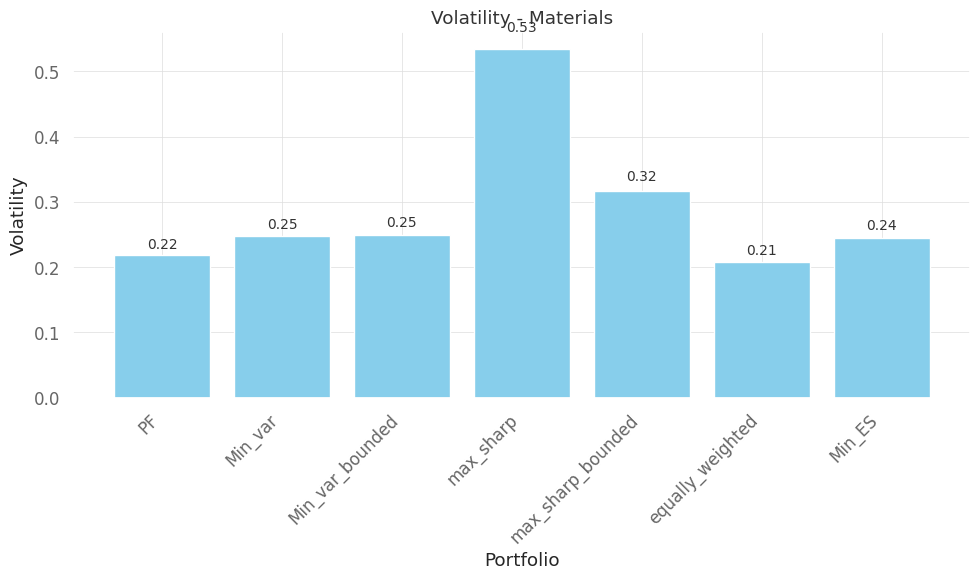

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

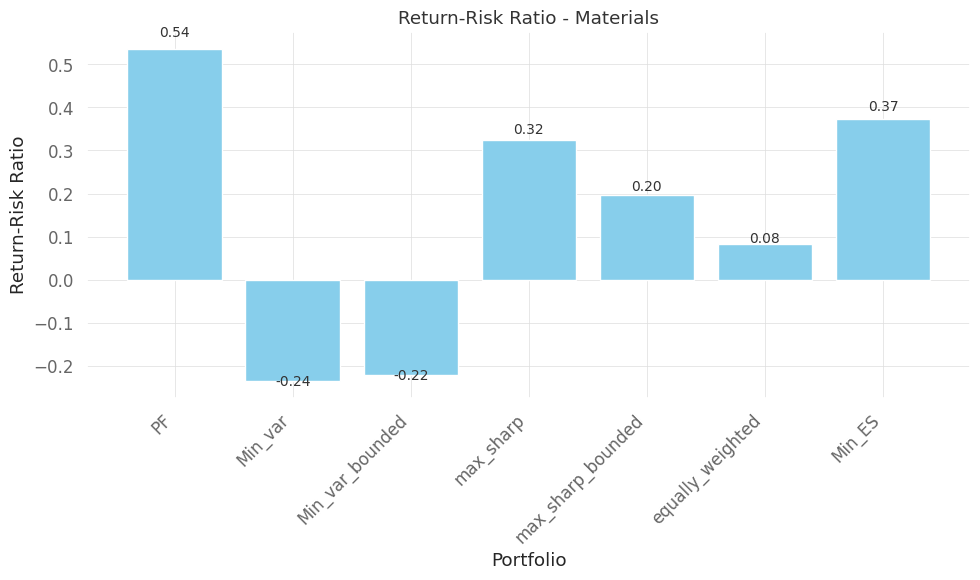

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

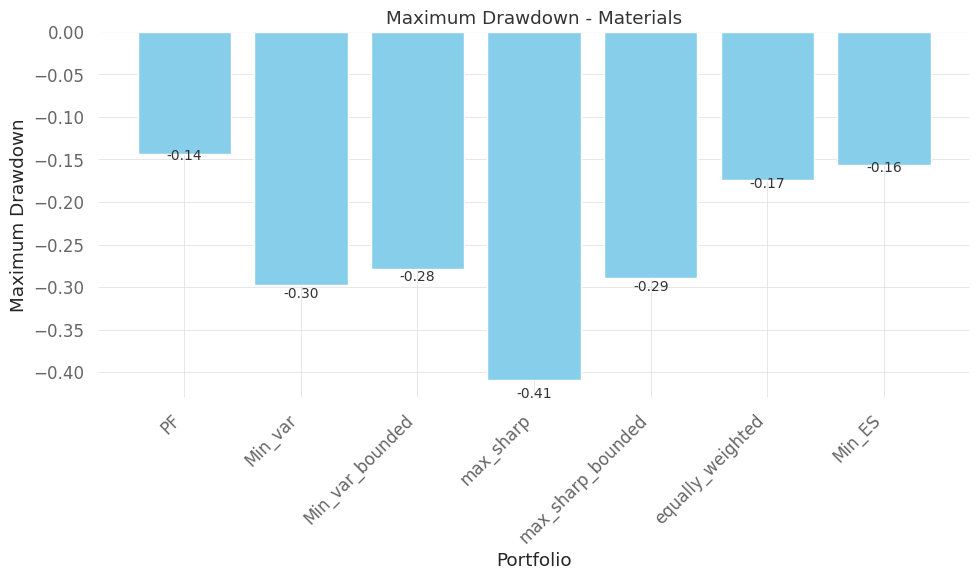

           Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF            0.117051    0.218251           0.536314   
1            Min_var           -0.058101    0.247207          -0.235030   
2    Min_var_bounded           -0.054829    0.249136          -0.220076   
3          max_sharp            0.172655    0.533776           0.323459   
4  max_sharp_bounded            0.061971    0.316292           0.195931   
5   equally_weighted            0.017036    0.208200           0.081827   
6             Min_ES            0.091506    0.244780           0.373830   

   Maximum Drawdown  
0         -0.143330  
1         -0.297102  
2         -0.278269  
3         -0.409567  
4         -0.289688  
5         -0.174374  
6         -0.156588  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

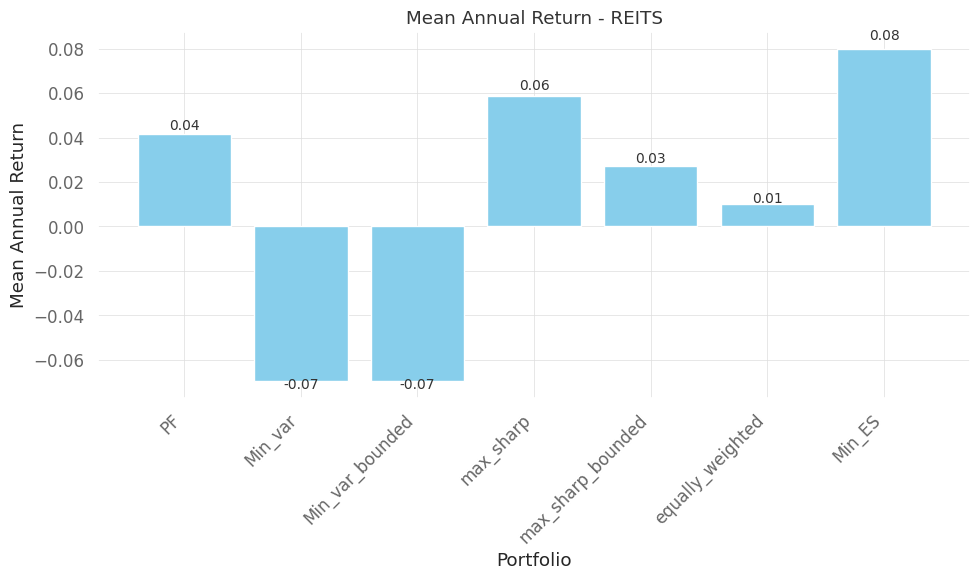

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

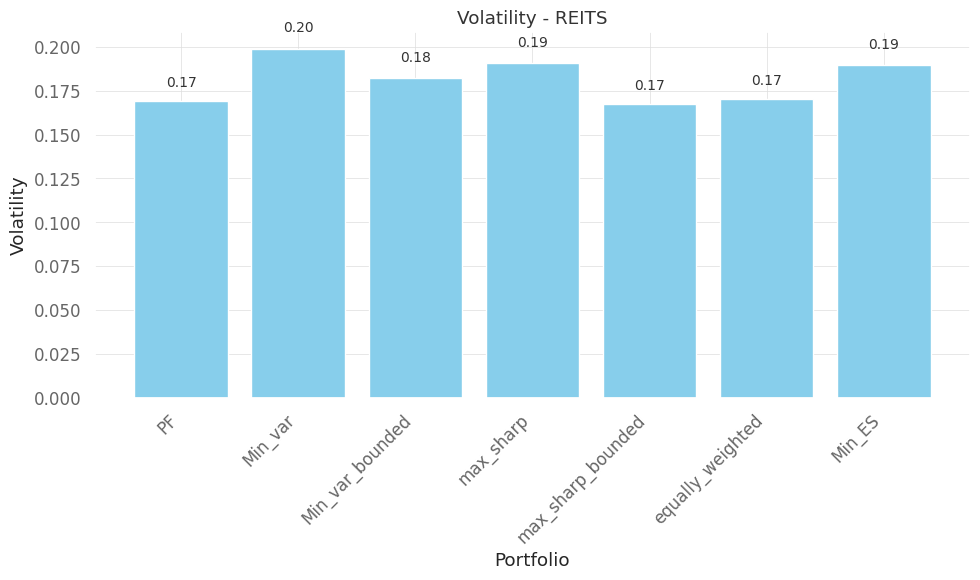

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

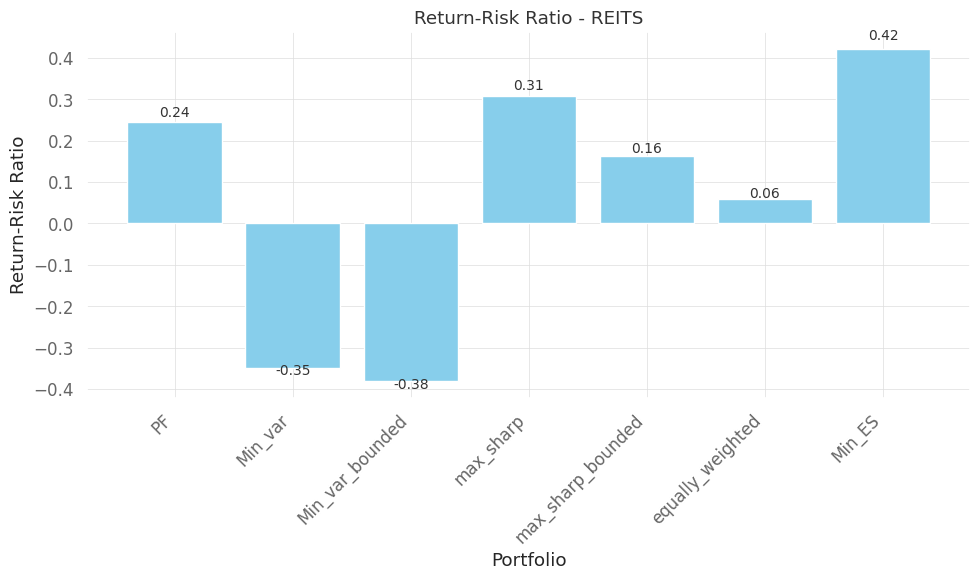

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

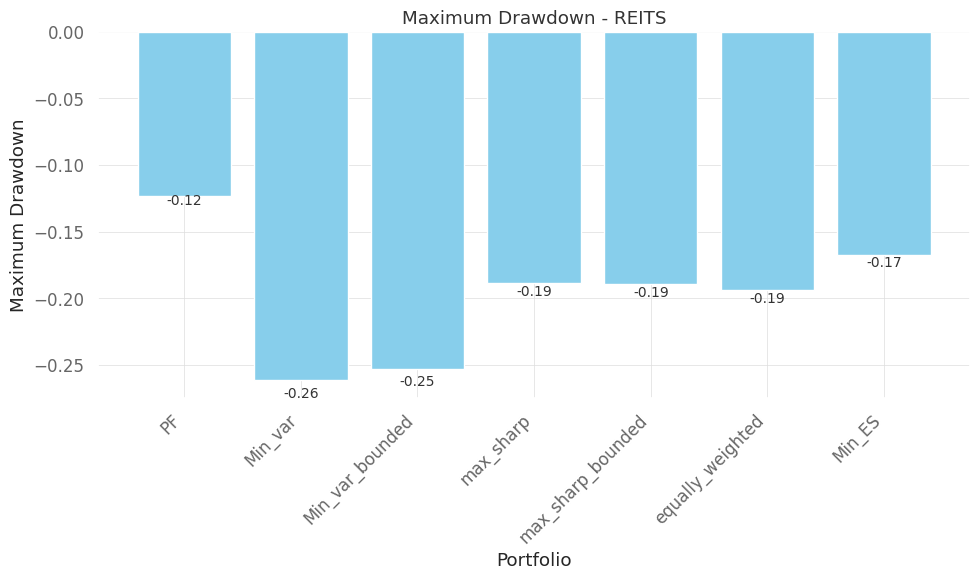

           Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF            0.041384    0.169157           0.244647   
1            Min_var           -0.069312    0.198567          -0.349063   
2    Min_var_bounded           -0.069489    0.182442          -0.380883   
3          max_sharp            0.058796    0.190714           0.308296   
4  max_sharp_bounded            0.027228    0.167336           0.162717   
5   equally_weighted            0.010077    0.170237           0.059192   
6             Min_ES            0.080011    0.189437           0.422361   

   Maximum Drawdown  
0         -0.123496  
1         -0.261663  
2         -0.252892  
3         -0.188568  
4         -0.189663  
5         -0.193931  
6         -0.167619  
Attention : Le portefeuille max_sharp comporte des lignes avec une 'Total Value' nulle. Ces lignes seront supprimées.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

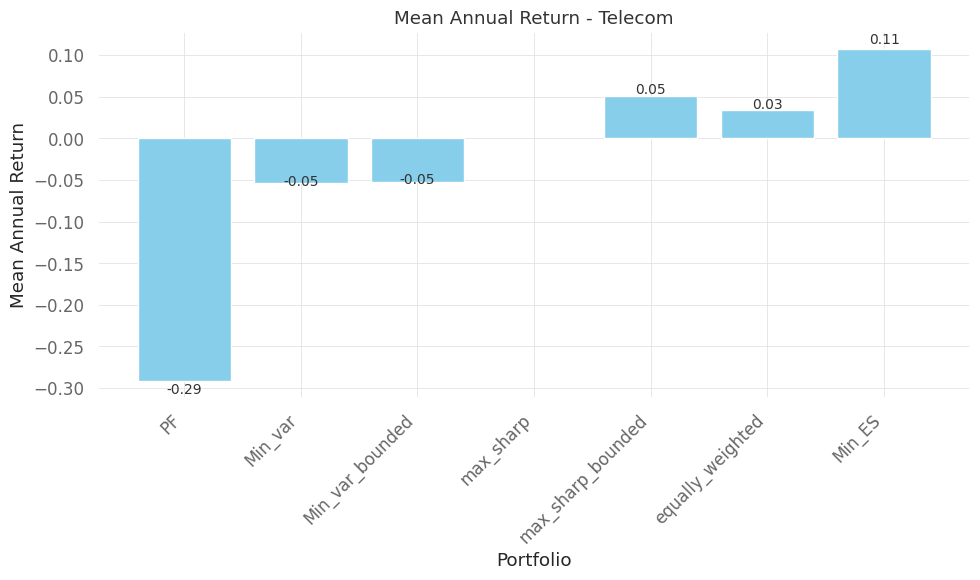

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

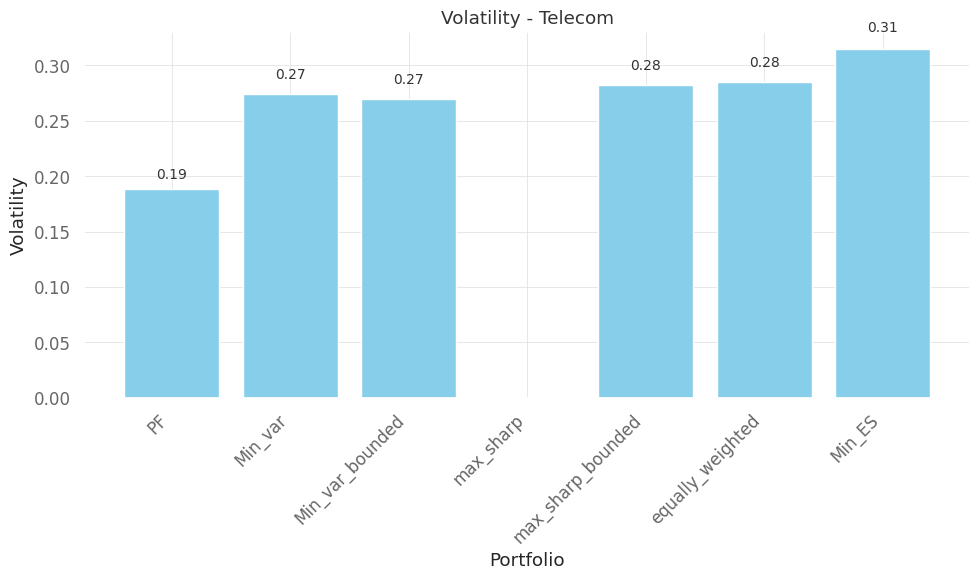

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

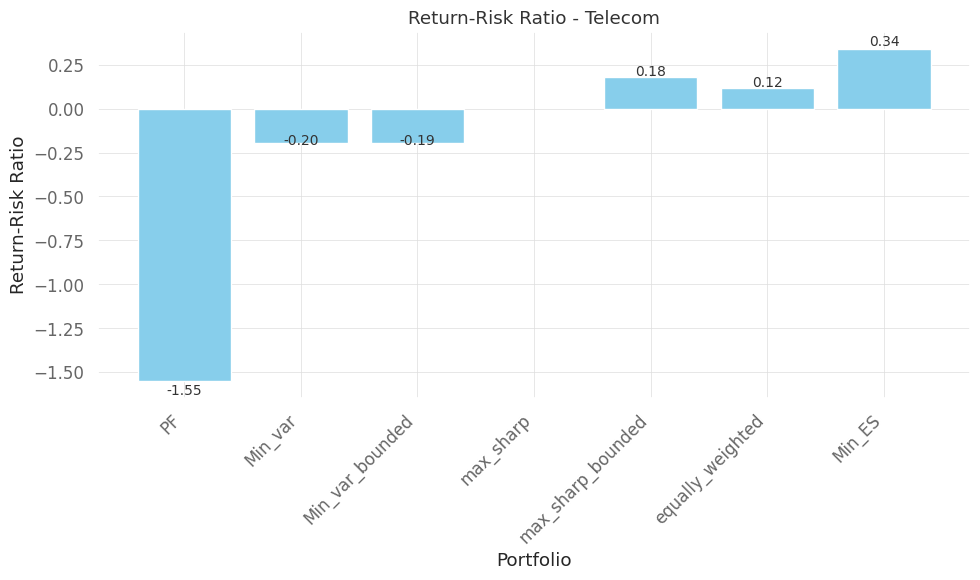

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

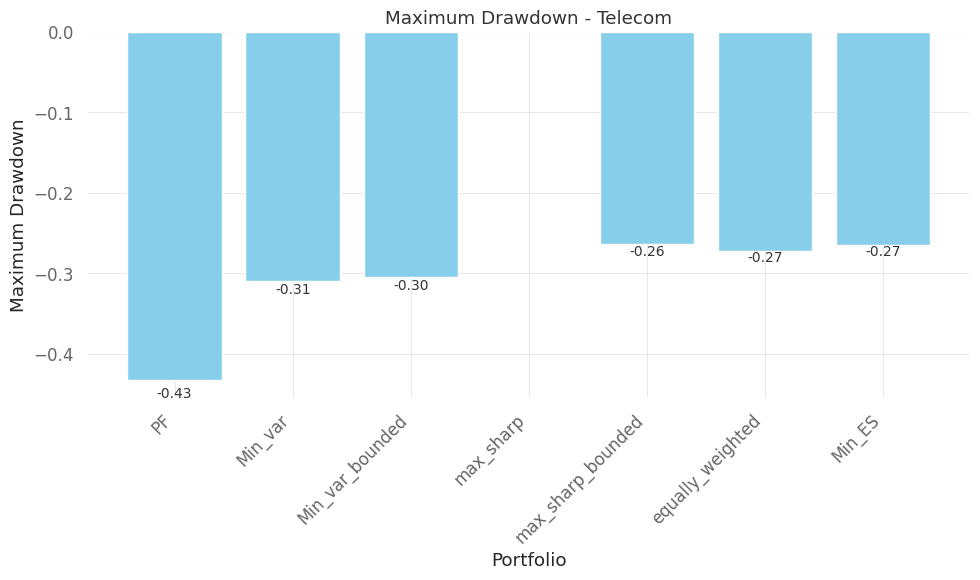

           Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF           -0.291596    0.187981          -1.551197   
1            Min_var           -0.054104    0.274098          -0.197390   
2    Min_var_bounded           -0.052103    0.269845          -0.193084   
3          max_sharp                 NaN         NaN                NaN   
4  max_sharp_bounded            0.051038    0.281954           0.181014   
5   equally_weighted            0.033645    0.284864           0.118109   
6             Min_ES            0.107776    0.314532           0.342655   

   Maximum Drawdown  
0         -0.433020  
1         -0.309844  
2         -0.304920  
3               NaN  
4         -0.264252  
5         -0.271899  
6         -0.265415  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

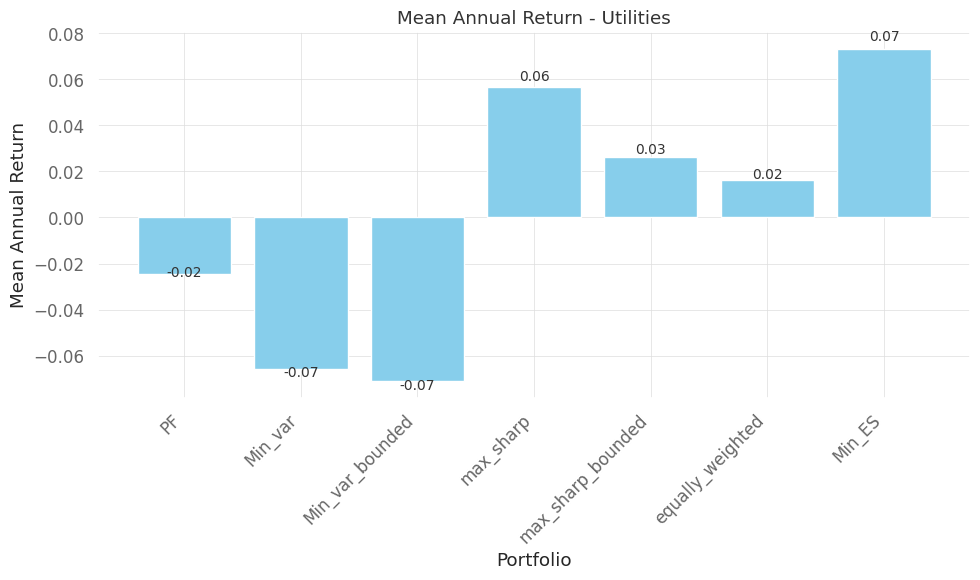

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

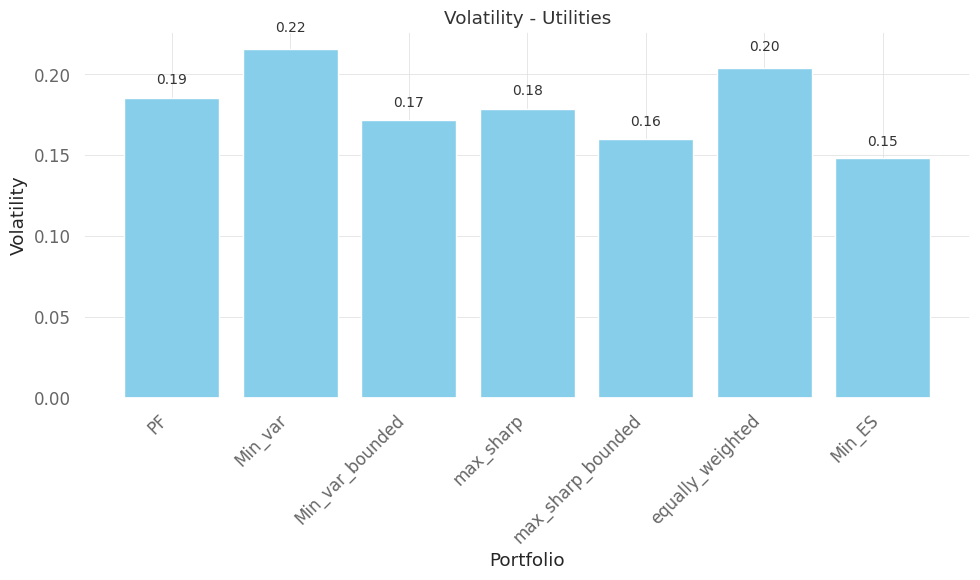

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

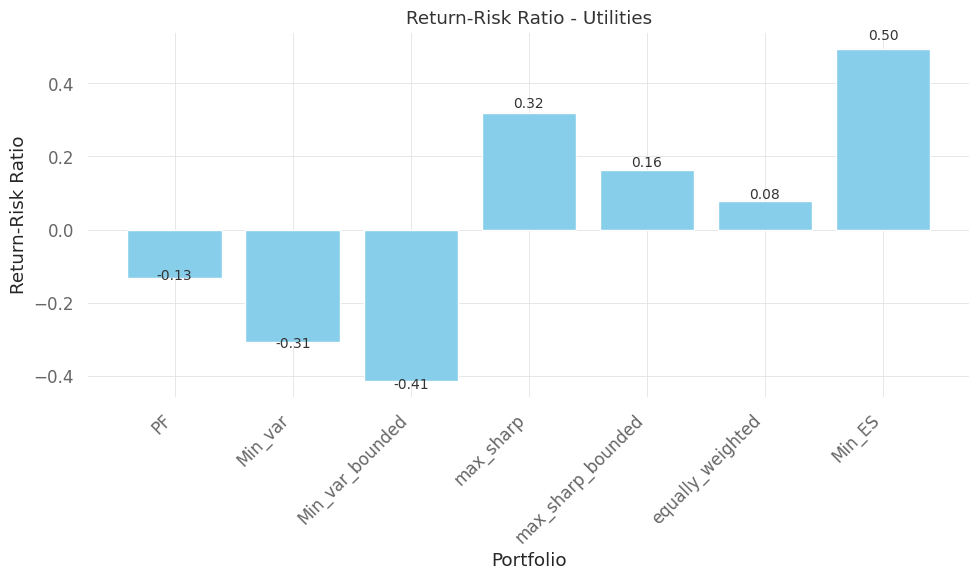

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

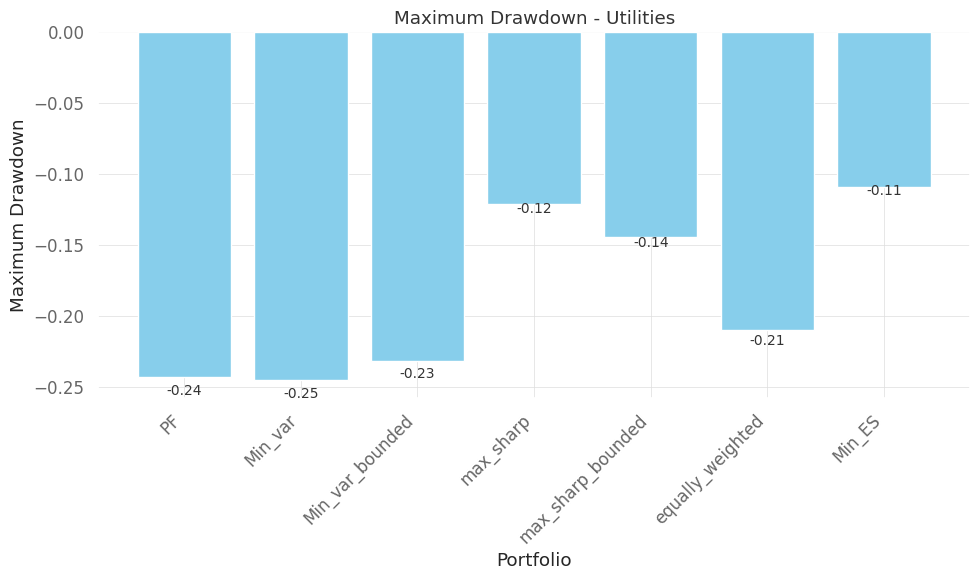

           Portfolio  Mean Annual Return  Volatility  Return-Risk Ratio  \
0                 PF           -0.024359    0.185243          -0.131497   
1            Min_var           -0.065942    0.215376          -0.306170   
2    Min_var_bounded           -0.071020    0.171521          -0.414064   
3          max_sharp            0.056716    0.178271           0.318142   
4  max_sharp_bounded            0.026278    0.159979           0.164260   
5   equally_weighted            0.016218    0.204149           0.079444   
6             Min_ES            0.073372    0.148215           0.495040   

   Maximum Drawdown  
0         -0.243225  
1         -0.245363  
2         -0.231831  
3         -0.121522  
4         -0.144156  
5         -0.209671  
6         -0.109243  


In [ ]:
for sector in secteurs_dict:
    sector_performance_table = calculate_and_compare_portfolio_performance_by_sector(portfolio_values_list, portfolio_names, sector)
    plot_performance_metrics(sector_performance_table, f'figures/4_sector_performance_comparison_{sector}', f' - {sector}')
    print(sector_performance_table)

# Comparaison des rendements de chaque portefeuille

In [ ]:
def extract_sector_portfolios(portfolio_values_list, sector_name):
    """
    Pour chaque DataFrame dans portfolio_values_list, extrait les colonnes correspondant
    aux tickers du secteur spécifié et ajoute une colonne 'Total Value' qui est la somme
    des valeurs par ligne.

    Args:
        portfolio_values_list (list): Liste de DataFrames représentant les portefeuilles.
        sector_name (str): Nom du secteur à extraire (clé dans secteurs_dict).

    Returns:
        list: Nouvelle liste de DataFrames filtrés par secteur avec la colonne 'Total Value'.
    """
    new_portfolios = []
    # Récupérer la liste des tickers pour le secteur spécifié depuis votre dictionnaire
    for portfolio_df in portfolio_values_list:
        # Extraire uniquement les colonnes correspondant aux tickers du secteur
        new_portfolio = portfolio_df[secteurs_dict[sector_name]].copy()

        # Calculer la valeur totale en sommant les colonnes ligne par ligne
        new_portfolio['Total Value'] = new_portfolio.sum(axis=1)

        new_portfolios.append(new_portfolio)
    return new_portfolios

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

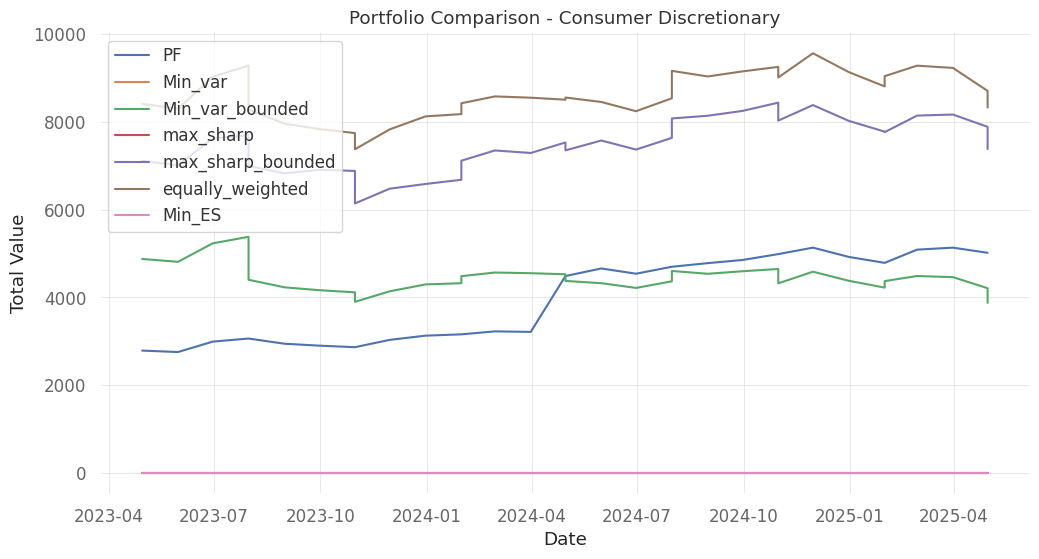

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

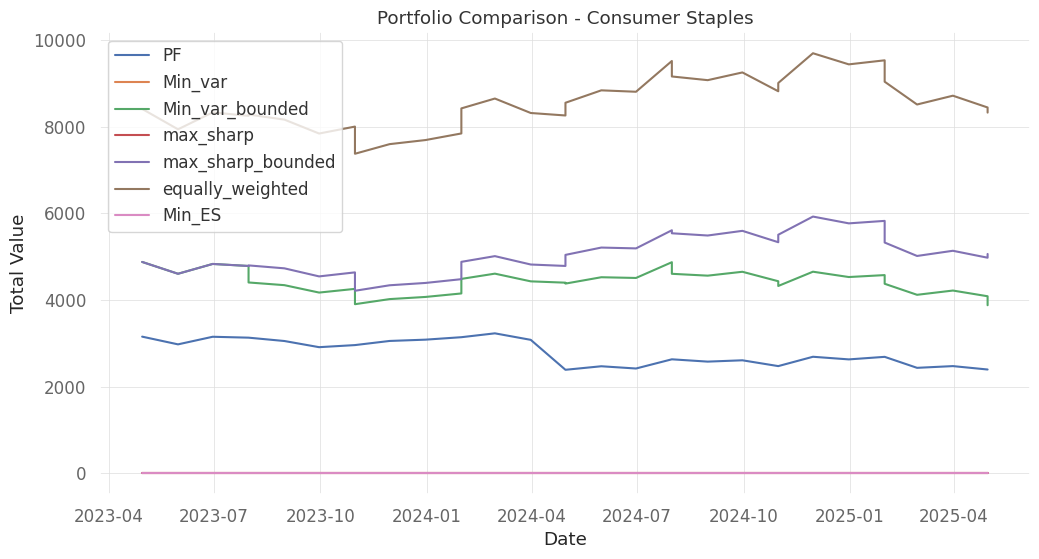

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

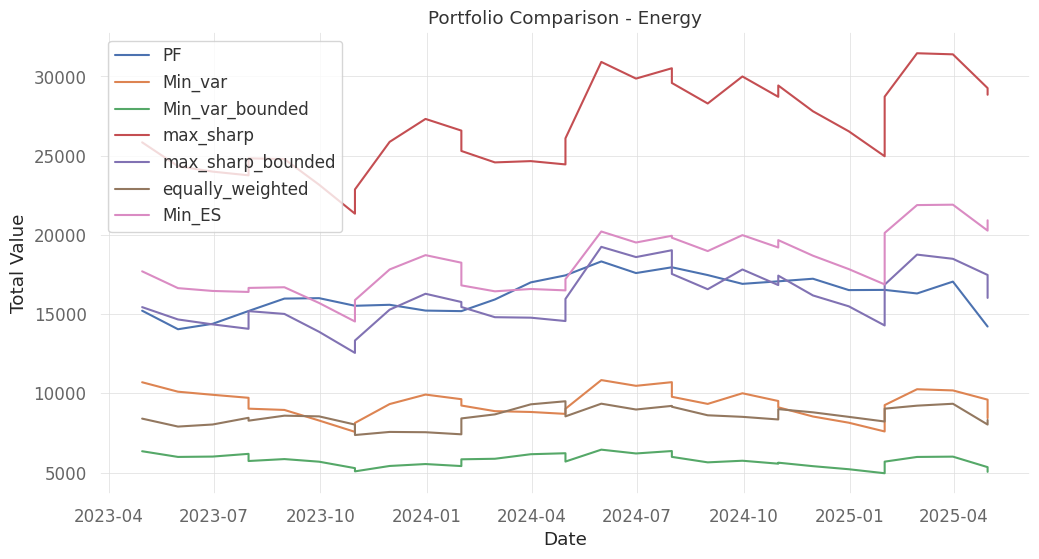

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

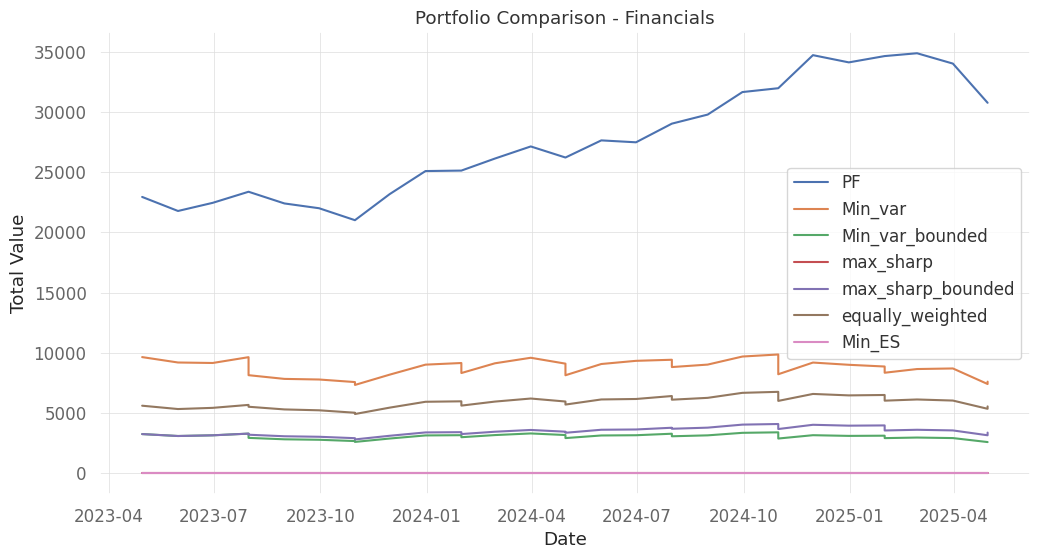

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

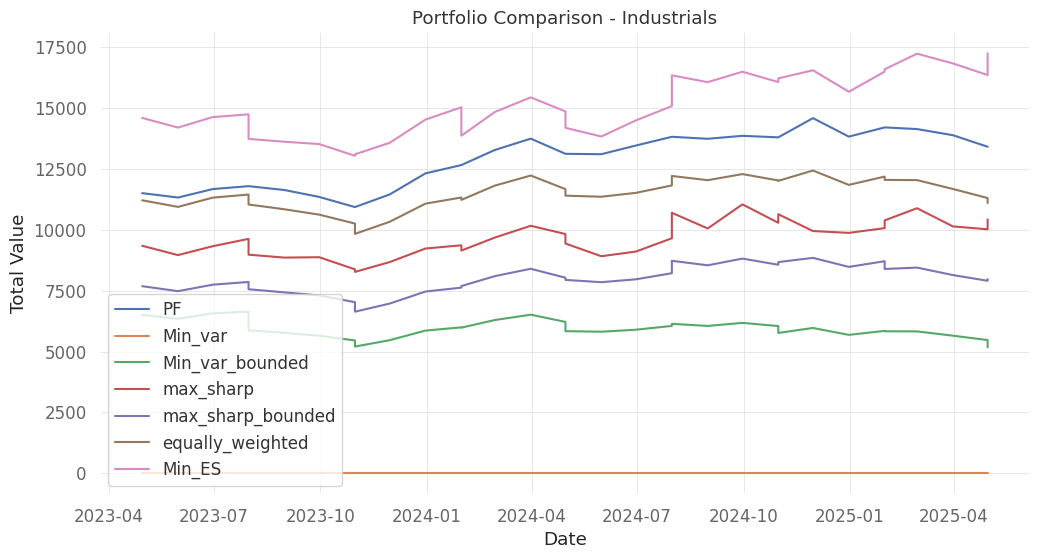

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

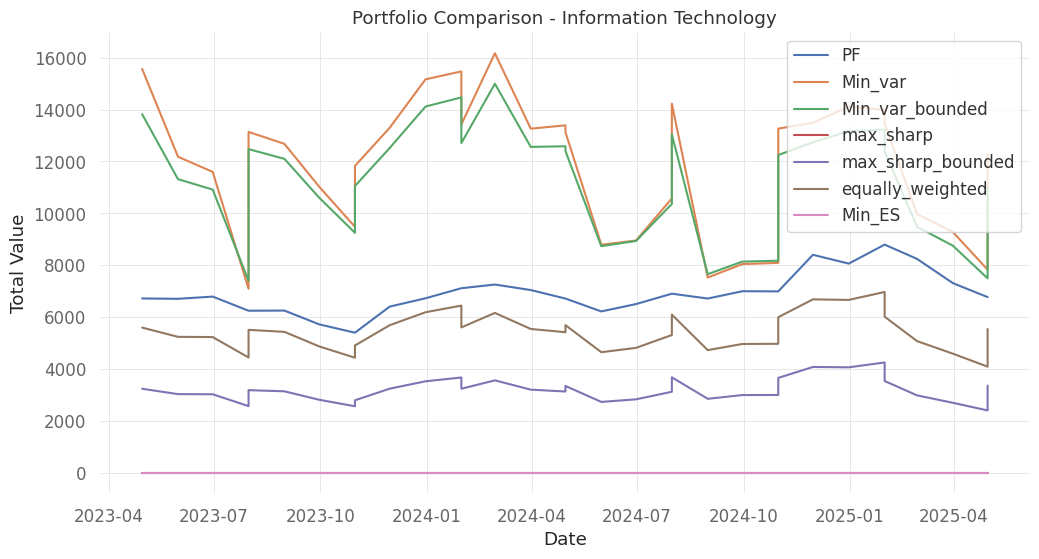

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

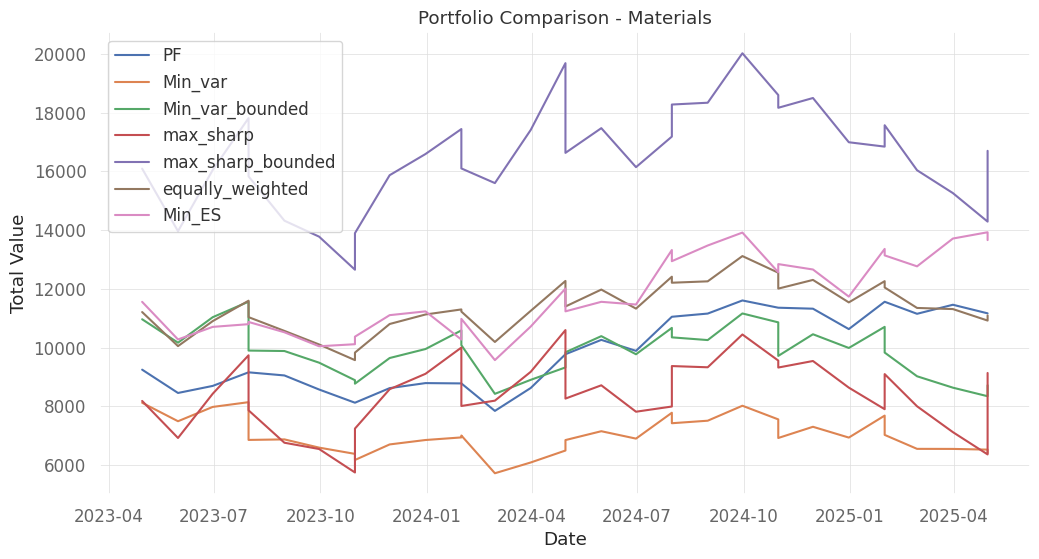

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

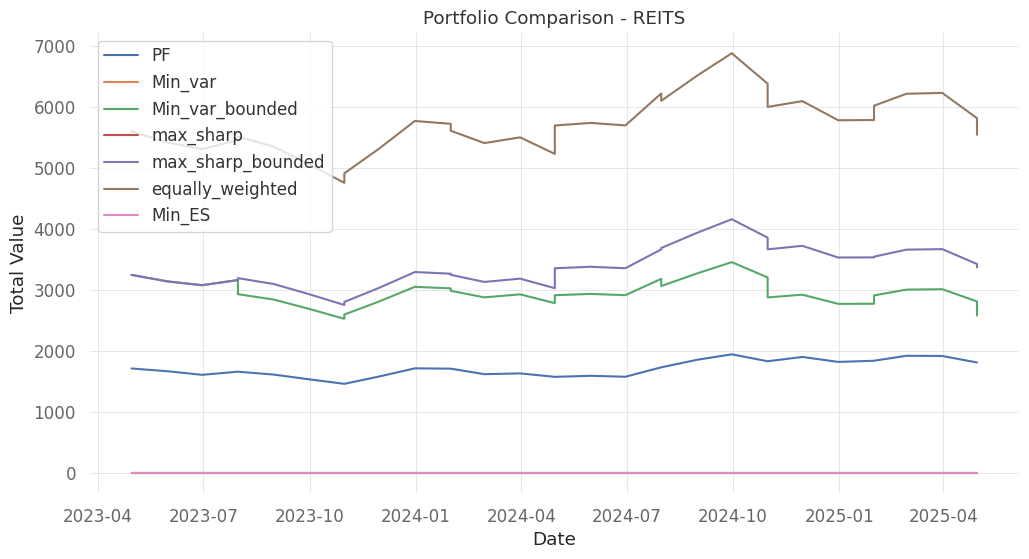

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

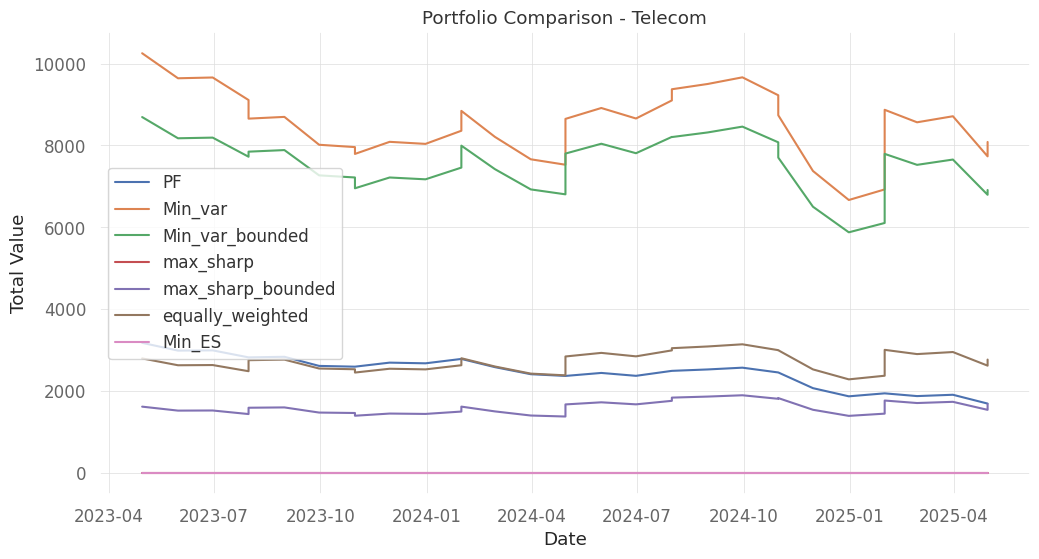

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

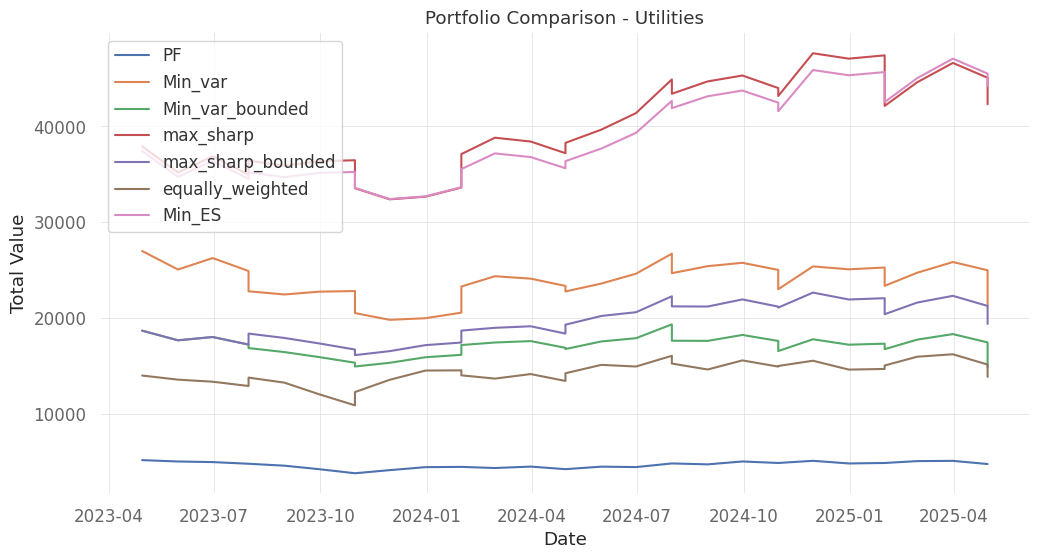

In [ ]:
for sector in secteurs_dict:
    portfolio_values_by_sector_list = extract_sector_portfolios(portfolio_values_list, sector)
    plot_portfolio_comparison(portfolio_values_by_sector_list, portfolio_names, f'4_sector_portfolio_comparison_{sector}', f' - {sector}')